Base results directory: /home/users/ntu/chong032/slimsc/prune/results/R1-Distill-Qwen-14B/gpqa_diamond

--- Aggregating data from experiments ---

Processing experiment: diversity_n10_thresh0.50 (Strategy: diversity, Label: diversity (n=10, thr=0.50))
  -> Processed 50 valid summary files.
  -> Stored data for 50 questions. Max step in exp: 15

Processing experiment: diversity_n10_thresh0.55 (Strategy: diversity, Label: diversity (n=10, thr=0.55))
  -> Processed 50 valid summary files.
  -> Stored data for 50 questions. Max step in exp: 18

Processing experiment: diversity_n10_thresh0.60 (Strategy: diversity, Label: diversity (n=10, thr=0.60))
  -> Processed 50 valid summary files.
  -> Stored data for 50 questions. Max step in exp: 14

Processing experiment: diversity_n10_thresh0.65 (Strategy: diversity, Label: diversity (n=10, thr=0.65))
  -> Processed 50 valid summary files.
  -> Stored data for 50 questions. Max step in exp: 17

Processing experiment: diversity_n10_thresh0.70 (Stra

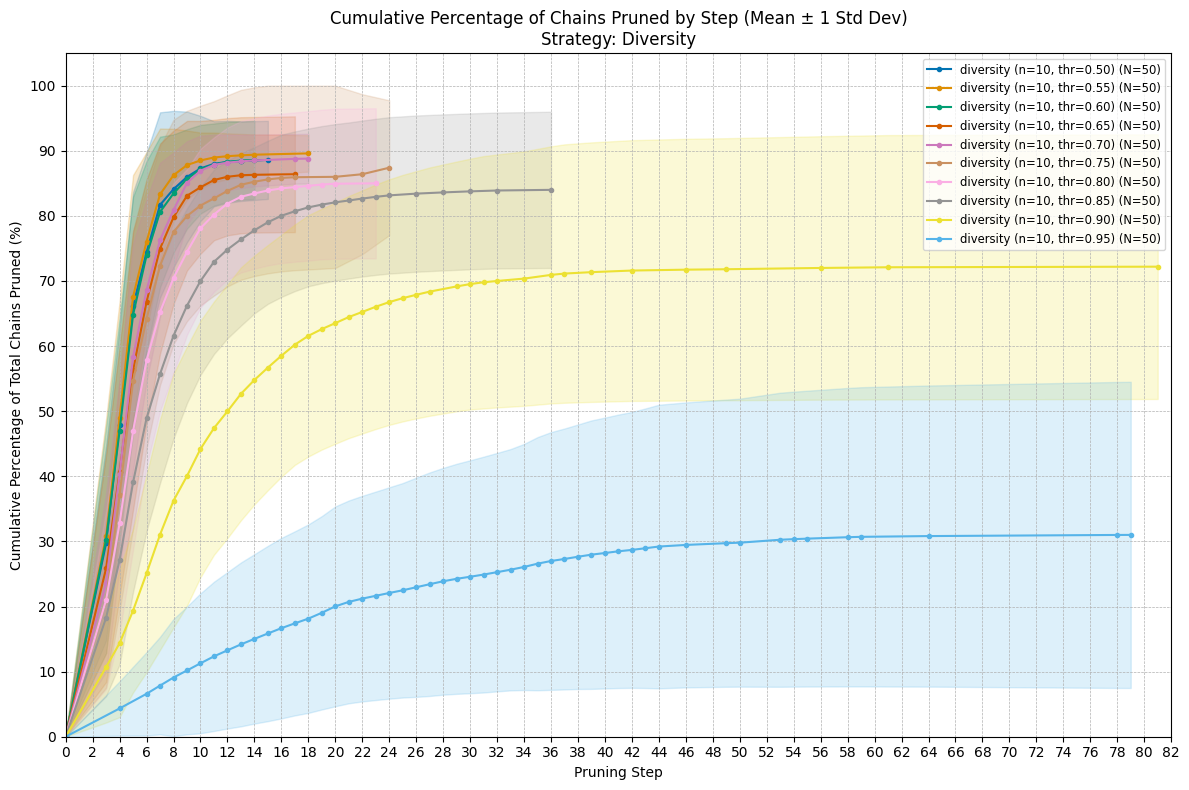


Generating plot for strategy: fewest_thoughts
  -> Calculated stats for 'fewest thoughts (n=10, thr=0.50)' (50 questions).
  -> Calculated stats for 'fewest thoughts (n=10, thr=0.55)' (50 questions).
  -> Calculated stats for 'fewest thoughts (n=10, thr=0.60)' (50 questions).
  -> Calculated stats for 'fewest thoughts (n=10, thr=0.65)' (50 questions).
  -> Calculated stats for 'fewest thoughts (n=10, thr=0.70)' (50 questions).
  -> Calculated stats for 'fewest thoughts (n=10, thr=0.75)' (50 questions).
  -> Calculated stats for 'fewest thoughts (n=10, thr=0.80)' (50 questions).
  -> Calculated stats for 'fewest thoughts (n=10, thr=0.85)' (50 questions).
  -> Calculated stats for 'fewest thoughts (n=10, thr=0.90)' (50 questions).
  -> Calculated stats for 'fewest thoughts (n=10, thr=0.95)' (50 questions).


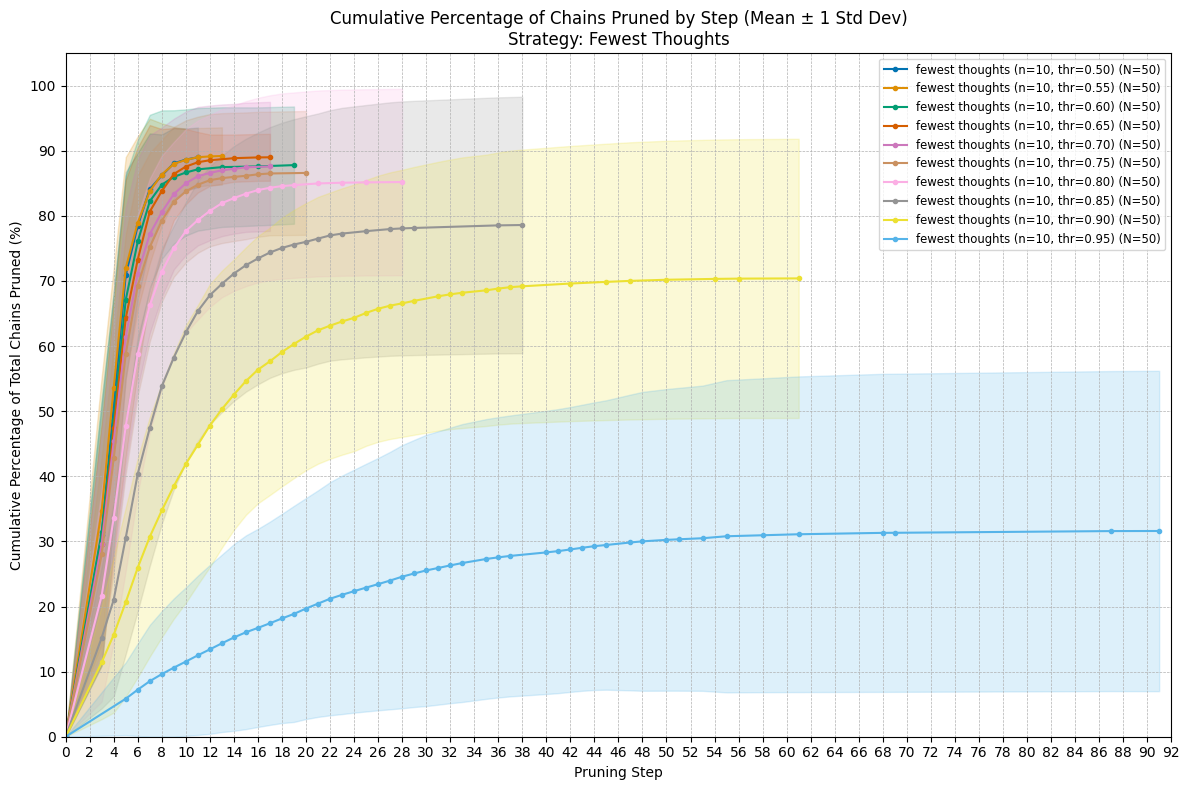


Generating plot for strategy: most_thoughts
  -> Calculated stats for 'most thoughts (n=10, thr=0.50)' (50 questions).
  -> Calculated stats for 'most thoughts (n=10, thr=0.55)' (50 questions).
  -> Calculated stats for 'most thoughts (n=10, thr=0.60)' (50 questions).
  -> Calculated stats for 'most thoughts (n=10, thr=0.65)' (50 questions).
  -> Calculated stats for 'most thoughts (n=10, thr=0.70)' (50 questions).
  -> Calculated stats for 'most thoughts (n=10, thr=0.75)' (50 questions).
  -> Calculated stats for 'most thoughts (n=10, thr=0.80)' (50 questions).
  -> Calculated stats for 'most thoughts (n=10, thr=0.85)' (50 questions).
  -> Calculated stats for 'most thoughts (n=10, thr=0.90)' (50 questions).
  -> Calculated stats for 'most thoughts (n=10, thr=0.95)' (50 questions).


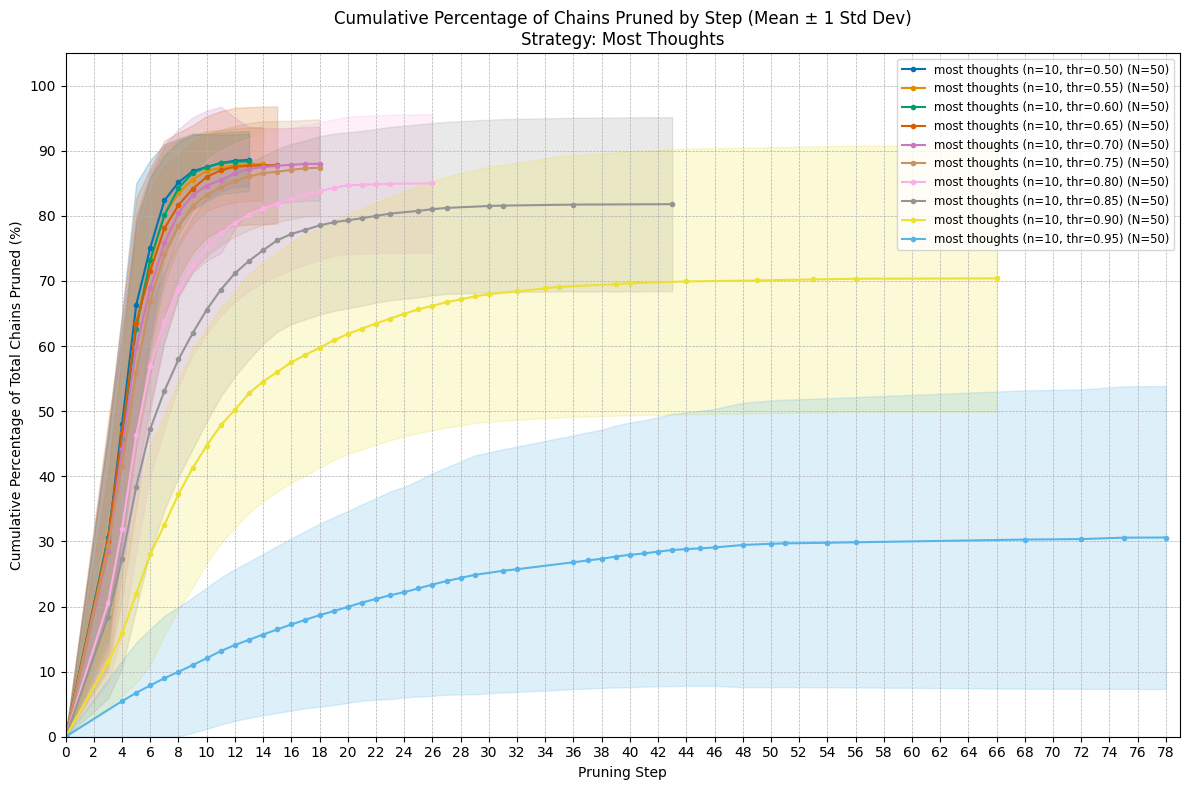


Generating plot for strategy: random
  -> Calculated stats for 'random (n=10, thr=0.55)' (50 questions).
  -> Calculated stats for 'random (n=10, thr=0.60)' (50 questions).
  -> Calculated stats for 'random (n=10, thr=0.65)' (50 questions).
  -> Calculated stats for 'random (n=10, thr=0.70)' (50 questions).
  -> Calculated stats for 'random (n=10, thr=0.75)' (50 questions).
  -> Calculated stats for 'random (n=10, thr=0.80)' (50 questions).
  -> Calculated stats for 'random (n=10, thr=0.85)' (50 questions).
  -> Calculated stats for 'random (n=10, thr=0.90)' (50 questions).
  -> Calculated stats for 'random (n=10, thr=0.95)' (50 questions).


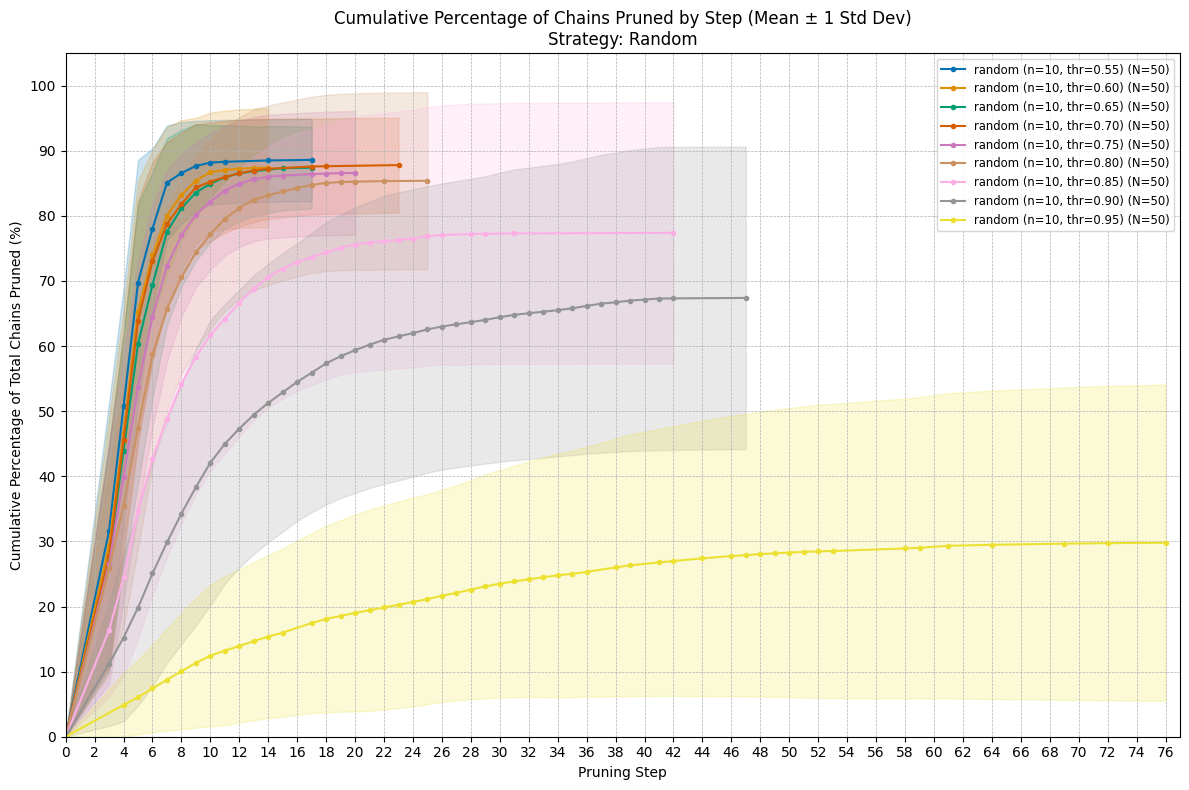


Finished processing all experiments and generating grouped plots with confidence bands.


In [3]:
import json
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter, defaultdict
import os
import re
from scipy import interpolate
import seaborn as sns

import re

# --- Helper Function to Parse Experiment Name ---
def parse_experiment_name(dir_name):
    """
    Parses the experiment directory name to extract strategy and parameters.
    Returns a tuple: (strategy_key, label) or (None, None) if parsing fails.
    """
    if not dir_name:
        print(f"  -> Warning: Empty directory name provided.")
        return None, None

    # Find parameters using regex
    n_match = re.search(r'_n(\d+)', dir_name)
    thresh_match = re.search(r'_thresh([\d.]+)', dir_name)
    max_active_match = re.search(r'_max_active(\d+)', dir_name)
    
    # Determine the start index of the first parameter found
    first_param_start_index = len(dir_name)
    if n_match:
        first_param_start_index = min(first_param_start_index, n_match.start())
    if thresh_match:
        first_param_start_index = min(first_param_start_index, thresh_match.start())
    if max_active_match:
        first_param_start_index = min(first_param_start_index, max_active_match.start())
        
    # The strategy name is the part of dir_name before the first parameter
    # If dir_name starts with a parameter, strategy_name part would be empty.
    if first_param_start_index == 0 and (n_match or thresh_match or max_active_match):
        print(f"  -> Warning: Directory name '{dir_name}' starts with a parameter, cannot determine strategy name.")
        return None, None
    
    strategy_name = dir_name[:first_param_start_index]
    
    # Collect parts for the label
    params_label_parts = []
    if n_match:
        params_label_parts.append(f"n={n_match.group(1)}")
    if thresh_match:
        params_label_parts.append(f"thr={thresh_match.group(1)}")
    if max_active_match:
        params_label_parts.append(f"max_act={max_active_match.group(1)}")

    # Construct the label
    label_base = strategy_name.replace('_', ' ')
    if params_label_parts:
        label = f"{label_base} ({', '.join(params_label_parts)})"
    else:
        label = label_base
    
    # Map the parsed strategy_name to a canonical strategy_key
    temp_strategy_name_lower = strategy_name.lower()
    strategy_key = strategy_name  # Default if no specific mapping rule applies

    if 'diversity' in temp_strategy_name_lower:
        strategy_key = 'diversity'
    elif 'most_thoughts' in temp_strategy_name_lower:
        strategy_key = 'most_thoughts'
    elif 'fewest_thoughts' in temp_strategy_name_lower:
        strategy_key = 'fewest_thoughts'
    elif 'random' in temp_strategy_name_lower:
        strategy_key = 'random'
    elif 'sc' in temp_strategy_name_lower:  # Handles 'sc', 'sc_complex', etc.
        strategy_key = 'sc'
    elif temp_strategy_name_lower == 'baseline':
        strategy_key = 'baseline'
    # Add other specific strategy keywords as needed

    # Handle cases considered unparseable:
    # If no parameters were found, and the strategy_name (which is the full dir_name)
    # doesn't map to a known, simplified key, it's likely an unrecognized format.
    if not params_label_parts:
        known_mapped_simple_keys = {'diversity', 'most_thoughts', 'fewest_thoughts', 'random', 'sc', 'baseline'}
        # If strategy_key is still the original strategy_name (no specific rule applied)
        # AND this name is not one of the simple, known strategies.
        if strategy_key == strategy_name and strategy_name not in known_mapped_simple_keys:
            print(f"  -> Warning: Could not parse strategy from directory name (unrecognized format without parameters): {dir_name}")
            return None, None
            
    return strategy_key, label


# --- Main Script ---

# Define the base directory containing the experiment results
notebook_dir = Path(os.getcwd()) # Assumes notebook is in slimsc/prune/plots/
base_results_dir = notebook_dir.parent / "results" / "R1-Distill-Qwen-14B" / "gpqa_diamond"
# Or define an absolute path:
# base_results_dir = Path("/path/to/your/slimsc/prune/results/R1-Distill-Qwen-14B/gpqa_diamond")

print(f"Base results directory: {base_results_dir}")

# Dictionary to hold data grouped by strategy
# Structure: { 'strategy_key': { 'experiment_label': {'per_question_raw': [...], 'details': {...} }, ... }, ... }
grouped_experiment_data = defaultdict(lambda: defaultdict(lambda: {'per_question_raw': [], 'details': {}}))
max_step_overall = 0 # Keep track of the max step across all experiments

if not base_results_dir.is_dir():
    print(f"ERROR: Base results directory not found at {base_results_dir}")
else:
    # --- Data Aggregation Phase ---
    print("\n--- Aggregating data from experiments ---")
    for experiment_dir in sorted(base_results_dir.iterdir()):
        if experiment_dir.is_dir():
            experiment_name = experiment_dir.name
            
            strategy, label = parse_experiment_name(experiment_name)
            if strategy is None:
                continue 

            print(f"\nProcessing experiment: {experiment_name} (Strategy: {strategy}, Label: {label})")
            summaries_dir = experiment_dir / "summaries"

            if not summaries_dir.is_dir():
                print(f"  -> Summaries directory not found: {summaries_dir}")
                continue

            experiment_question_data = [] # Store raw data per question for this experiment
            experiment_all_pruned_steps_union = set() # Unique steps across all questions in this experiment
            experiment_max_step = 0 # Max step within this experiment

            json_files_found = list(summaries_dir.glob("question_*_summary.json"))
            if not json_files_found:
                print(f"  -> No question summary JSON files found in {summaries_dir}")
                continue
                
            processed_files_count = 0
            for json_file in json_files_found:
                try:
                    with open(json_file, 'r') as f:
                        data = json.load(f)

                    n_start = data.get("n_chains_start", 0)
                    if n_start <= 0:
                        # print(f"  -> Skipping {json_file.name}, n_chains_start={n_start}")
                        continue
                        
                    processed_files_count += 1
                    question_pruned_steps = []
                    if "pruned_chain_details" in data:
                        for chain in data["pruned_chain_details"]:
                            if "pruned_at_step" in chain:
                                step = chain["pruned_at_step"]
                                question_pruned_steps.append(step)
                                experiment_all_pruned_steps_union.add(step)
                                experiment_max_step = max(experiment_max_step, step)
                                max_step_overall = max(max_step_overall, step) # Update global max step

                    # Store raw data needed for later CDF calculation per question
                    experiment_question_data.append({
                        'n_start': n_start,
                        'pruned_steps': question_pruned_steps
                    })

                except json.JSONDecodeError:
                    print(f"  -> Error decoding JSON from {json_file.name}")
                except Exception as e:
                    print(f"  -> Error processing file {json_file.name}: {e}")

            if not experiment_question_data:
                 print(f"  -> No valid question data found for experiment {experiment_name}.")
                 continue
                 
            print(f"  -> Processed {processed_files_count} valid summary files.")
            # Store collected data
            grouped_experiment_data[strategy][label]['per_question_raw'] = experiment_question_data
            grouped_experiment_data[strategy][label]['details']['all_steps_union'] = sorted(list(experiment_all_pruned_steps_union))
            grouped_experiment_data[strategy][label]['details']['max_step'] = experiment_max_step
            grouped_experiment_data[strategy][label]['details']['num_questions'] = len(experiment_question_data)
            print(f"  -> Stored data for {len(experiment_question_data)} questions. Max step in exp: {experiment_max_step}")


    # --- Calculation and Plotting Phase ---
    print("\n--- Calculating Statistics and Generating Plots ---")

    for strategy, experiments in grouped_experiment_data.items():
        print(f"\nGenerating plot for strategy: {strategy}")
        
        # Sort experiments by label for consistent plotting order
        sorted_experiment_labels = sorted(experiments.keys())
        
        if not sorted_experiment_labels:
            print(f"  -> No experiments found for strategy '{strategy}'. Skipping.")
            continue

        plt.figure(figsize=(12, 8)) # Slightly larger figure
        group_max_step = 0 # Find max step across all experiments *within this group*
        
        # --- Calculate Aggregated CDFs with Confidence Bands ---
        for label in sorted_experiment_labels:
            exp_data = experiments[label]
            question_raw_data = exp_data['per_question_raw']
            details = exp_data['details']
            
            num_questions = details['num_questions']
            if num_questions == 0:
                print(f"  -> Skipping '{label}': No question data.")
                continue
                
            # Use union of steps within the experiment as the common grid. Add 0.
            # If no steps were recorded at all, use just step 0.
            common_steps = np.array([0] + details['all_steps_union'])
            current_exp_max_step = details['max_step']
            group_max_step = max(group_max_step, current_exp_max_step) # Update group max step

            # Matrix to store interpolated percentages [question, step]
            interpolated_percentages = np.zeros((num_questions, len(common_steps)))

            for i, q_data in enumerate(question_raw_data):
                n_start = q_data['n_start']
                pruned_steps = q_data['pruned_steps']

                if n_start == 0: # Should have been filtered, but double check
                    interpolated_percentages[i, :] = np.nan # Mark as NaN if no chains started
                    continue

                if not pruned_steps:
                    # If no chains were pruned, percentage is 0 at all steps
                    q_plot_steps = np.array([0, current_exp_max_step + 1]) # Define steps up to max
                    q_plot_percentages = np.array([0.0, 0.0])
                else:
                    # Calculate CDF for this specific question
                    step_counts = Counter(pruned_steps)
                    sorted_q_steps = sorted(step_counts.keys())
                    cumulative_counts = np.cumsum([step_counts[step] for step in sorted_q_steps])
                    cumulative_percentage = (cumulative_counts / n_start) * 100
                    
                    # Create step function points (add 0)
                    q_plot_steps = np.array([0] + sorted_q_steps)
                    q_plot_percentages = np.array([0.0] + list(cumulative_percentage))

                    # Ensure the step function extends to the maximum step observed if needed for interpolation later
                    # This might not be strictly necessary if interp handles boundaries correctly, but can be safer
                    if q_plot_steps[-1] < current_exp_max_step:
                         q_plot_steps = np.append(q_plot_steps, current_exp_max_step + 1) # Add a point beyond max
                         q_plot_percentages = np.append(q_plot_percentages, q_plot_percentages[-1]) # Maintain last percentage


                # Interpolate this question's CDF onto the common steps grid for the experiment
                # Using linear interpolation here. For strict step function, logic would be more complex.
                # 'interp1d' with kind='previous' or 'next' might be closer to step func, but linear is common.
                # Using np.interp is simpler and handles boundaries
                # We need to handle cases where q_plot_steps might be empty or have single value if interp fails
                if len(q_plot_steps) > 1:
                    interp_func = interpolate.interp1d(q_plot_steps, q_plot_percentages, kind='linear', bounds_error=False, fill_value=(q_plot_percentages[0], q_plot_percentages[-1]))
                    interpolated_percentages[i, :] = interp_func(common_steps)
                    # Clamp values just in case interpolation goes slightly out of [0, 100] range due to floats
                    interpolated_percentages[i, :] = np.clip(interpolated_percentages[i, :], 0, 100)
                elif len(q_plot_steps) == 1: # Only step 0 (e.g. only unpruned)
                    interpolated_percentages[i, :] = q_plot_percentages[0] # Should be 0
                else: # No steps, likely already handled (n_start=0 or no pruned steps)
                     interpolated_percentages[i, :] = 0.0


            # --- Calculate Mean and Standard Deviation ---
            # Use nanmean/nanstd if we allowed NaNs earlier, otherwise mean/std is fine
            mean_percentages = np.mean(interpolated_percentages, axis=0)
            std_dev_percentages = np.std(interpolated_percentages, axis=0)
            
            # Define bands (e.g., Mean +/- 1 Std Dev)
            lower_band = np.maximum(0, mean_percentages - std_dev_percentages) # Don't go below 0%
            upper_band = np.minimum(100, mean_percentages + std_dev_percentages) # Don't exceed 100%

            # Store calculated stats for plotting
            exp_data['stats'] = {
                'common_steps': common_steps,
                'mean': mean_percentages,
                'lower': lower_band,
                'upper': upper_band,
                'num_questions': num_questions # Store count for potential annotation
            }
            print(f"  -> Calculated stats for '{label}' ({num_questions} questions).")

        # --- Plotting with Confidence Bands ---
        # colors = plt.cm.tab10(np.linspace(0, 1, len(sorted_experiment_labels))) # Get distinct colors
        colors = sns.color_palette('colorblind', n_colors=len(sorted_experiment_labels))

        for i, label in enumerate(sorted_experiment_labels):
            if 'stats' not in experiments[label]:
                continue # Skip if stats calculation failed

            stats = experiments[label]['stats']
            common_steps = stats['common_steps']
            mean_line = stats['mean']
            lower_band = stats['lower']
            upper_band = stats['upper']
            num_q = stats['num_questions']
            
            color = colors[i]
            
            # Plot the mean line
            line, = plt.plot(common_steps, mean_line, marker='.', linestyle='-', label=f"{label} (N={num_q})", color=color)
            
            # Add the confidence band using fill_between
            # Check if there's actually variance to plot band
            if np.any(upper_band > lower_band) and num_q > 1: # Only plot band if std dev > 0 and more than 1 question
                 plt.fill_between(common_steps, lower_band, upper_band, alpha=0.2, color=line.get_color())
            elif num_q <= 1:
                 print(f"  -> Note: Confidence band not shown for '{label}' (only {num_q} question(s)).")


        # --- Final Plot Setup ---
        plt.title(f"Cumulative Percentage of Chains Pruned by Step (Mean ± 1 Std Dev)\nStrategy: {strategy.replace('_', ' ').title()}")
        plt.xlabel("Pruning Step")
        plt.ylabel("Cumulative Percentage of Total Chains Pruned (%)")
        plt.ylim(0, 105) 
        plt.xlim(left=0, right=max(10, group_max_step + 1)) # Use max step from the group
        plt.grid(True, which='both', linestyle='--', linewidth=0.5)
        
        tick_step = 2
        plt.xticks(np.arange(0, group_max_step + 2, step=tick_step))
        plt.yticks(np.arange(0, 101, 10))

        plt.legend(loc='best', fontsize='small') # Adjust legend location if needed
        
        plt.tight_layout()
        plt.show()

print("\nFinished processing all experiments and generating grouped plots with confidence bands.")

In [2]:
# Cell 1: Setup and Imports

import os
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re
from pathlib import Path
from typing import Dict, List, Optional, Any

# Define the base results directory
# Adjust this path if your notebook is located elsewhere relative to the 'results' folder
# Assumes notebook is in slimsc/prune/plots/
# and results are in slimsc/prune/results/
notebook_dir = Path(os.getcwd()) 
results_base_dir = notebook_dir.parent / "results" 

# plots_save_dir is the directory where the notebook is located
plots_save_dir = notebook_dir 

print(f"Notebook directory: {notebook_dir}")
print(f"Scanning for results in: {results_base_dir.resolve()}") # Show resolved path
print(f"Plots will be saved in: {plots_save_dir.resolve()}") # Show resolved path

if not results_base_dir.is_dir():
    print(f"ERROR: Results base directory not found at {results_base_dir.resolve()}")
else:
    print("Results base directory found.")
    
if not plots_save_dir.is_dir():
     print(f"WARNING: Plots save directory not found at {plots_save_dir.resolve()}")
     print("Attempting to create it...")
     try:
         plots_save_dir.mkdir(parents=True, exist_ok=True)
         print("Plots save directory created.")
     except Exception as e:
         print(f"ERROR: Failed to create plots save directory: {e}")
         plots_save_dir = None # Indicate saving is not possible

# Optional: Configure matplotlib for better display in notebooks
%matplotlib inline 
%config InlineBackend.figure_format = 'retina' # For higher resolution plots

Notebook directory: /home/users/ntu/chong032/slimsc/prune/visualization
Scanning for results in: /home/users/ntu/chong032/slimsc/prune/results
Plots will be saved in: /home/users/ntu/chong032/slimsc/prune/visualization
Results base directory found.


In [20]:
# Cell 2: Define collect_metrics_data function

import numpy.random as npr # Keep npr if needed elsewhere
import random # Import the random module

def collect_metrics_data(results_dir_path: Path) -> pd.DataFrame:
    """
    Scans the results directory and collects metrics.
    For sc_control methods, metrics are calculated from a specific sample of 50 
    iterations (sampled from 1-198 with seed 4).
    For other methods, metrics are read from aggregated_metrics.json if available.
    
    Args:
        results_dir_path: Path to the results directory (as a Path object)
        
    Returns:
        DataFrame containing all metrics with model, dataset, and strategy information
    """
    data_rows = []
    
    print(f"Scanning directory for metrics: {results_dir_path}")
    
    if not results_dir_path.is_dir():
        print(f"Error: Results directory not found at {results_dir_path}")
        return pd.DataFrame()

    # --- Define and Generate the Target Sampled Iterations ---
    sampling_seed = 4
    sample_size = 50
    total_possible_iterations = 198 # The full range of questions available

    random.seed(sampling_seed) 
    all_possible_iterations = list(range(1, total_possible_iterations + 1))
    
    # Shuffle and slice to get the sampled iterations
    # We shuffle the full list (1-198) and take the first 50
    random.shuffle(all_possible_iterations)
    target_sampled_iterations = sorted(all_possible_iterations[:sample_size]) # Sort for consistency

    print(f"\n--- Target Sampled Iterations (N={sample_size}, Seed={sampling_seed}, from 1-{total_possible_iterations}): ---")
    print(target_sampled_iterations)
    print("----------------------------------------------------\n")

    # rng = npr.RandomState(sampling_seed) # Remove npr RandomState if using random module

    # Walk through the directory structure
    for model_dir in sorted(results_dir_path.iterdir()):
        if not model_dir.is_dir():
            continue
            
        model_name = model_dir.name

        for dataset_dir in sorted(model_dir.iterdir()):
            if not dataset_dir.is_dir():
                continue
                
            dataset_name = dataset_dir.name
            
            for strategy_dir in sorted(dataset_dir.iterdir()):
                if not strategy_dir.is_dir():
                    continue
                    
                strategy_name = strategy_dir.name
                metrics_file = strategy_dir / "aggregated_metrics.json"
                summaries_dir = strategy_dir / "summaries"
                
                # Determine pruning method (keep this logic consistent)
                pruning_method = 'unknown'
                if 'fewest' in strategy_name.lower():
                    pruning_method = 'fewest_thoughts'
                elif 'most' in strategy_name.lower():
                    pruning_method = 'most_thoughts'
                elif 'diversity' in strategy_name.lower():
                    pruning_method = 'diversity'
                elif 'random' in strategy_name.lower():
                    pruning_method = 'random'
                elif 'sc_' in strategy_name.lower():
                    sc_match = re.search(r'sc_(\d+)', strategy_name.lower())
                    if sc_match:
                        pruning_method = f'sc_control_{sc_match.group(1)}'
                    else:
                        pruning_method = 'sc_control' # Generic label
                elif 'baseline' in strategy_name.lower():
                     pruning_method = 'baseline'
                
                # Parse threshold if present
                threshold = np.nan
                threshold_match = re.search(r'thresh(\d+\.?\d*)', strategy_name)
                if threshold_match:
                    try: threshold = float(threshold_match.group(1))
                    except ValueError: pass
                else:
                    threshold_match_end = re.search(r'_(\d+\.?\d*)$', strategy_name)
                    if threshold_match_end:
                         try: threshold = float(threshold_match_end.group(1))
                         except ValueError: pass


                row = {
                    'model': model_name,
                    'dataset': dataset_name,
                    'strategy': strategy_name,
                    'strategy_path': str(strategy_dir),
                    'pruning_method': pruning_method,
                    'threshold': threshold 
                }

                # --- Special Handling for SC Control Methods ---
                if pruning_method.startswith('sc_control') and summaries_dir.is_dir():
                    print(f"    Processing SC Control (using specific sample): {model_name}/{dataset_name}/{strategy_name}")
                    
                    # --- MODIFICATION START: Collect metrics ONLY from the target sampled iterations ---
                    sampled_accuracies = []
                    sampled_completion_tokens = []
                    sampled_kv_cache = []
                    sampled_processing_times = []
                    sampled_chains_completed_voting_perc = []
                    
                    actually_found_iterations = [] # To count how many of the target were found

                    for iter_num in target_sampled_iterations:
                        json_filename = f"question_{iter_num}_summary.json"
                        json_file_path = summaries_dir / json_filename

                        if json_file_path.exists():
                            actually_found_iterations.append(iter_num)
                            try:
                                with open(json_file_path, 'r') as f:
                                    data = json.load(f)

                                # Extract metrics - handle missing keys gracefully
                                sampled_accuracies.append(data.get("final_score", np.nan))

                                completion_tokens = data.get("usage_aggregated", {}).get("total_completion_tokens_across_all_requested_chains")
                                if completion_tokens is None:
                                     completion_tokens = data.get("total_completion_tokens") # Fallback
                                sampled_completion_tokens.append(completion_tokens if completion_tokens is not None else np.nan)

                                sampled_kv_cache.append(data.get("max_kv_cache_usage", np.nan))
                                sampled_processing_times.append(data.get("processing_duration_sec", np.nan))

                                n_start = data.get("n_chains_requested", data.get("n_chains_start", 0))
                                n_completed_voting = data.get("n_chains_completed_stream_for_voting", len(data.get("chains_for_voting_details", [])))
                                
                                if n_start > 0:
                                     sampled_chains_completed_voting_perc.append((n_completed_voting / n_start) * 100)
                                else:
                                     sampled_chains_completed_voting_perc.append(np.nan)


                            except json.JSONDecodeError:
                                print(f"    Error decoding JSON from {json_filename}.")
                            except Exception as e:
                                print(f"    Error processing file {json_filename}: {e}")
                        else:
                             # print(f"    Warning: Target sample file not found: {json_filename}") # Optional debug
                             pass # The file simply wasn't in this directory

                    # Print which of the target iterations were actually found
                    if actually_found_iterations:
                         print(f"    Found and used {len(actually_found_iterations)} of the {sample_size} target iterations: {actually_found_iterations}")
                    else:
                         print(f"    Warning: None of the {sample_size} target iterations were found in this directory's summaries.")
                         
                    # Calculate mean metrics over the found sampled questions (ignoring NaNs)
                    row['overall_accuracy'] = np.nanmean(sampled_accuracies)
                    row['mean_total_completion_tokens_per_question'] = np.nanmean(sampled_completion_tokens)
                    
                    max_kv = np.nanmax(sampled_kv_cache)
                    row['max_max_kv_cache_usage_across_all_questions_perc'] = max_kv * 100 if np.isfinite(max_kv) else np.nan 
                    row['mean_max_kv_cache_usage_per_question_perc'] = max_kv * 100 if np.isfinite(max_kv) else np.nan 
                    
                    row['mean_processing_duration_sec_per_question'] = np.nanmean(sampled_processing_times)

                    row['mean_chains_completed_stream_for_voting_per_question'] = np.nanmean(sampled_chains_completed_voting_perc)

                    # Add count of found/used questions
                    row['sampled_question_count'] = len([x for x in sampled_accuracies if not np.isnan(x)]) 

                    data_rows.append(row)
                    # --- MODIFICATION END ---

                # --- Default Handling (Not SC Control) ---
                elif metrics_file.exists():
                    print(f"    Reading aggregated metrics: {model_name}/{dataset_name}/{strategy_name}")
                    try:
                        with open(metrics_file, 'r') as f:
                            metrics_data = json.load(f)
                        
                        acc_value = metrics_data.get('metrics', {}).get('overall_accuracy')
                        if acc_value is None:
                             acc_value = metrics_data.get('overall_accuracy') 
                        
                        if isinstance(acc_value, dict) and 'accuracy' in acc_value:
                             row['overall_accuracy'] = float(acc_value['accuracy'])
                        elif pd.notna(acc_value): 
                             try: row['overall_accuracy'] = float(acc_value)
                             except (ValueError, TypeError): row['overall_accuracy'] = np.nan
                        else:
                             row['overall_accuracy'] = np.nan


                        metrics_to_extract = {
                            'mean_total_completion_tokens_per_question',
                            'mean_max_kv_cache_usage_per_question_perc',
                            'max_max_kv_cache_usage_across_all_questions_perc',
                            'mean_processing_duration_sec_per_question',
                            'mean_chains_pruned_perc_per_question', 
                            'mean_chains_completed_stream_for_voting_per_question' 
                        }
                        
                        for metric_key in metrics_to_extract:
                            metric_value = metrics_data.get('metrics', {}).get(metric_key)
                            if metric_value is None:
                                 metric_value = metrics_data.get(metric_key)

                            if pd.notna(metric_value): 
                                try:
                                    if isinstance(metric_value, dict) and ('mean' in metric_value or 'value' in metric_value): 
                                         row[metric_key] = float(metric_value.get('mean', metric_value.get('value')))
                                    else:
                                         row[metric_key] = float(metric_value)
                                except (ValueError, TypeError):
                                    print(f"    Warning: Could not convert metric '{metric_key}' to float in {metrics_file}")
                                    row[metric_key] = np.nan
                            else:
                                row[metric_key] = np.nan 


                        top_level_keys_to_include = {
                            'n_chains_start': int, 
                            'n_chains_completed': int, 
                            'n_chains_pruned': int, 
                            'n_chains_error': int,
                            'similarity_threshold': float 
                        }
                        for key, dtype in top_level_keys_to_include.items():
                            if key in metrics_data:
                                try:
                                    row[key] = dtype(metrics_data[key])
                                except (ValueError, TypeError):
                                    print(f"    Warning: Could not convert top-level metric '{key}' to {dtype.__name__} in {metrics_file}")
                                    row[key] = np.nan 

                        data_rows.append(row)

                    except json.JSONDecodeError:
                        print(f"    Error decoding JSON from {metrics_file}")
                    except Exception as e:
                        print(f"    Error processing file {metrics_file}: {e}")

                else:
                    pass


    # Create DataFrame from collected data
    if data_rows:
        df = pd.DataFrame(data_rows)
        print(f"\nCollected data from {len(df)} strategy configurations.")
        
        metrics_to_numeric = [
            'overall_accuracy',
            'mean_total_completion_tokens_per_question',
            'mean_max_kv_cache_usage_per_question_perc',
            'max_max_kv_cache_usage_across_all_questions_perc',
            'mean_processing_duration_sec_per_question',
            'mean_chains_pruned_perc_per_question',
            'mean_chains_completed_stream_for_voting_per_question' 
        ]
        for col in metrics_to_numeric:
             if col in df.columns:
                  df[col] = pd.to_numeric(df[col], errors='coerce') 

        df['threshold'] = pd.to_numeric(df['threshold'], errors='coerce')

        return df
    else:
        print("\nNo metrics data found with aggregated_metrics.json files or SC summaries.")
        return pd.DataFrame()

In [21]:
# Cell 3: Define save_metrics_data function

def save_metrics_data(df: pd.DataFrame, output_file: str = "metrics_summary.csv", save_dir: Optional[Path] = None) -> None:
    """
    Saves the collected metrics data to a CSV file.
    
    Args:
        df: DataFrame containing the metrics data
        output_file: Base name for the CSV file
        save_dir: Optional directory path (as a Path object) to save the file.
                  If None, saves in the current working directory.
    """
    if df.empty:
        print("No data to save")
        return
        
    if save_dir:
        output_path = save_dir / output_file
        # Ensure the directory exists before saving
        output_path.parent.mkdir(parents=True, exist_ok=True)
    else:
        output_path = Path(output_file) # Save in current working dir if no base path given

    try:
        df.to_csv(output_path, index=False)
        print(f"Metrics data saved to {output_path}")
    except Exception as e:
        print(f"Error saving data to {output_path}: {e}")

In [22]:
# Cell 4: Define Generic Plotting Function (plot_metric_vs_threshold)

def plot_metric_vs_threshold(df: pd.DataFrame, 
                             metric_col: str,
                             metric_label: str,
                             model_name: Optional[str] = None, 
                             dataset_name: Optional[str] = None,
                             save_base_dir: Optional[Path] = None,
                             plot_file_prefix: str = "metric") -> None:
    """
    Creates a plot showing a specified metric vs threshold for different pruning methods.
    Filters the data by model and dataset.
    
    Args:
        df: DataFrame containing the metrics data
        metric_col: The column name of the metric to plot on the y-axis.
        metric_label: The label for the y-axis (e.g., "Mean Completion Tokens").
        model_name: Optional filter for a specific model.
        dataset_name: Optional filter for a specific dataset.
        save_base_dir: Optional base directory path (as a Path object) to infer
                       a save path.
        plot_file_prefix: Prefix for the saved plot filename (e.g., "accuracy", "completion_tokens").
    """
    if df.empty:
        print(f"No data to plot {metric_label} vs Threshold for {model_name}/{dataset_name}.")
        return
    
    # Filter data if model or dataset specified
    plot_df = df.copy()
    if model_name:
        plot_df = plot_df[plot_df['model'] == model_name]
    if dataset_name:
        plot_df = plot_df[plot_df['dataset'] == dataset_name]
    
    if plot_df.empty:
        print(f"No data found for plotting {metric_label} vs Threshold after filtering for model='{model_name}', dataset='{dataset_name}'")
        return

    # Check for required columns
    required_cols = ['threshold', 'pruning_method', metric_col]
    if not all(col in plot_df.columns for col in required_cols):
        print(f"Missing required columns {required_cols} in filtered data for plotting {metric_label}.")
        print(f"Available columns: {plot_df.columns.tolist()}")
        return

    # Ensure metric and threshold (if not None) are numeric
    plot_df[metric_col] = pd.to_numeric(plot_df[metric_col], errors='coerce')
    plot_df['threshold'] = pd.to_numeric(plot_df['threshold'], errors='coerce')
    
    # Drop rows with missing metric values
    if plot_df[metric_col].isna().any():
        na_count = plot_df[metric_col].isna().sum()
        # print(f"Warning: Dropping {na_count} rows with missing '{metric_col}' values for {model_name}/{dataset_name}") # Verbose
        plot_df = plot_df.dropna(subset=[metric_col])

    if plot_df.empty:
        print(f"No data with valid '{metric_col}' values to plot for {model_name}/{dataset_name}.")
        return

    # Set up the plot
    plt.figure(figsize=(12, 8))
    
    # Separate methods that use a threshold from non-threshold methods
    threshold_methods = ['fewest_thoughts', 'most_thoughts', 'diversity', 'random']
    # Require threshold to be non-NaN for threshold methods
    similarity_df = plot_df[plot_df['pruning_method'].isin(threshold_methods)].dropna(subset=['threshold']) 

    # Non-threshold methods (baselines, SC control) - threshold can be NaN here
    non_threshold_df = plot_df[~plot_df['pruning_method'].isin(threshold_methods)]
    
    # Plot horizontal lines for non-threshold methods (SC control, baseline)
    non_threshold_methods_list = sorted(non_threshold_df['pruning_method'].unique()) # Sort for consistent color assignment
    # Get enough colors for non-threshold methods
    non_threshold_colors = plt.cm.tab10(np.linspace(0, 1, max(1, len(non_threshold_methods_list)))) 

    for i, method in enumerate(non_threshold_methods_list):
        method_df = non_threshold_df[non_threshold_df['pruning_method'] == method]
        if not method_df.empty:
            # If there are multiple entries for a non-threshold method, average the metric
            method_metric_mean = method_df[metric_col].mean()
            is_sc_control = method.startswith('sc_control') 

            if is_sc_control and metric_col != 'overall_accuracy':
                 # Skip plotting this horizontal line
                 # print(f"  Skipping plotting SC Control line '{method}' for {metric_label} plot.") # Optional debug
                 continue # Move to the next iteration of the loop

            color = non_threshold_colors[i]
            
            # Use the original strategy name for the label if unique, otherwise the method name
            unique_strategies = method_df['strategy'].unique()
            if len(unique_strategies) == 1:
                 label = f'{unique_strategies[0]}: {method_metric_mean:.2f}'
            else:
                 label = f'{method.replace("_", " ").title()} (N={len(method_df)}): {method_metric_mean:.2f}'
            
            plt.axhline(y=method_metric_mean, color=color, 
                       linestyle='--', label=label, alpha=0.7)


    # Plot threshold methods as lines
    if not similarity_df.empty:
        # Define colors for similarity methods (distinct from non-threshold colors if possible)
        sim_methods_list = ['fewest_thoughts', 'most_thoughts', 'diversity', 'random'] # Define order
        # Filter to only include methods actually present in the data
        sim_methods_present = [m for m in sim_methods_list if m in similarity_df['pruning_method'].unique()]
        # Get enough colors for similarity methods
        sim_colors = plt.cm.viridis(np.linspace(0, 1, max(1, len(sim_methods_present)))) 


        for i, method in enumerate(sim_methods_present):
            method_df = similarity_df[similarity_df['pruning_method'] == method]
            if not method_df.empty:
                # Group by threshold and calculate mean metric
                grouped = method_df.groupby('threshold')[metric_col].mean().reset_index()
                # Sort by threshold for proper line plot
                grouped = grouped.sort_values('threshold')
                
                # Format method name for display
                display_name = method.replace('_', ' ').title()
                
                # Refined Label
                label = f'{display_name} ({len(method_df)} configs)' # Indicate number of configs

                color = sim_colors[i]
                
                plt.plot(grouped['threshold'], grouped[metric_col], 
                        marker='o', linestyle='-', color=color, 
                        label=label)

    # Add labels and title
    model_title = f"Model: {model_name}" if model_name else "All Models"
    dataset_title = f"Dataset: {dataset_name}" if dataset_name else "All Datasets"
    plt.title(f'{metric_label} vs Threshold for Pruning Methods\n{model_title}, {dataset_title}')
    plt.xlabel('Threshold')
    plt.ylabel(metric_label)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(loc='best', fontsize='small')
    
    # --- Adjust X-axis (Threshold) ---
    # Find min/max threshold values from the similarity methods for x-axis range
    min_thresh = similarity_df['threshold'].min()
    max_thresh = similarity_df['threshold'].max()

    # Ensure thresholds are numeric before checking nan/inf
    min_thresh = pd.to_numeric(min_thresh, errors='coerce')
    max_thresh = pd.to_numeric(max_thresh, errors='coerce')

    if pd.notna(min_thresh) and pd.notna(max_thresh):
         # Add 5% padding to the range
         padding = (max_thresh - min_thresh) * 0.05
         plt.xlim(left=max(0, min_thresh - padding), right=max_thresh + padding) 
         
         # Set x-ticks with 0.02 interval
         # Start from the minimum threshold, go up to max + a little bit to ensure max is included
         x_ticks_start = min_thresh 
         x_ticks_end = max_thresh + 0.005 # Add small value to ensure max is included
         x_ticks = np.arange(x_ticks_start, x_ticks_end, 0.05)
         # Filter ticks to only include values >= 0
         x_ticks = x_ticks[x_ticks >= 0]
         plt.xticks(x_ticks)
    else:
         # If no threshold data, set default xlim and x_ticks
         plt.xlim(left=0, right=1.0) # Default range if no threshold data
         plt.xticks(np.arange(0, 1.01, 0.1))


    # --- Adjust Y-axis (Metric) ---
    # Find min/max metric values to set y-axis limits.
    # Exclude SC Control methods for non-accuracy plots.

    # Start with all relevant data points
    all_metrics_data = plot_df[metric_col].dropna()

    metrics_for_ylim = all_metrics_data # Default: use all data

    if metric_col != 'overall_accuracy':
        # If it's not the accuracy plot, exclude SC Control methods from Y-limit calculation
        
        # Find rows that are NOT SC control methods
        non_sc_control_data = plot_df[~plot_df['pruning_method'].str.startswith('sc_control')]
        
        # Get the metric values from these rows and drop NaNs
        metrics_for_ylim = non_sc_control_data[metric_col].dropna()

    # Now use metrics_for_ylim for calculating min/max
    if not metrics_for_ylim.empty:
        min_met = metrics_for_ylim.min()
        max_met = metrics_for_ylim.max()
        
        # Calculate range and add padding
        met_range = max_met - min_met
        # Add a minimum range if all values are the same
        if met_range == 0:
             # Add 10% or at least 1 unit if values are identical. Ensure y_upper > y_lower
             padding = max(abs(min_met) * 0.1, 1.0) 
             y_lower = min_met - padding/2
             y_upper = min_met + padding/2
        else:
            padding = met_range * 0.1 # 10% padding
            # Ensure y-axis starts sensibly (can start at 0 if appropriate for the metric)
            y_lower = min_met - padding
            y_upper = max_met + padding


        # Specific adjustments based on metric type if needed (keep these)
        if metric_col == 'overall_accuracy':
             y_lower = max(0.0, y_lower) # Accuracy doesn't go below 0
             y_upper = min(1.0, y_upper) # Accuracy doesn't exceed 1
        elif metric_col in ['mean_total_completion_tokens_per_question', 
                            'max_max_kv_cache_usage_across_all_questions_perc',
                            'mean_max_kv_cache_usage_per_question_perc',
                            'mean_processing_duration_sec_per_question',
                           'mean_chains_pruned_perc_per_question']: 
             y_lower = max(0.0, y_lower) # These metrics are non-negative
             if metric_col == 'max_max_kv_cache_usage_across_all_questions_perc':
                  y_upper = min(100.0, y_upper) # KV cache % doesn't exceed 100
             if metric_col == 'mean_max_kv_cache_usage_per_question_perc':
                  y_upper = min(100.0, y_upper) # KV cache % doesn't exceed 100
             if metric_col == 'mean_chains_pruned_perc_per_question':
                  y_upper = min(100.0, y_upper) # Chains pruned % doesn't exceed 100

        # Final check to ensure y_lower is strictly less than y_upper if possible
        if y_lower >= y_upper:
             y_upper = y_lower + 1 # Ensure at least a minimal range

        plt.ylim(y_lower, y_upper)

    else:
        # Handle case where metrics_for_ylim is empty (e.g., no relevant data found for plotting)
        print(f"  Warning: No relevant data found for setting Y-axis limits for {metric_label}. Using default limits.")
        # Let matplotlib decide or set a generic default
        # plt.ylim(0, 100) # Example default; letting matplotlib choose is often best here


    # Generate a filename based on metric, model, dataset, and base save directory
    plot_filename = f"{plot_file_prefix}_vs_threshold"
    if model_name: plot_filename += f"_{model_name}"
    if dataset_name: plot_filename += f"_{dataset_name}"
    plot_filename += ".png"
    
    # Use the provided save_base_dir (plots directory)
    if save_base_dir and save_base_dir.is_dir():
        plot_save_path = save_base_dir / plot_filename
        # Ensure the directory exists (should be handled in Cell 1, but double-check)
        plot_save_path.parent.mkdir(parents=True, exist_ok=True) 
    else:
         # Fallback if save_base_dir is invalid
         print("Error: Invalid save_base_dir provided. Saving plot to current working directory.")
         plot_save_path = Path(plot_filename) # Save in current working dir


    
    # Save the plot
    try:
        plt.tight_layout()
        plt.savefig(plot_save_path, dpi=300)
        print(f"  Plot saved to {plot_save_path.resolve()}") # Show resolved path
    except Exception as e:
        print(f"  Error saving plot to {plot_save_path.resolve()}: {e}")
    
    # Display the plot
    plt.show()

In [23]:
# Cell 5: Collect Metrics Data

# Check if the base results directory was found in Cell 1
if results_base_dir.is_dir():
    metrics_df = collect_metrics_data(results_base_dir)
    
    # Display collected data info (using display() for notebooks)
    print("\n--- Collected Metrics Data Summary ---")
    print(f"DataFrame shape: {metrics_df.shape}")
    if not metrics_df.empty:
        print("First 5 rows:")
        display(metrics_df.head()) 
        print("\nColumns:", metrics_df.columns.tolist())
        print("\nInfo:")
        metrics_df.info()
        
        # Optional: Look at unique models, datasets, methods, and thresholds
        print("\nUnique Models:", metrics_df['model'].unique())
        print("Unique Datasets:", metrics_df['dataset'].unique())
        print("Unique Pruning Methods:", metrics_df['pruning_method'].unique())
        
        # Display unique thresholds for threshold-based methods
        threshold_methods = ['fewest_thoughts', 'most_thoughts', 'diversity', 'random']
        threshold_data = metrics_df[metrics_df['pruning_method'].isin(threshold_methods)]
        if not threshold_data.empty:
             print("Unique Thresholds for threshold methods:", sorted(threshold_data['threshold'].dropna().unique()))

    else:
        print("DataFrame is empty. No data collected.")
else:
     metrics_df = pd.DataFrame() # Ensure df exists even if dir not found
     print("Cannot collect data, results directory not found in Cell 1.")

# Optional: Save the collected data to CSV
# if not metrics_df.empty and plots_save_dir and plots_save_dir.is_dir():
#     save_metrics_data(metrics_df, output_file="metrics_summary.csv", save_dir=plots_save_dir)

Scanning directory for metrics: /home/users/ntu/chong032/slimsc/prune/results

--- Target Sampled Iterations (N=50, Seed=4, from 1-198): ---
[1, 5, 9, 15, 17, 32, 34, 35, 39, 41, 44, 52, 58, 62, 63, 66, 73, 83, 84, 89, 101, 104, 105, 110, 112, 113, 114, 118, 120, 129, 135, 140, 142, 144, 146, 150, 153, 158, 162, 172, 177, 179, 180, 181, 188, 192, 193, 196, 197, 198]
----------------------------------------------------

    Reading aggregated metrics: R1-Distill-Qwen-14B/gpqa_diamond/diversity_n10_thresh0.50
    Reading aggregated metrics: R1-Distill-Qwen-14B/gpqa_diamond/diversity_n10_thresh0.55
    Reading aggregated metrics: R1-Distill-Qwen-14B/gpqa_diamond/diversity_n10_thresh0.60
    Reading aggregated metrics: R1-Distill-Qwen-14B/gpqa_diamond/diversity_n10_thresh0.65
    Reading aggregated metrics: R1-Distill-Qwen-14B/gpqa_diamond/diversity_n10_thresh0.70
    Reading aggregated metrics: R1-Distill-Qwen-14B/gpqa_diamond/diversity_n10_thresh0.75
    Reading aggregated metrics: R1-Di

model       dataset                  strategy  \
0  R1-Distill-Qwen-14B  gpqa_diamond  diversity_n10_thresh0.50   
1  R1-Distill-Qwen-14B  gpqa_diamond  diversity_n10_thresh0.55   
2  R1-Distill-Qwen-14B  gpqa_diamond  diversity_n10_thresh0.60   
3  R1-Distill-Qwen-14B  gpqa_diamond  diversity_n10_thresh0.65   
4  R1-Distill-Qwen-14B  gpqa_diamond  diversity_n10_thresh0.70   

                                       strategy_path pruning_method  \
0  /home/users/ntu/chong032/slimsc/prune/results/...      diversity   
1  /home/users/ntu/chong032/slimsc/prune/results/...      diversity   
2  /home/users/ntu/chong032/slimsc/prune/results/...      diversity   
3  /home/users/ntu/chong032/slimsc/prune/results/...      diversity   
4  /home/users/ntu/chong032/slimsc/prune/results/...      diversity   

   threshold  overall_accuracy  mean_total_completion_tokens_per_question  \
0       0.50              0.72                                   11006.34   
1       0.55              0.72                                   10657.70   
2       0.60              0.74                                   11214.88   
3       0.65              0.70                                   11323.00   
4       0.70              0.72                                   11665.62   

   mean_chains_pruned_perc_per_question  \
0                                   NaN   
1                                   NaN   
2                                   NaN   
3                                   NaN   
4                                   NaN   

   max_max_kv_cache_usage_across_all_questions_perc  \
0                                          0.062467   
1                                          0.099081   
2                                          0.072256   
3                                          0.085332   
4                                          0.068520   

   mean_processing_duration_sec_per_question  \
0                                 103.671782   
1                                 101.020283   
2                                 108.089680   
3                                 106.774262   
4                                 105.626310   

   mean_chains_completed_stream_for_voting_per_question  \
0                                               1.14      
1                                               1.04      
2                                               1.14      
3                                               1.16      
4                                               1.12      

   mean_max_kv_cache_usage_per_question_perc  sampled_question_count  
0                                   0.036493                     NaN  
1                                   0.040401                     NaN  
2                                   0.037329                     NaN  
3                                   0.040157                     NaN  
4                                   0.037790                     NaN


Columns: ['model', 'dataset', 'strategy', 'strategy_path', 'pruning_method', 'threshold', 'overall_accuracy', 'mean_total_completion_tokens_per_question', 'mean_chains_pruned_perc_per_question', 'max_max_kv_cache_usage_across_all_questions_perc', 'mean_processing_duration_sec_per_question', 'mean_chains_completed_stream_for_voting_per_question', 'mean_max_kv_cache_usage_per_question_perc', 'sampled_question_count']

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46 entries, 0 to 45
Data columns (total 14 columns):
 #   Column                                                Non-Null Count  Dtype  
---  ------                                                --------------  -----  
 0   model                                                 46 non-null     object 
 1   dataset                                               46 non-null     object 
 2   strategy                                              46 non-null     object 
 3   strategy_path                                     


--- Generating Plots per Model/Dataset ---

--- Generating plots for Model: R1-Distill-Qwen-14B, Dataset: gpqa_diamond ---

  Generating plot: Accuracy vs Threshold
  Plot saved to /home/users/ntu/chong032/slimsc/prune/visualization/accuracy_vs_threshold_R1-Distill-Qwen-14B_gpqa_diamond.png


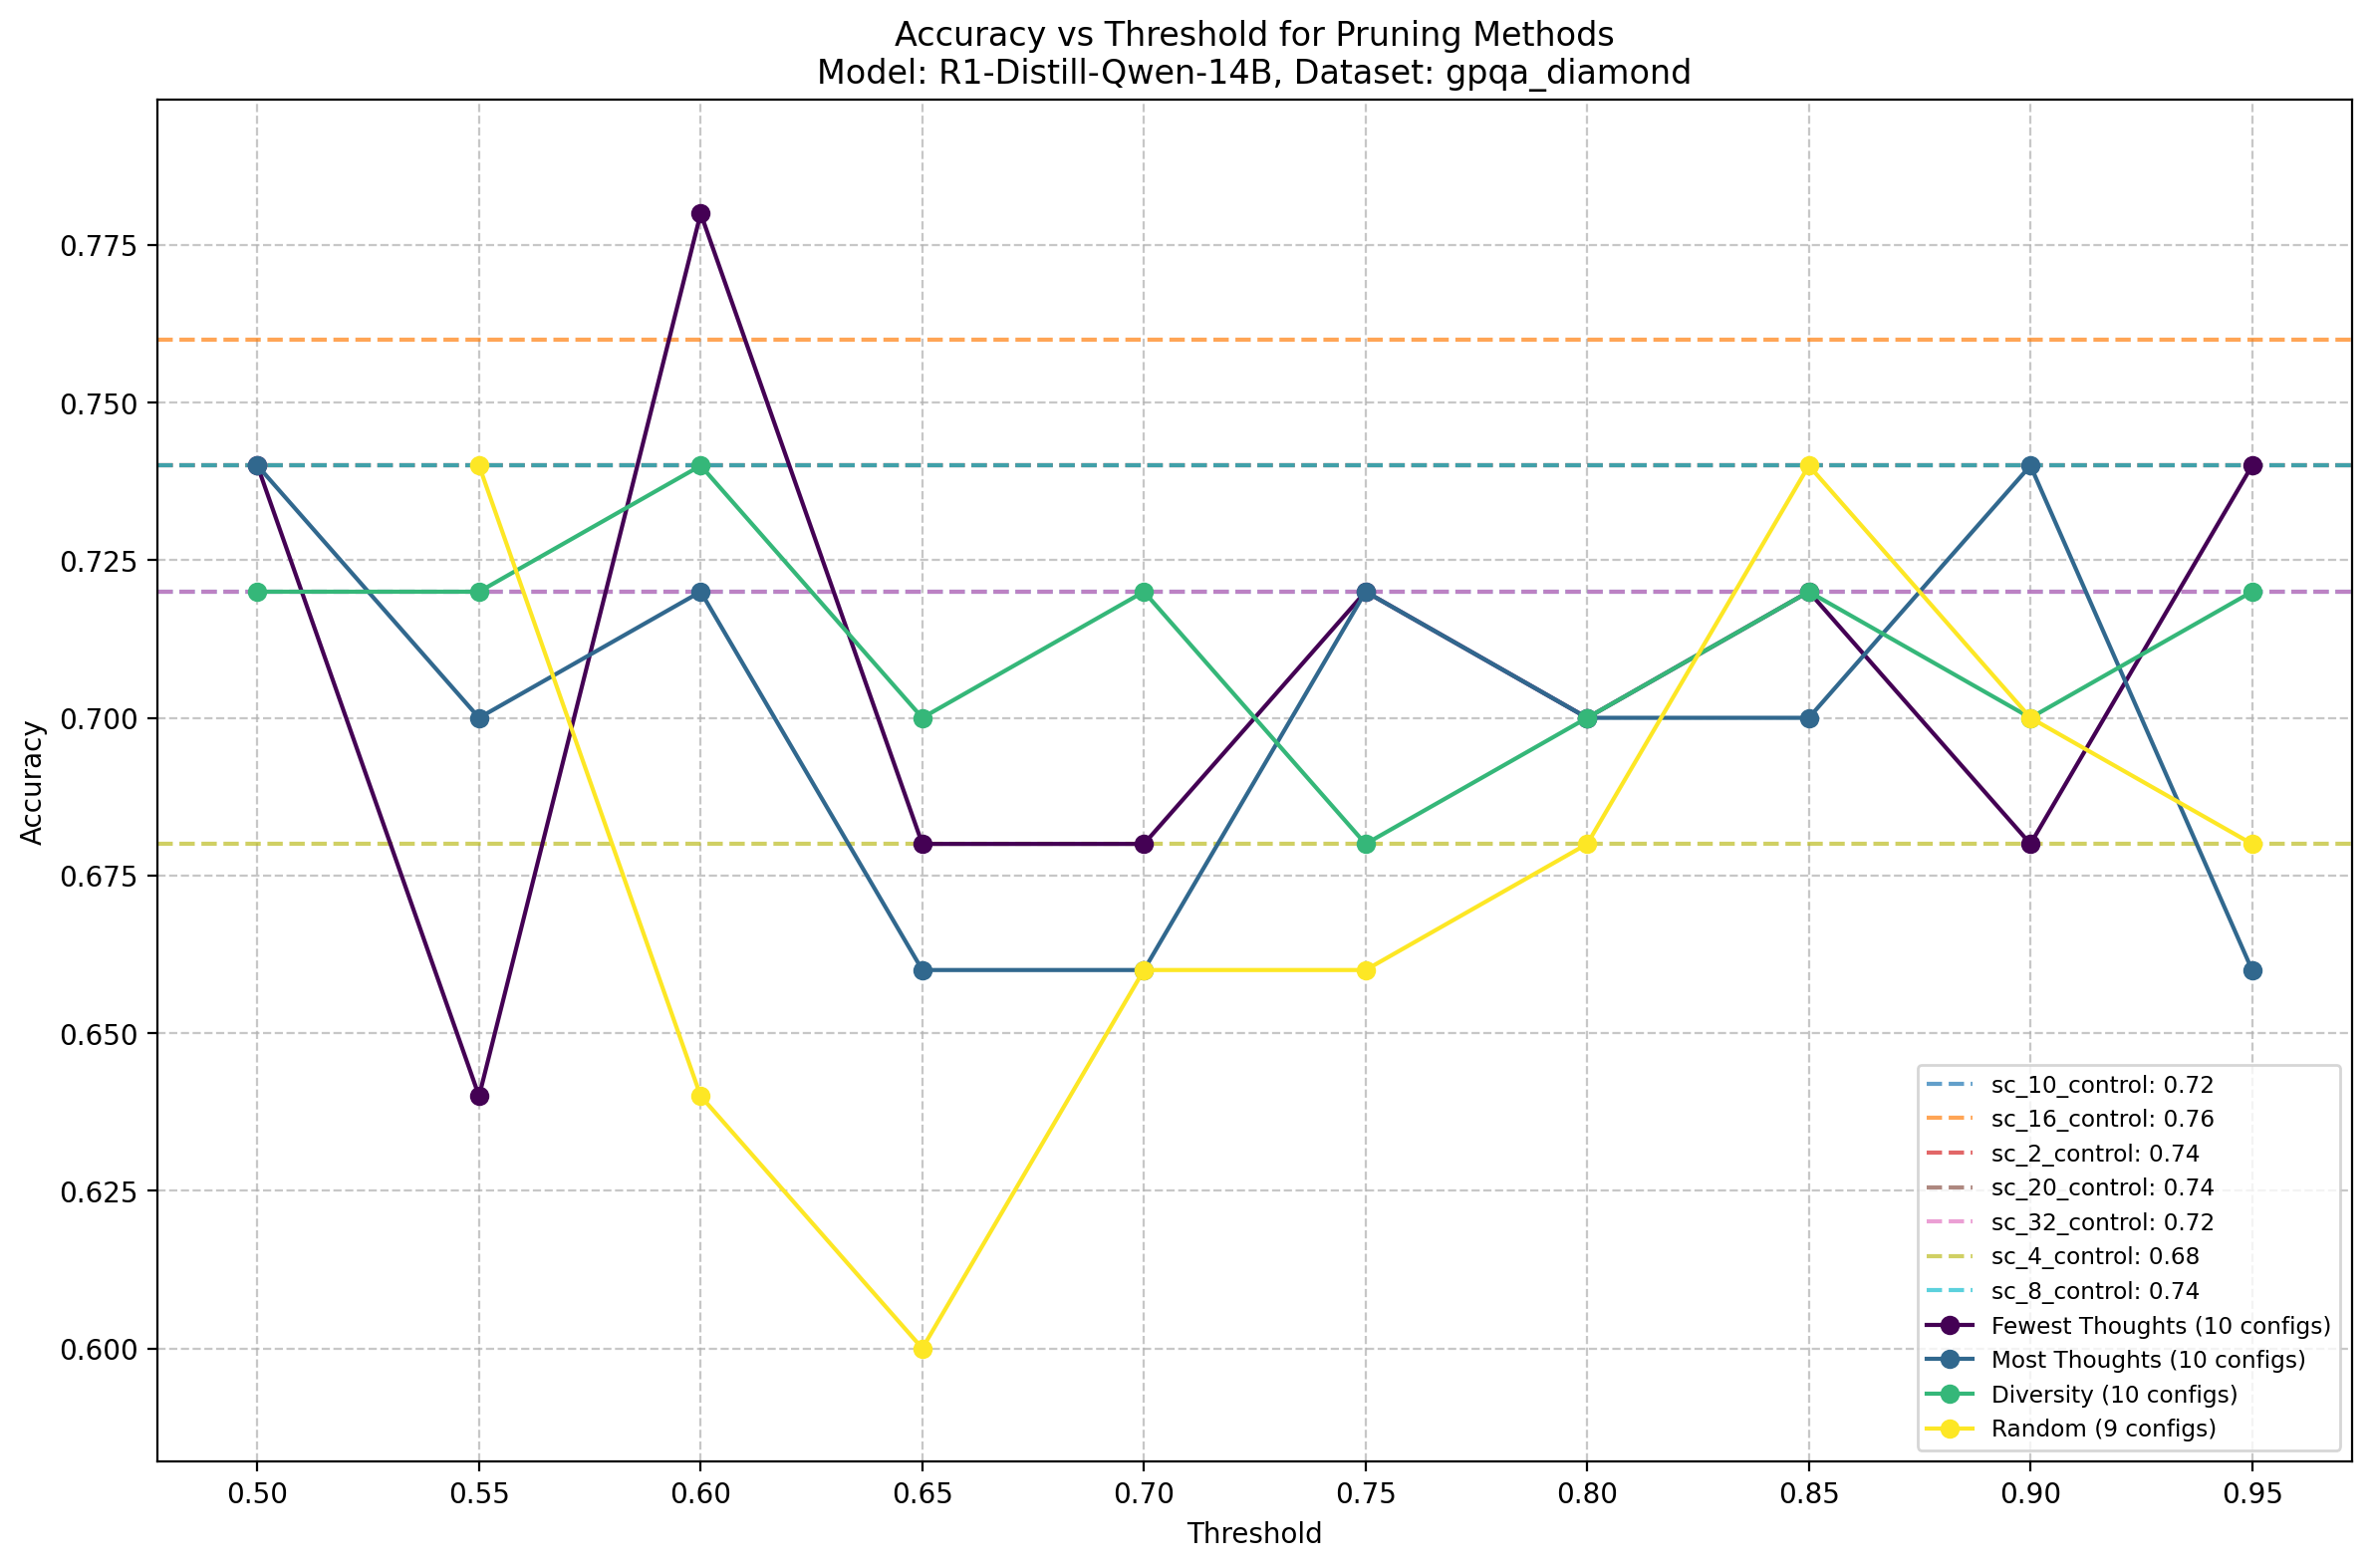


  Generating plot: Mean Completion Tokens vs Threshold
  Plot saved to /home/users/ntu/chong032/slimsc/prune/visualization/completion_tokens_vs_threshold_R1-Distill-Qwen-14B_gpqa_diamond.png


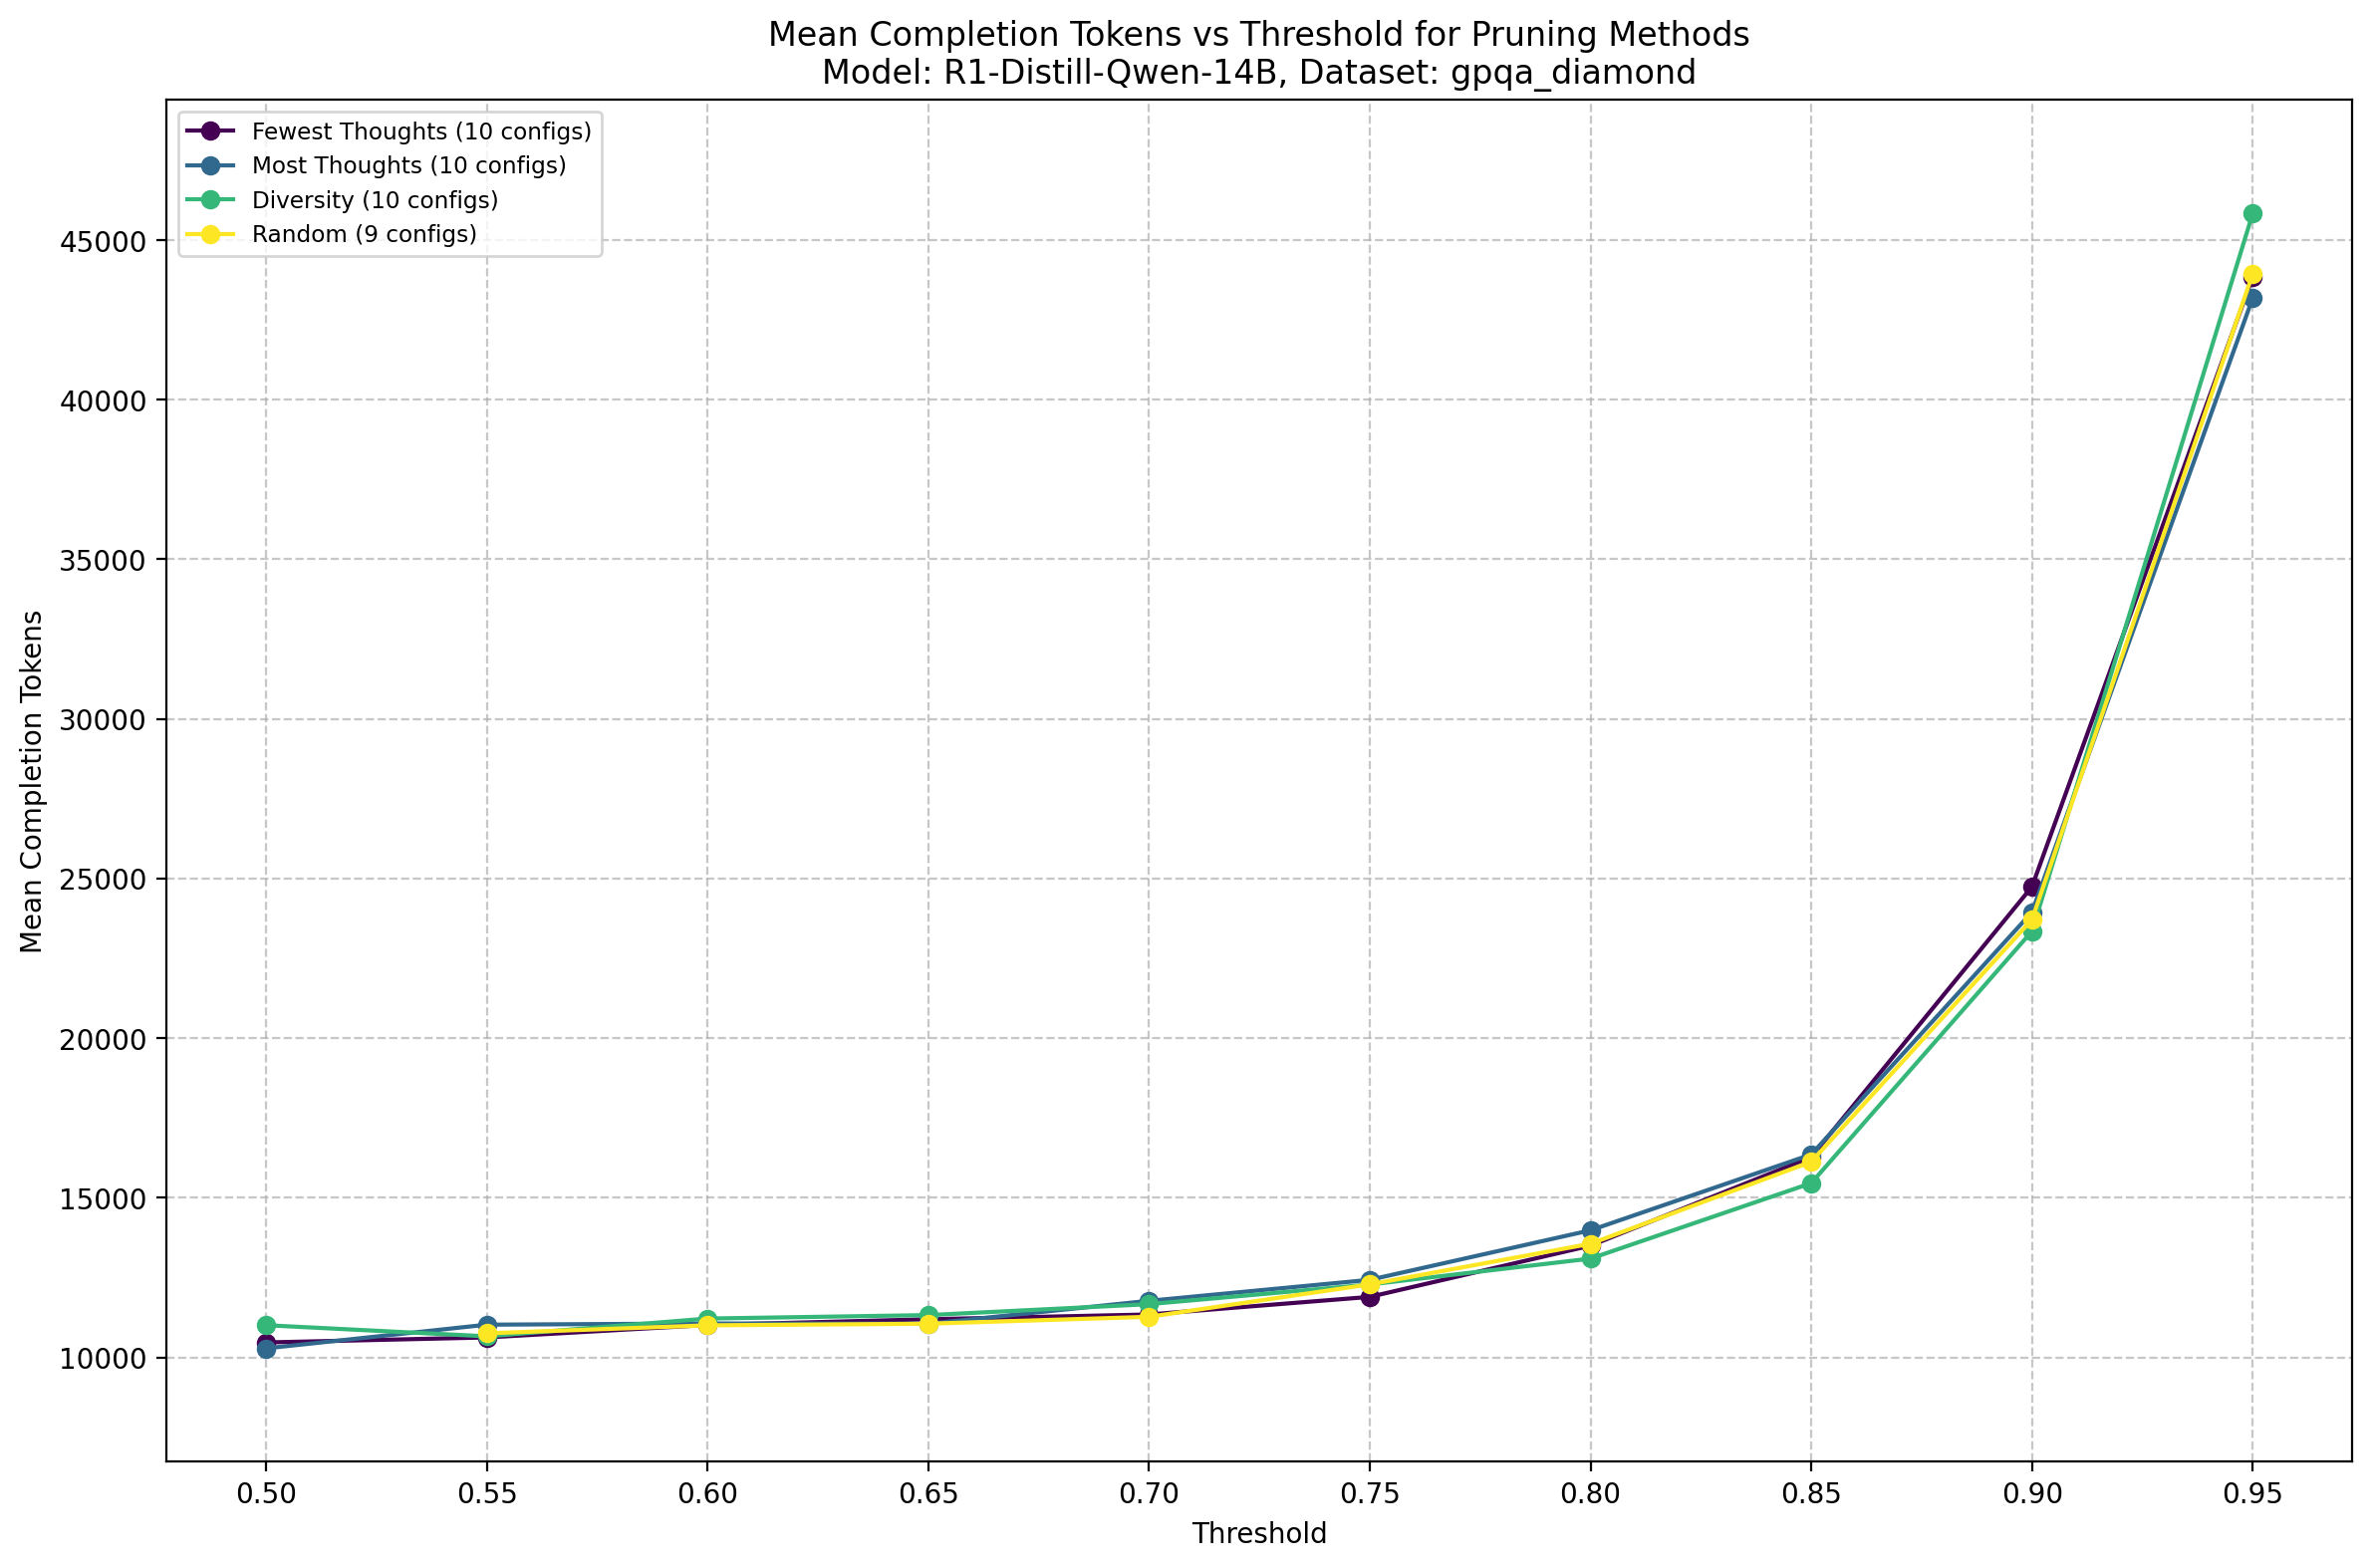


  Generating plot: Mean Peak KV Cache Usage (%) vs Threshold
  Plot saved to /home/users/ntu/chong032/slimsc/prune/visualization/mean_kv_cache_vs_threshold_R1-Distill-Qwen-14B_gpqa_diamond.png


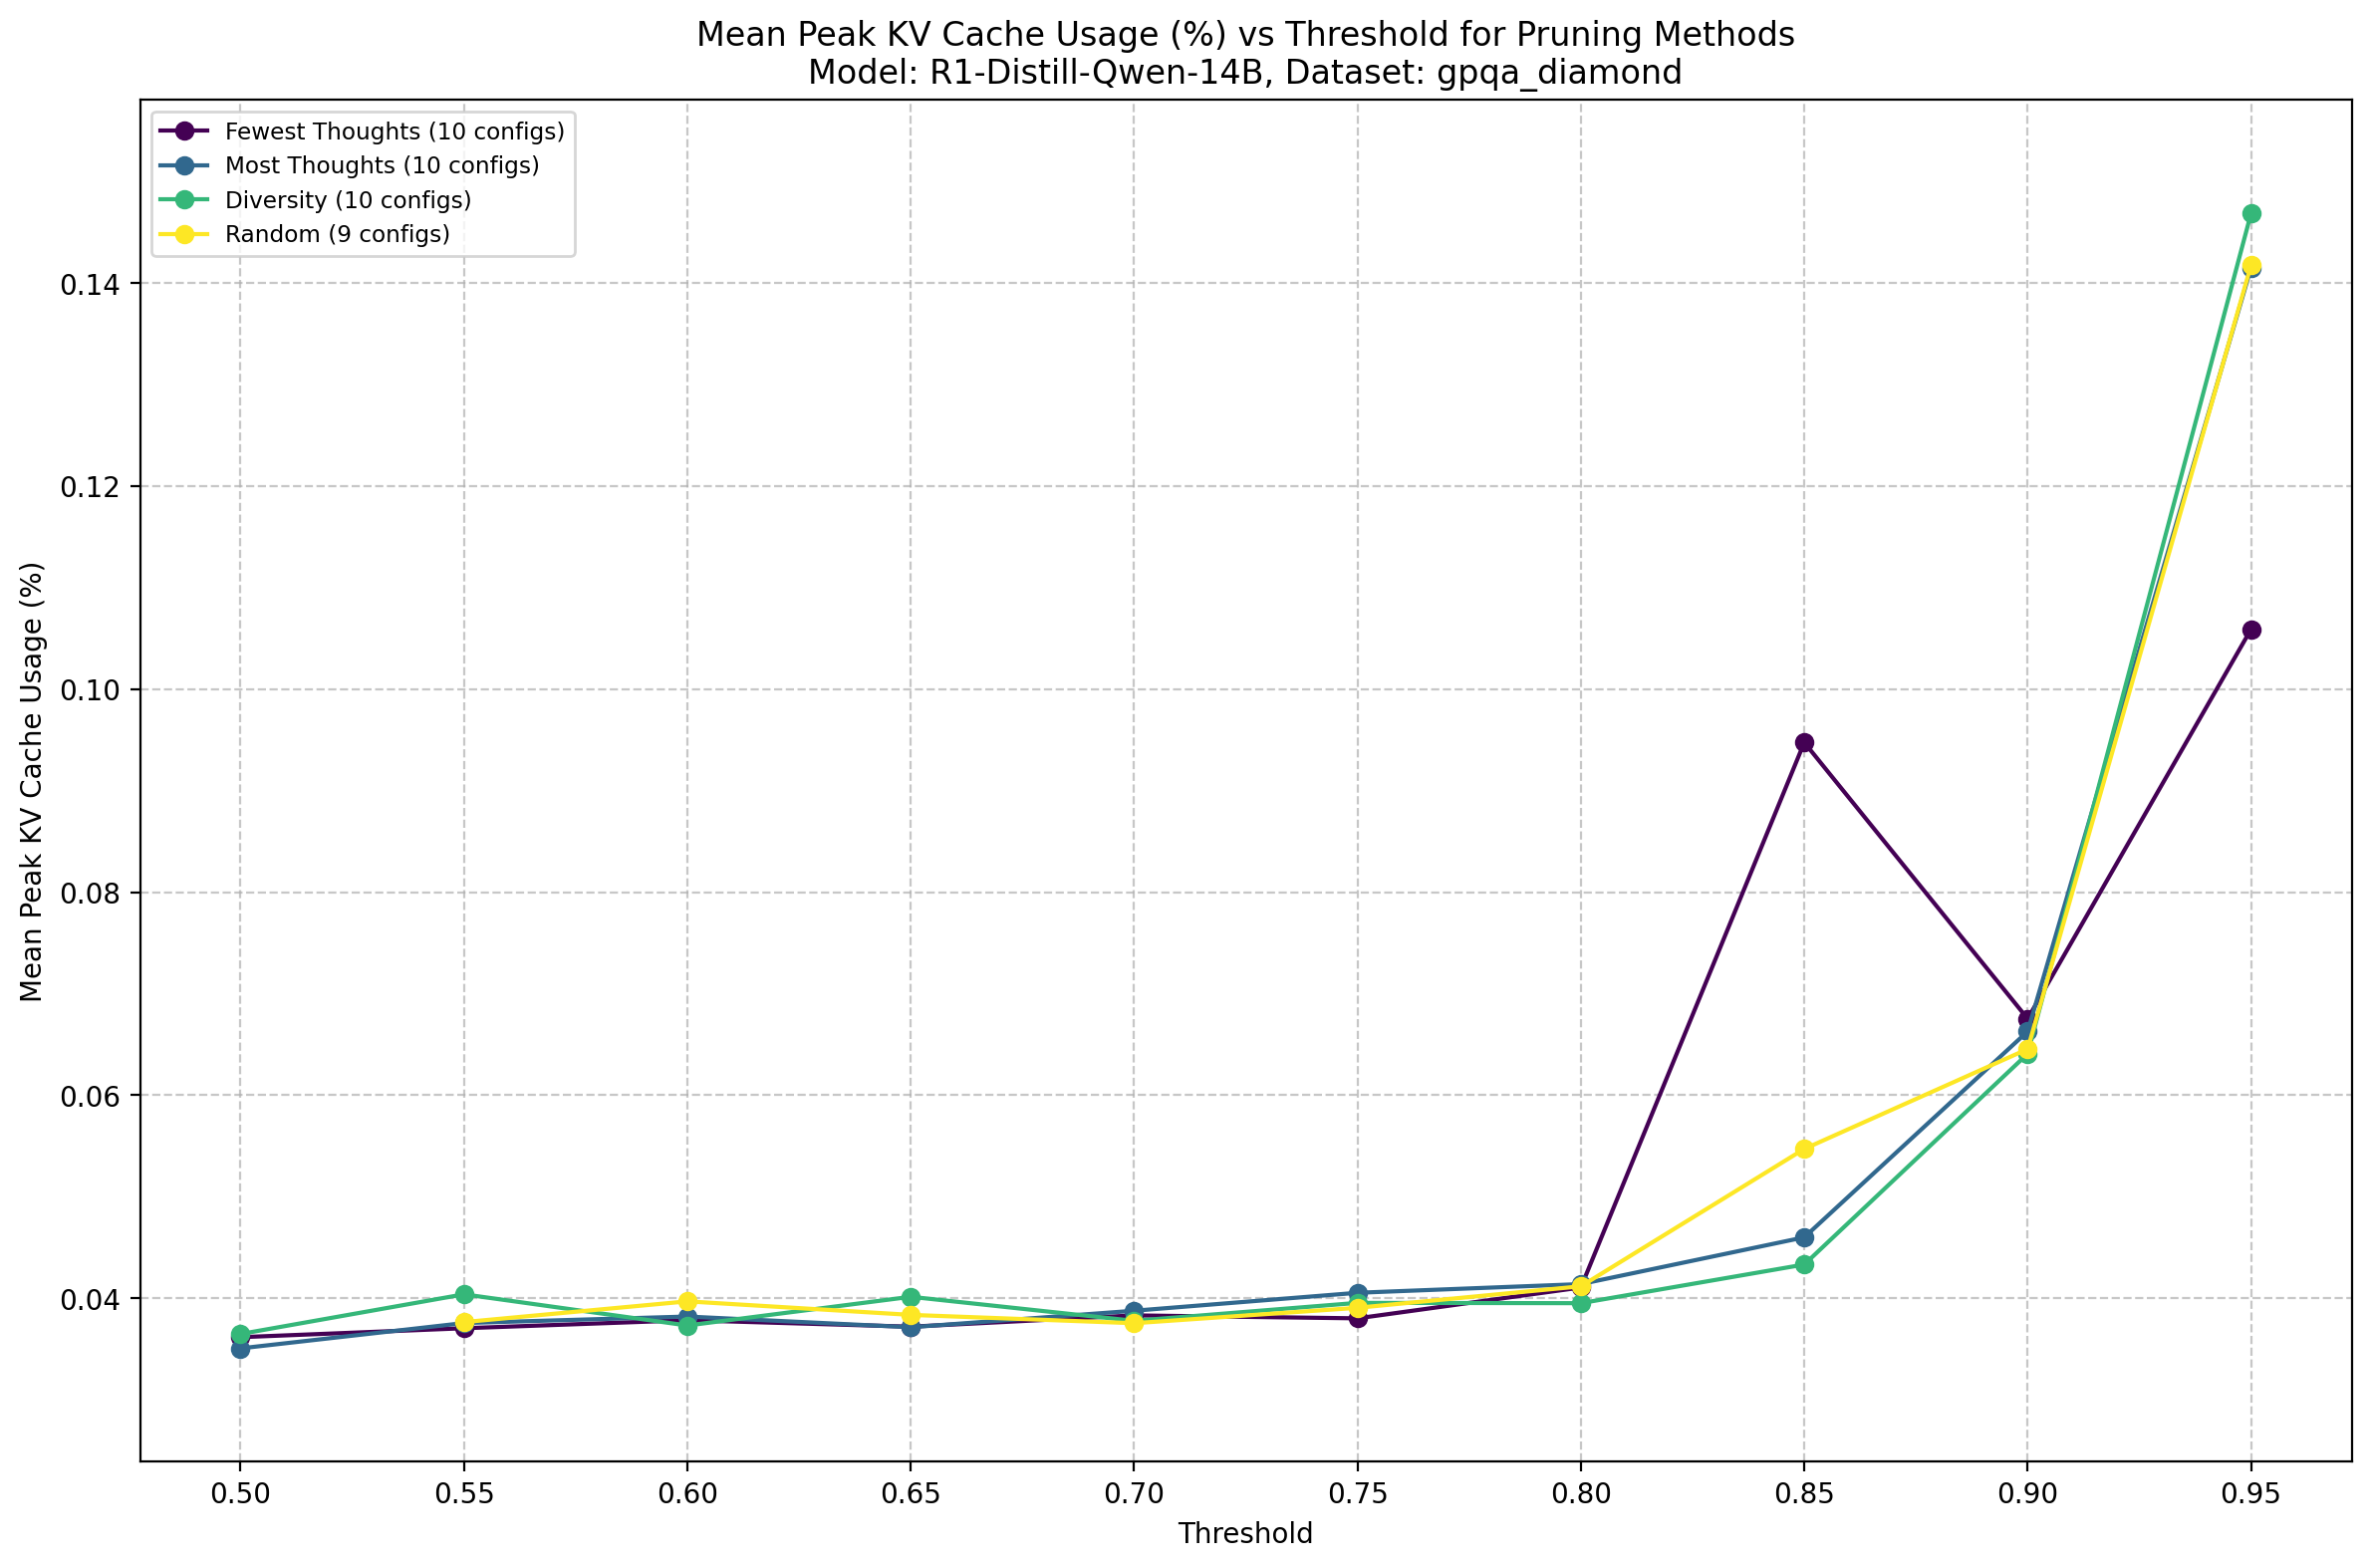


  Generating plot: Max Peak KV Cache Usage (%) vs Threshold
  Plot saved to /home/users/ntu/chong032/slimsc/prune/visualization/max_kv_cache_vs_threshold_R1-Distill-Qwen-14B_gpqa_diamond.png


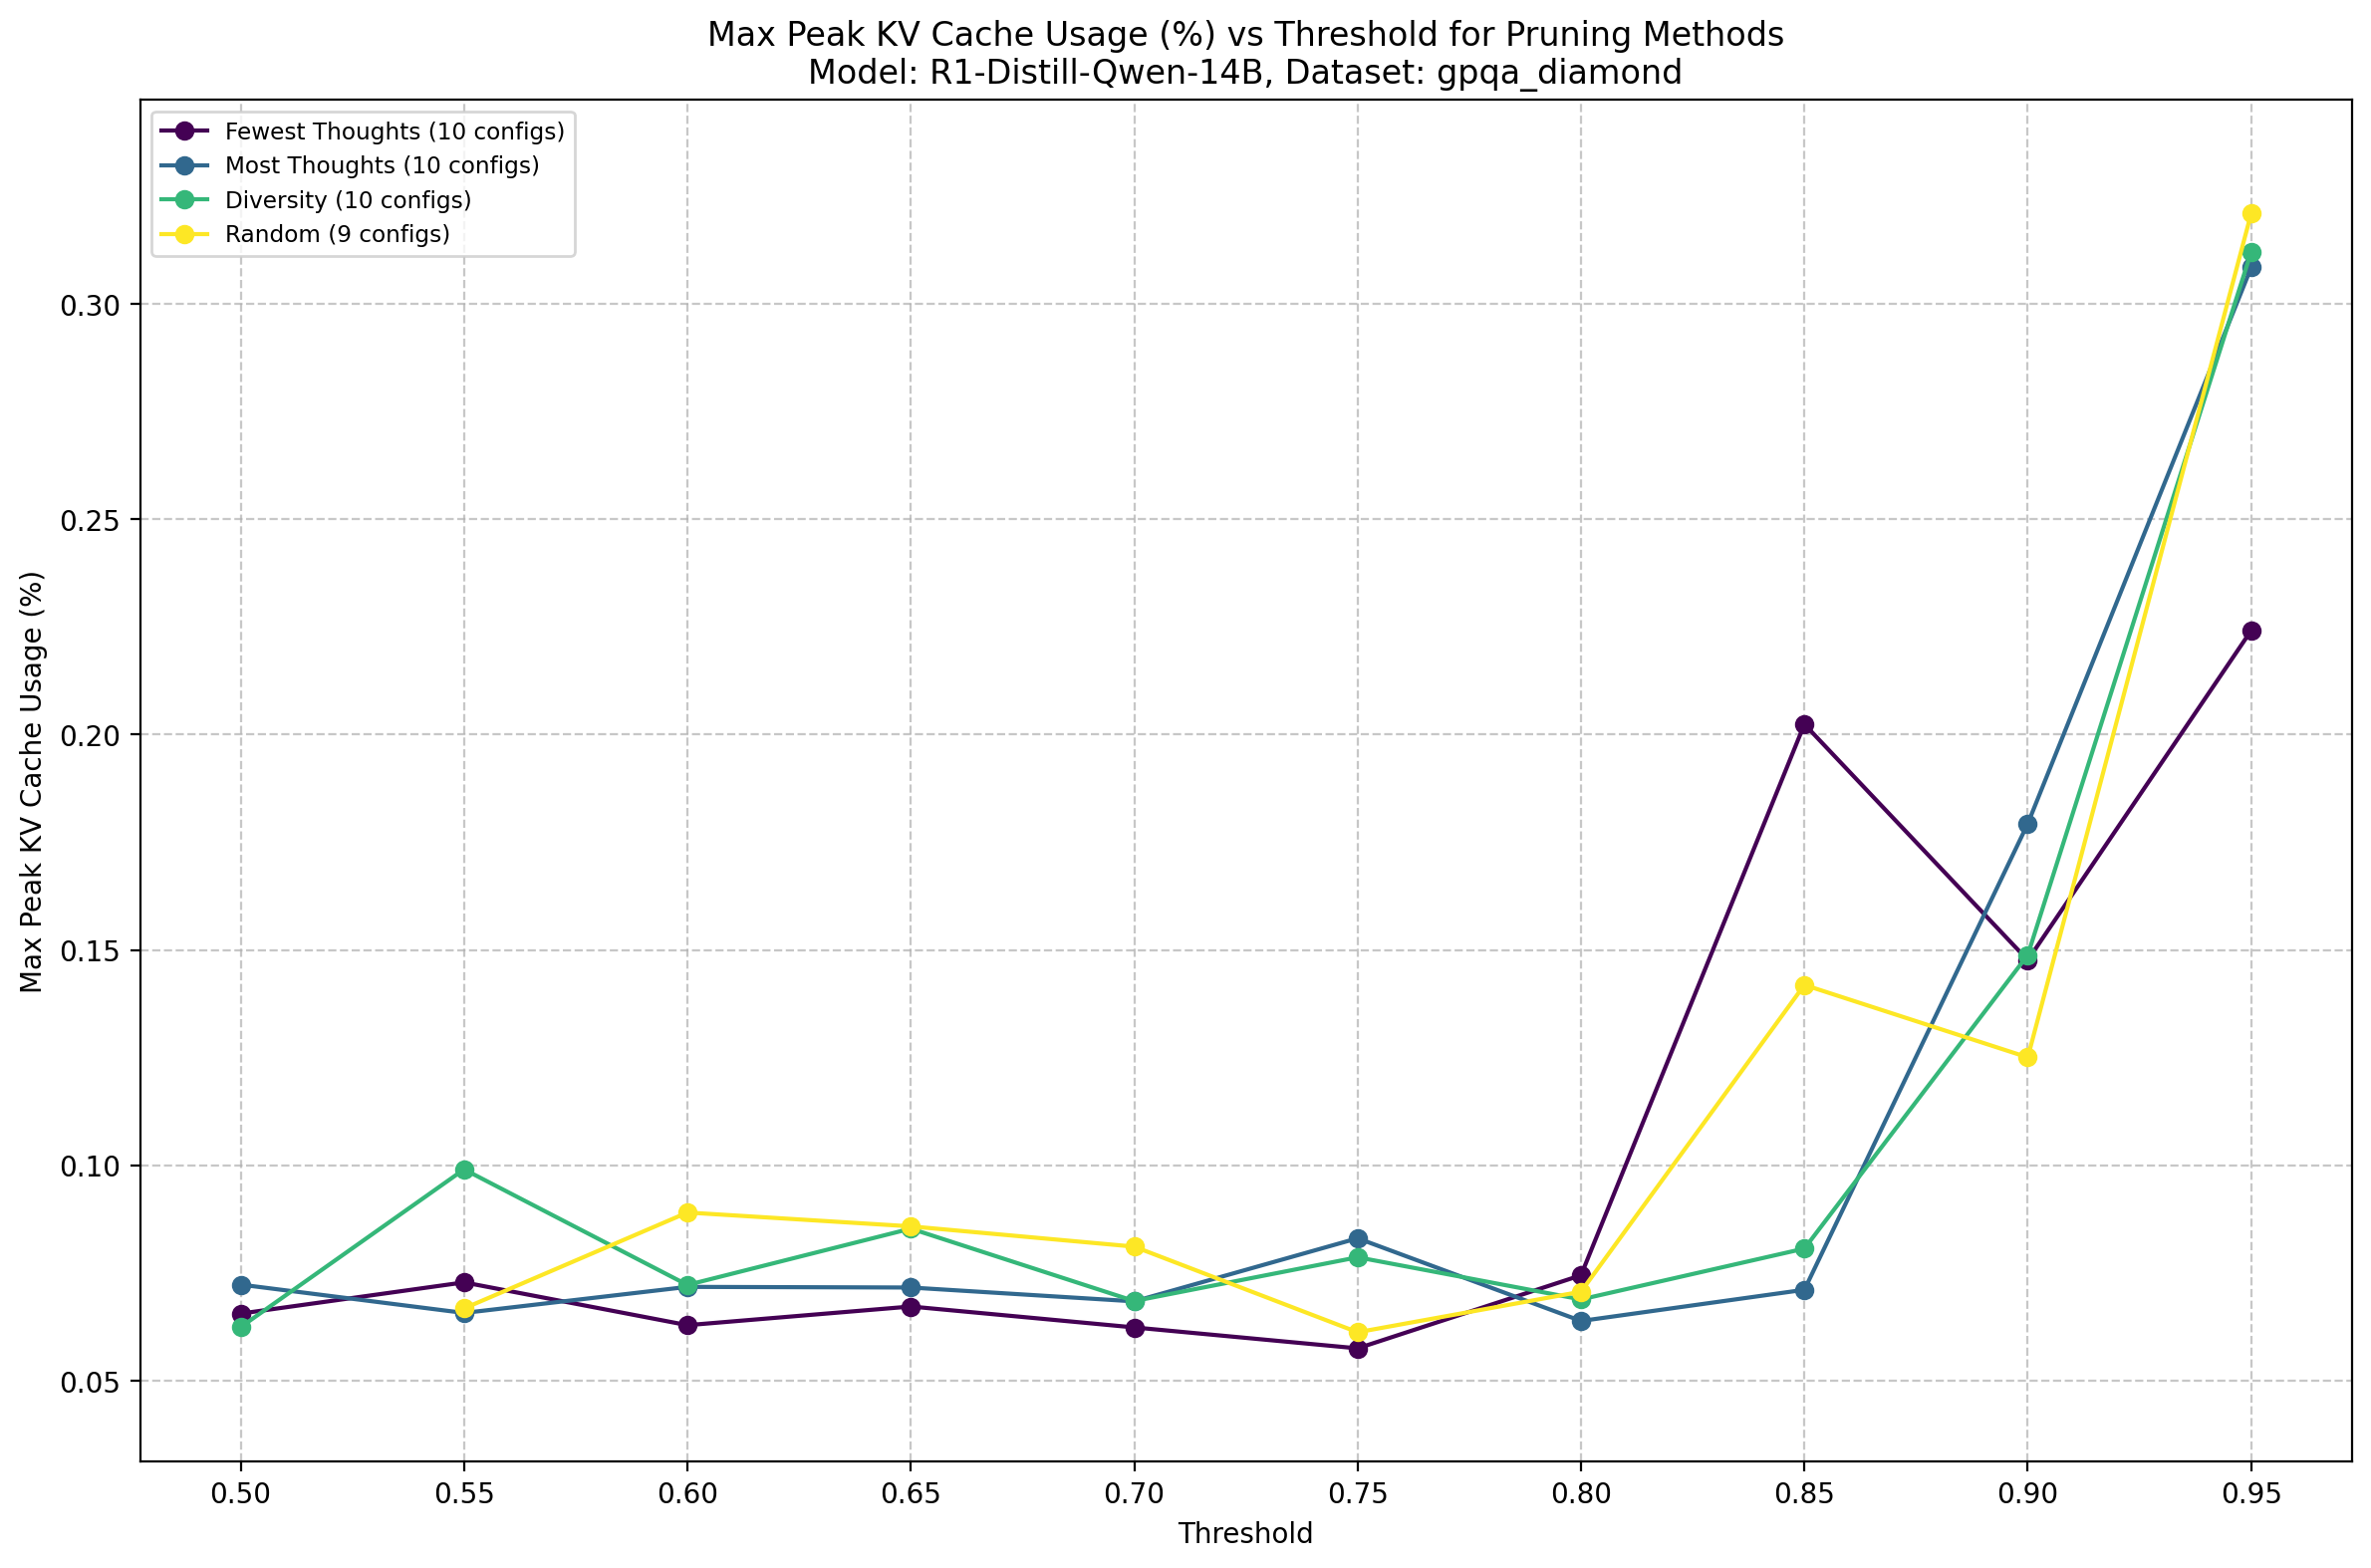


  Generating plot: Mean Processing Time (sec) vs Threshold
  Plot saved to /home/users/ntu/chong032/slimsc/prune/visualization/processing_time_vs_threshold_R1-Distill-Qwen-14B_gpqa_diamond.png


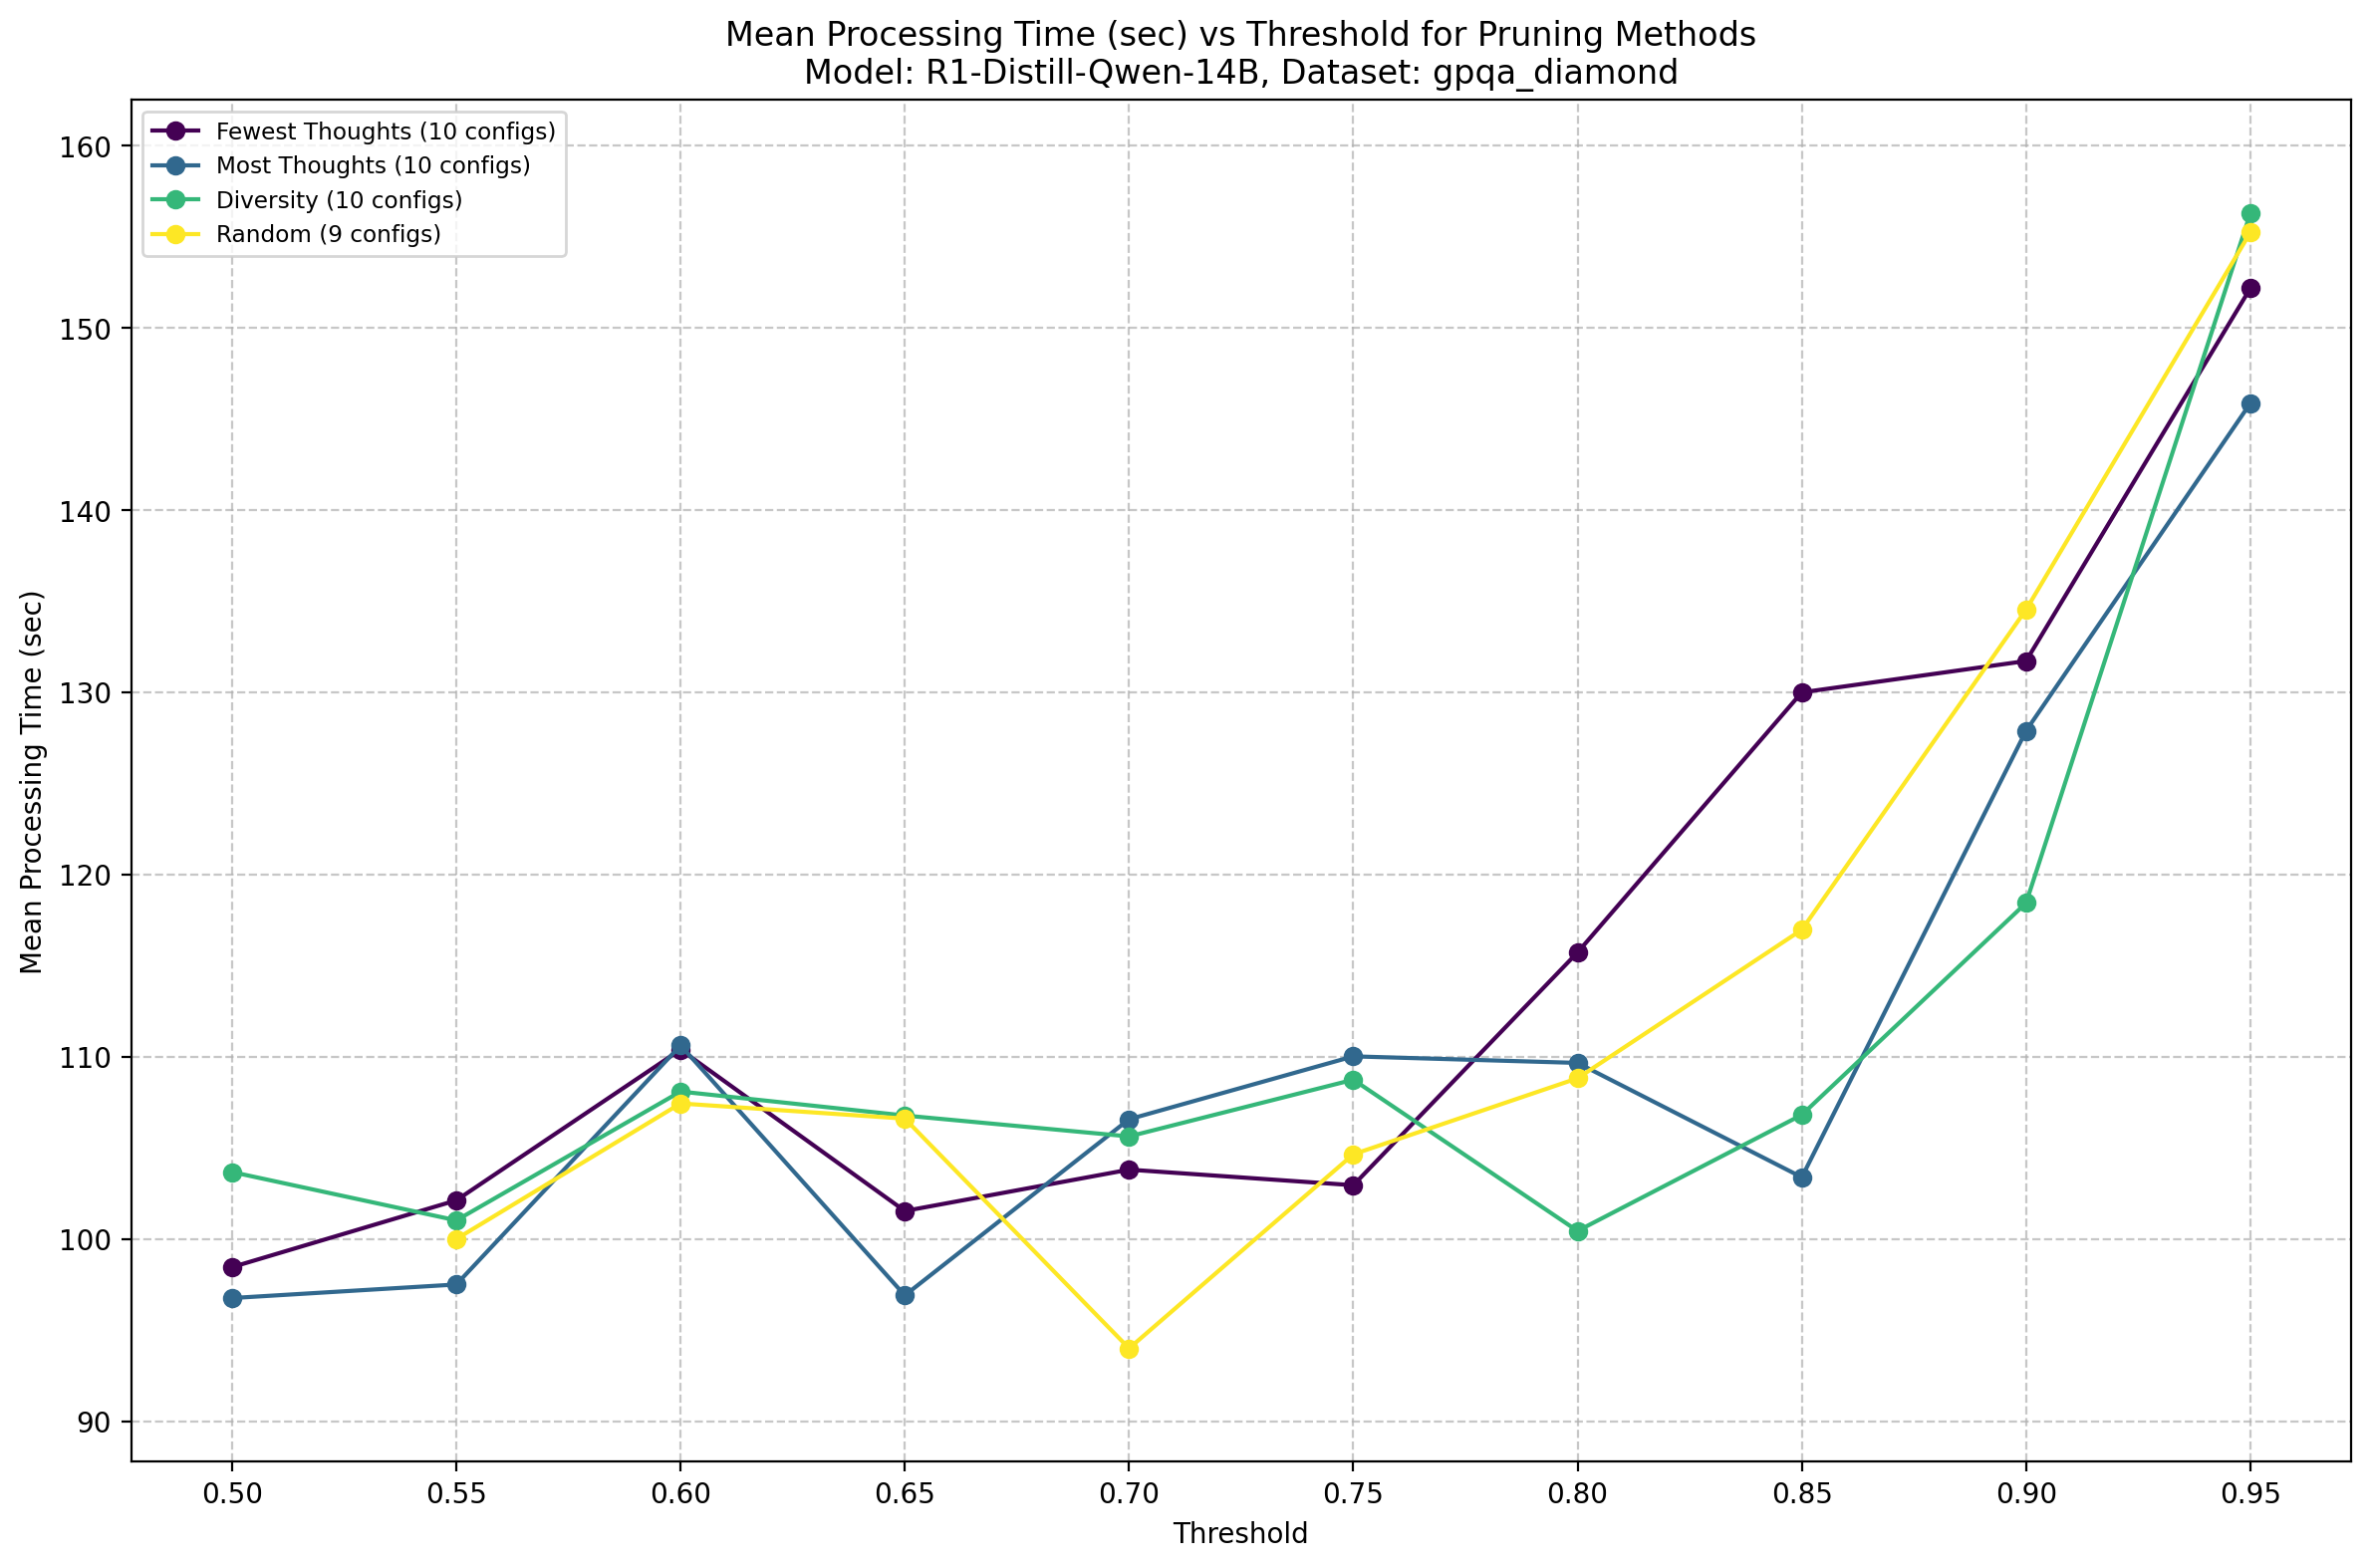


  Generating plot: Mean Chains Completed for Voting vs Threshold
  Plot saved to /home/users/ntu/chong032/slimsc/prune/visualization/chains_completed_voting_perc_vs_threshold_R1-Distill-Qwen-14B_gpqa_diamond.png


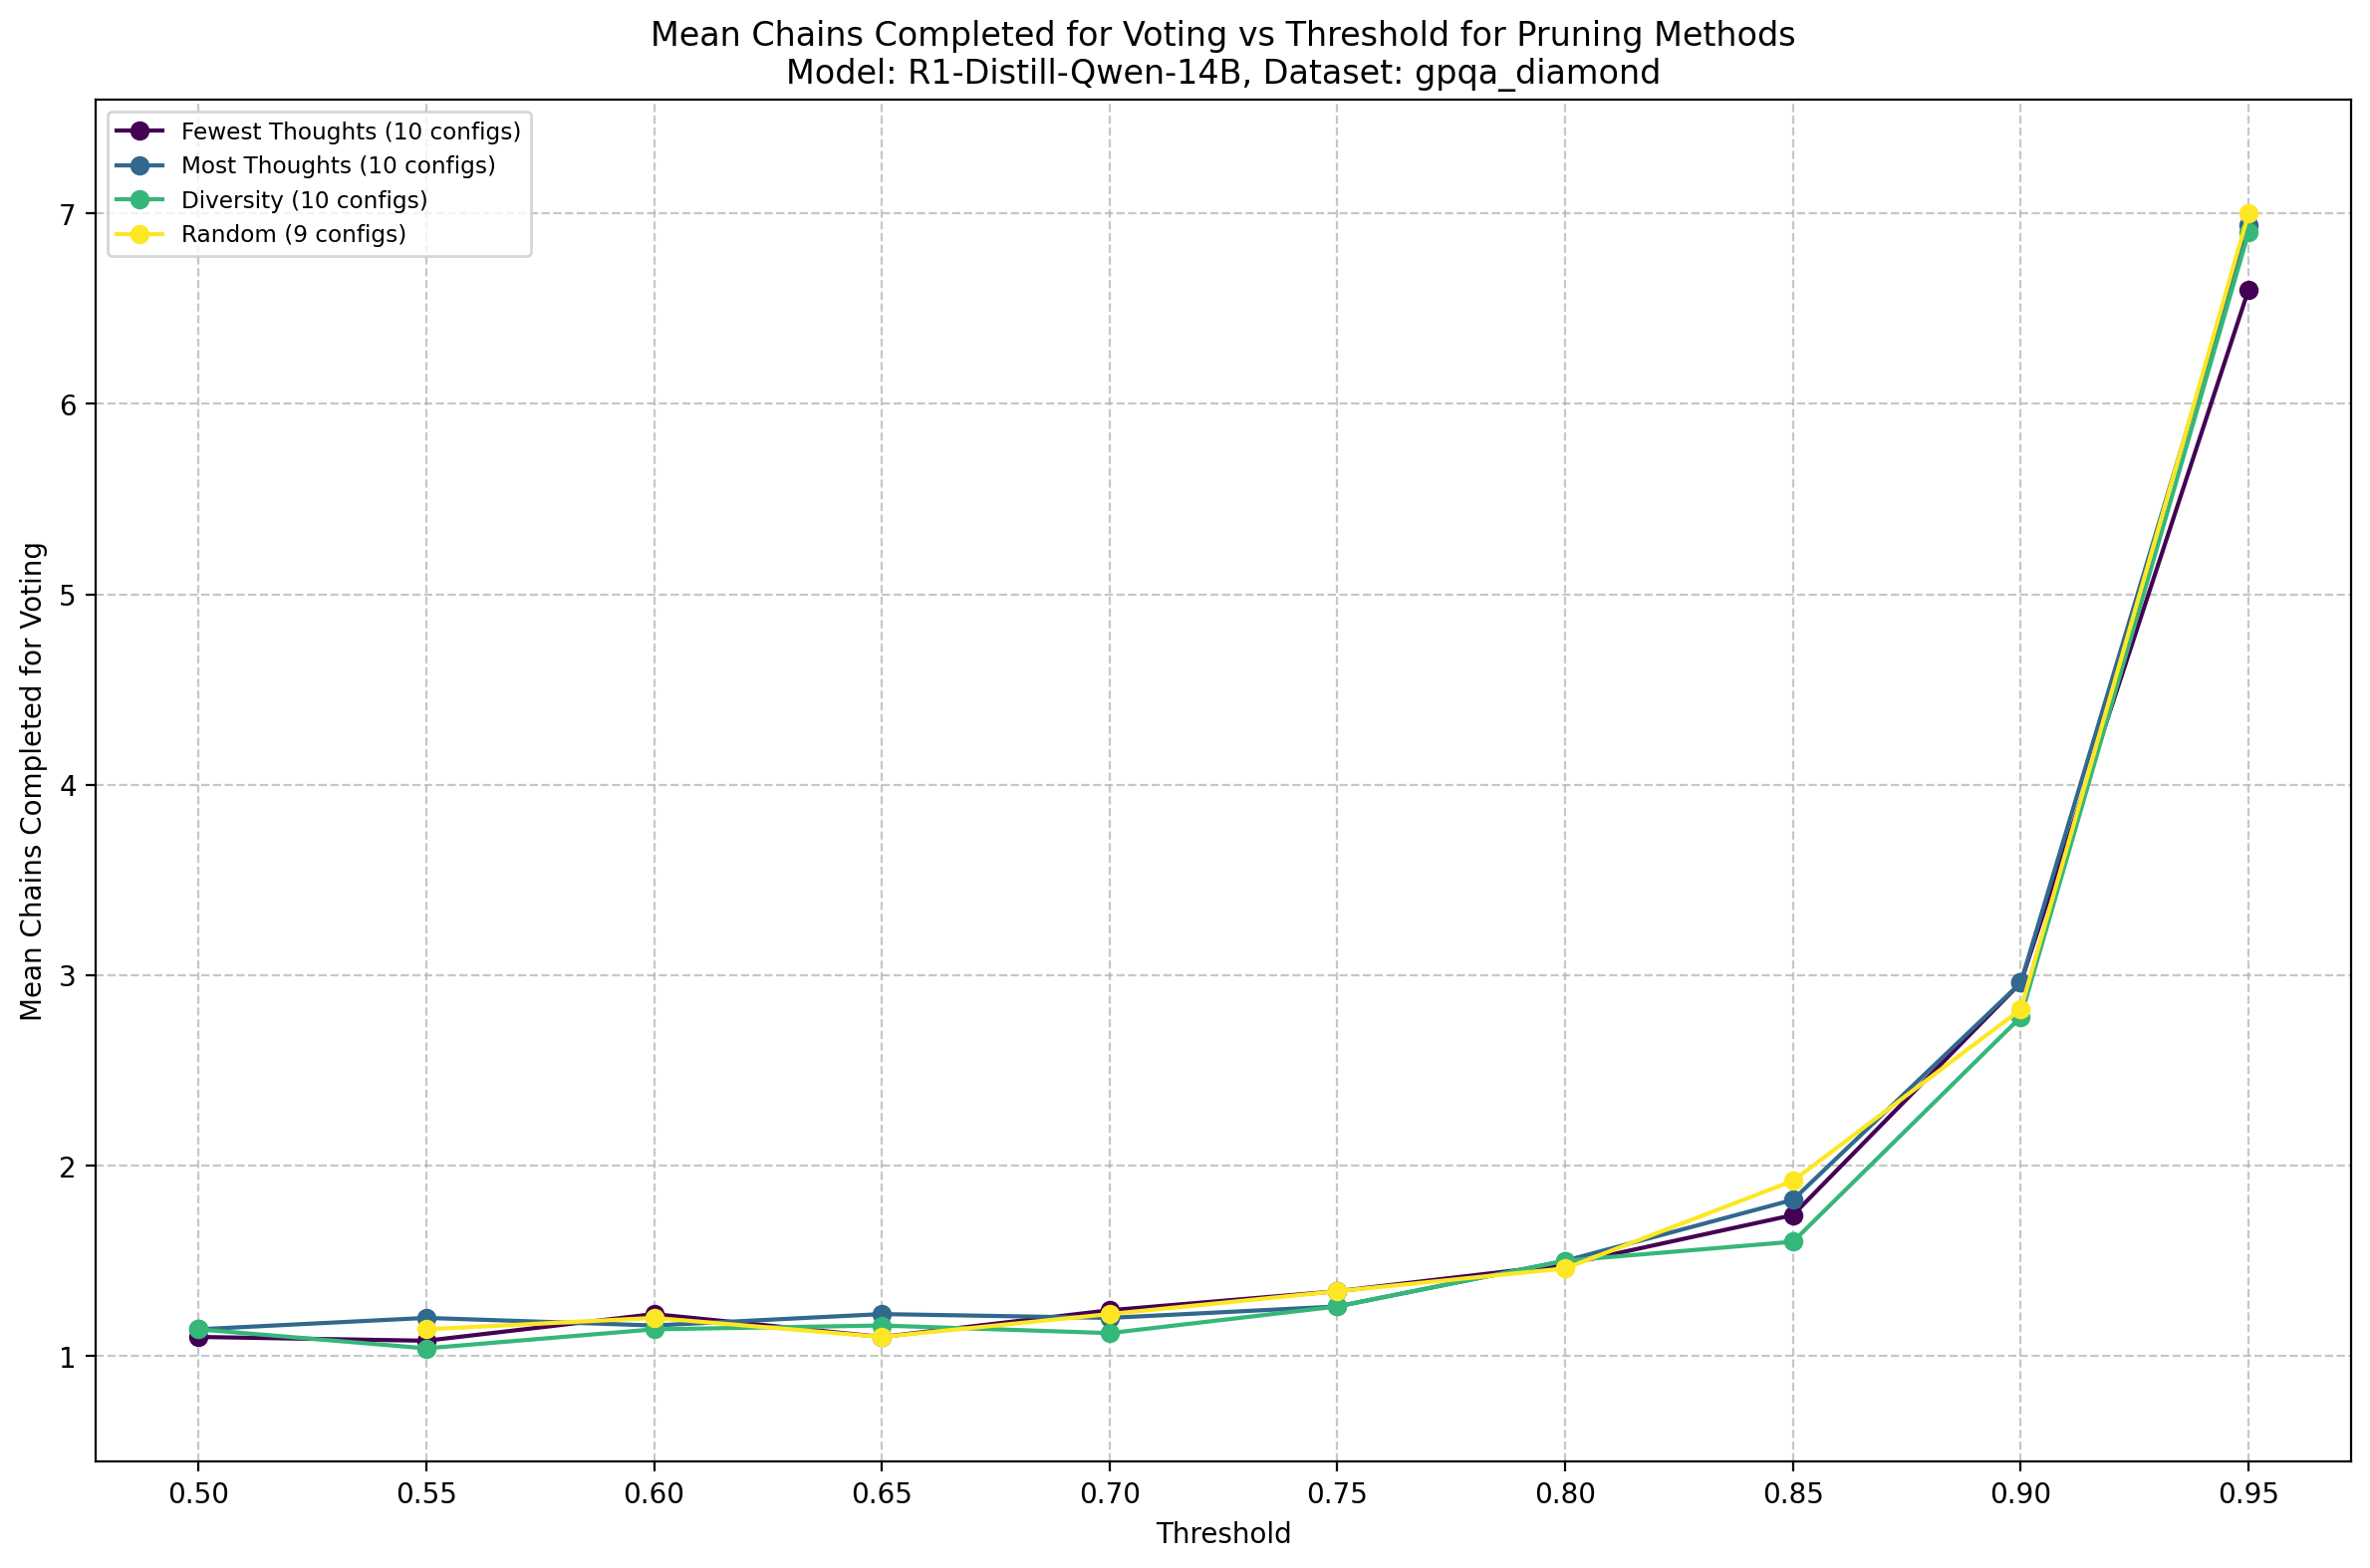

In [24]:
# Cell 6: Generate Plots

# Generate plots for each unique model/dataset combination found in the data
if not metrics_df.empty and plots_save_dir and plots_save_dir.is_dir(): # Ensure plots_save_dir is valid
    unique_models = metrics_df['model'].unique()
    unique_datasets = metrics_df['dataset'].unique()
    
    print("\n--- Generating Plots per Model/Dataset ---")
    
    # Define the metrics to plot
    metrics_to_plot = [
        ('overall_accuracy', 'Accuracy', 'accuracy'),
        ('mean_total_completion_tokens_per_question', 'Mean Completion Tokens', 'completion_tokens'),
        ('mean_max_kv_cache_usage_per_question_perc', 'Mean Peak KV Cache Usage (%)', 'mean_kv_cache'),
        ('max_max_kv_cache_usage_across_all_questions_perc', 'Max Peak KV Cache Usage (%)', 'max_kv_cache'),
        ('mean_processing_duration_sec_per_question', 'Mean Processing Time (sec)', 'processing_time'),
        ('mean_chains_completed_stream_for_voting_per_question', 'Mean Chains Completed for Voting', 'chains_completed_voting_perc') # MODIFICATION: Updated metric
    ]

    for model in unique_models:
        for dataset in unique_datasets:
            print(f"\n--- Generating plots for Model: {model}, Dataset: {dataset} ---")
            
            # Filter data once for the current model/dataset
            current_df = metrics_df[(metrics_df['model'] == model) & (metrics_df['dataset'] == dataset)].copy()

            if current_df.empty:
                 print(f"No data for Model: {model}, Dataset: {dataset}. Skipping plots.")
                 continue

            # Check if any threshold data exists before trying to plot threshold vs metric
            threshold_methods = ['fewest_thoughts', 'most_thoughts', 'diversity', 'random']
            has_threshold_data = not current_df[current_df['pruning_method'].isin(threshold_methods)].dropna(subset=['threshold']).empty

            if not has_threshold_data:
                 print(f"Note: No threshold-based data found for Model: {model}, Dataset: {dataset}. Only plotting non-threshold methods as horizontal lines where applicable.")


            for metric_col, metric_label, plot_file_prefix in metrics_to_plot:
                # Check if the required metric column exists in the data *for this combination*
                # AND if there's at least one non-NaN value in that column
                if metric_col not in current_df.columns or current_df[metric_col].dropna().empty:
                    print(f"  Skipping plot '{metric_label} vs Threshold' for Model: {model}, Dataset: {dataset}. Metric column '{metric_col}' not found or contains no valid data.")
                    continue
                    
                print(f"\n  Generating plot: {metric_label} vs Threshold")
                plot_metric_vs_threshold(
                    current_df, # Pass the filtered DataFrame
                    metric_col=metric_col,
                    metric_label=metric_label,
                    model_name=model,       # Pass filters (redundant with filtered_df but keeps API consistent)
                    dataset_name=dataset,   # Pass filters
                    save_base_dir=plots_save_dir, # Pass the plot save directory
                    plot_file_prefix=plot_file_prefix
                )
else:
    print("\nNo data in DataFrame to plot or plot save directory is invalid.")

In [25]:
from collections import Counter, defaultdict
from scipy import interpolate
import seaborn as sns

def parse_experiment_name(dir_name):
    """
    Parses the experiment directory name to extract strategy and parameters.
    Returns a tuple: (strategy_key, label) or (None, None) if parsing fails.
    """
    if not dir_name:
        # print(f"  -> Warning: Empty directory name provided.") # Quieter logging
        return None, None

    # Find parameters using regex
    n_match = re.search(r'_n(\d+)', dir_name)
    thresh_match = re.search(r'_thresh([\d.]+)', dir_name)
    max_active_match = re.search(r'_max_active(\d+)', dir_name)

    # Determine the start index of the first parameter found
    first_param_start_index = len(dir_name)
    if n_match:
        first_param_start_index = min(first_param_start_index, n_match.start())
    if thresh_match:
        first_param_start_index = min(first_param_start_index, thresh_match.start())
    if max_active_match:
        first_param_start_index = min(first_param_start_index, max_active_match.start())

    strategy_name = dir_name[:first_param_start_index]

    params_label_parts = []
    if n_match:
        params_label_parts.append(f"n={n_match.group(1)}")
    if thresh_match:
        params_label_parts.append(f"thr={thresh_match.group(1)}")
    if max_active_match:
        params_label_parts.append(f"max_act={max_active_match.group(1)}")

    label_base = strategy_name.replace('_', ' ').title() # Use title case for label
    if params_label_parts:
        label = f"{label_base} ({', '.join(params_label_parts)})"
    else:
        label = label_base

    temp_strategy_name_lower = strategy_name.lower()
    strategy_key = strategy_name

    if 'diversity' in temp_strategy_name_lower:
        strategy_key = 'diversity'
    elif 'most_thoughts' in temp_strategy_name_lower:
        strategy_key = 'most_thoughts'
    elif 'fewest_thoughts' in temp_strategy_name_lower:
        strategy_key = 'fewest_thoughts'
    elif 'random' in temp_strategy_name_lower:
        strategy_key = 'random'
    elif 'sc_' in temp_strategy_name_lower: # More specific for sc_ variants
        strategy_key = 'sc_variants'
    elif temp_strategy_name_lower == 'sc':
        strategy_key = 'sc_control' # Differentiate SC control from variants
    elif temp_strategy_name_lower == 'baseline':
        strategy_key = 'baseline'

    if not params_label_parts:
        known_mapped_simple_keys = {'diversity', 'most_thoughts', 'fewest_thoughts', 'random', 'sc_control', 'sc_variants', 'baseline'}
        if strategy_key == strategy_name and strategy_name not in known_mapped_simple_keys:
            # print(f"  -> Warning: Could not parse strategy from directory name (unrecognized format without parameters): {dir_name}")
            return None, None

    return strategy_key, label

# Define the base directory containing the experiment results for pruning CDF
# This should point to where your pruning experiment folders (e.g., diversity_n10_thresh0.65) are
PRUNING_RESULTS_BASE_DIR = Path(os.getcwd()).parent / "results" / "R1-Distill-Qwen-14B" / "gpqa_diamond"
# Example: PRUNING_RESULTS_BASE_DIR = Path("/mnt/users/slimsc/prune/results/R1-Distill-Qwen-14B/gpqa_diamond")

print(f"Pruning CDF Plot: Base results directory set to: {PRUNING_RESULTS_BASE_DIR}")
if not PRUNING_RESULTS_BASE_DIR.is_dir():
    print(f"WARNING: Pruning results directory NOT FOUND at {PRUNING_RESULTS_BASE_DIR}")

Pruning CDF Plot: Base results directory set to: /home/users/ntu/chong032/slimsc/prune/results/R1-Distill-Qwen-14B/gpqa_diamond



--- Aggregating data for Pruning CDF plots ---

--- Calculating Statistics and Generating Pruning CDF Plots ---

Generating Pruning CDF plot for strategy: Diversity


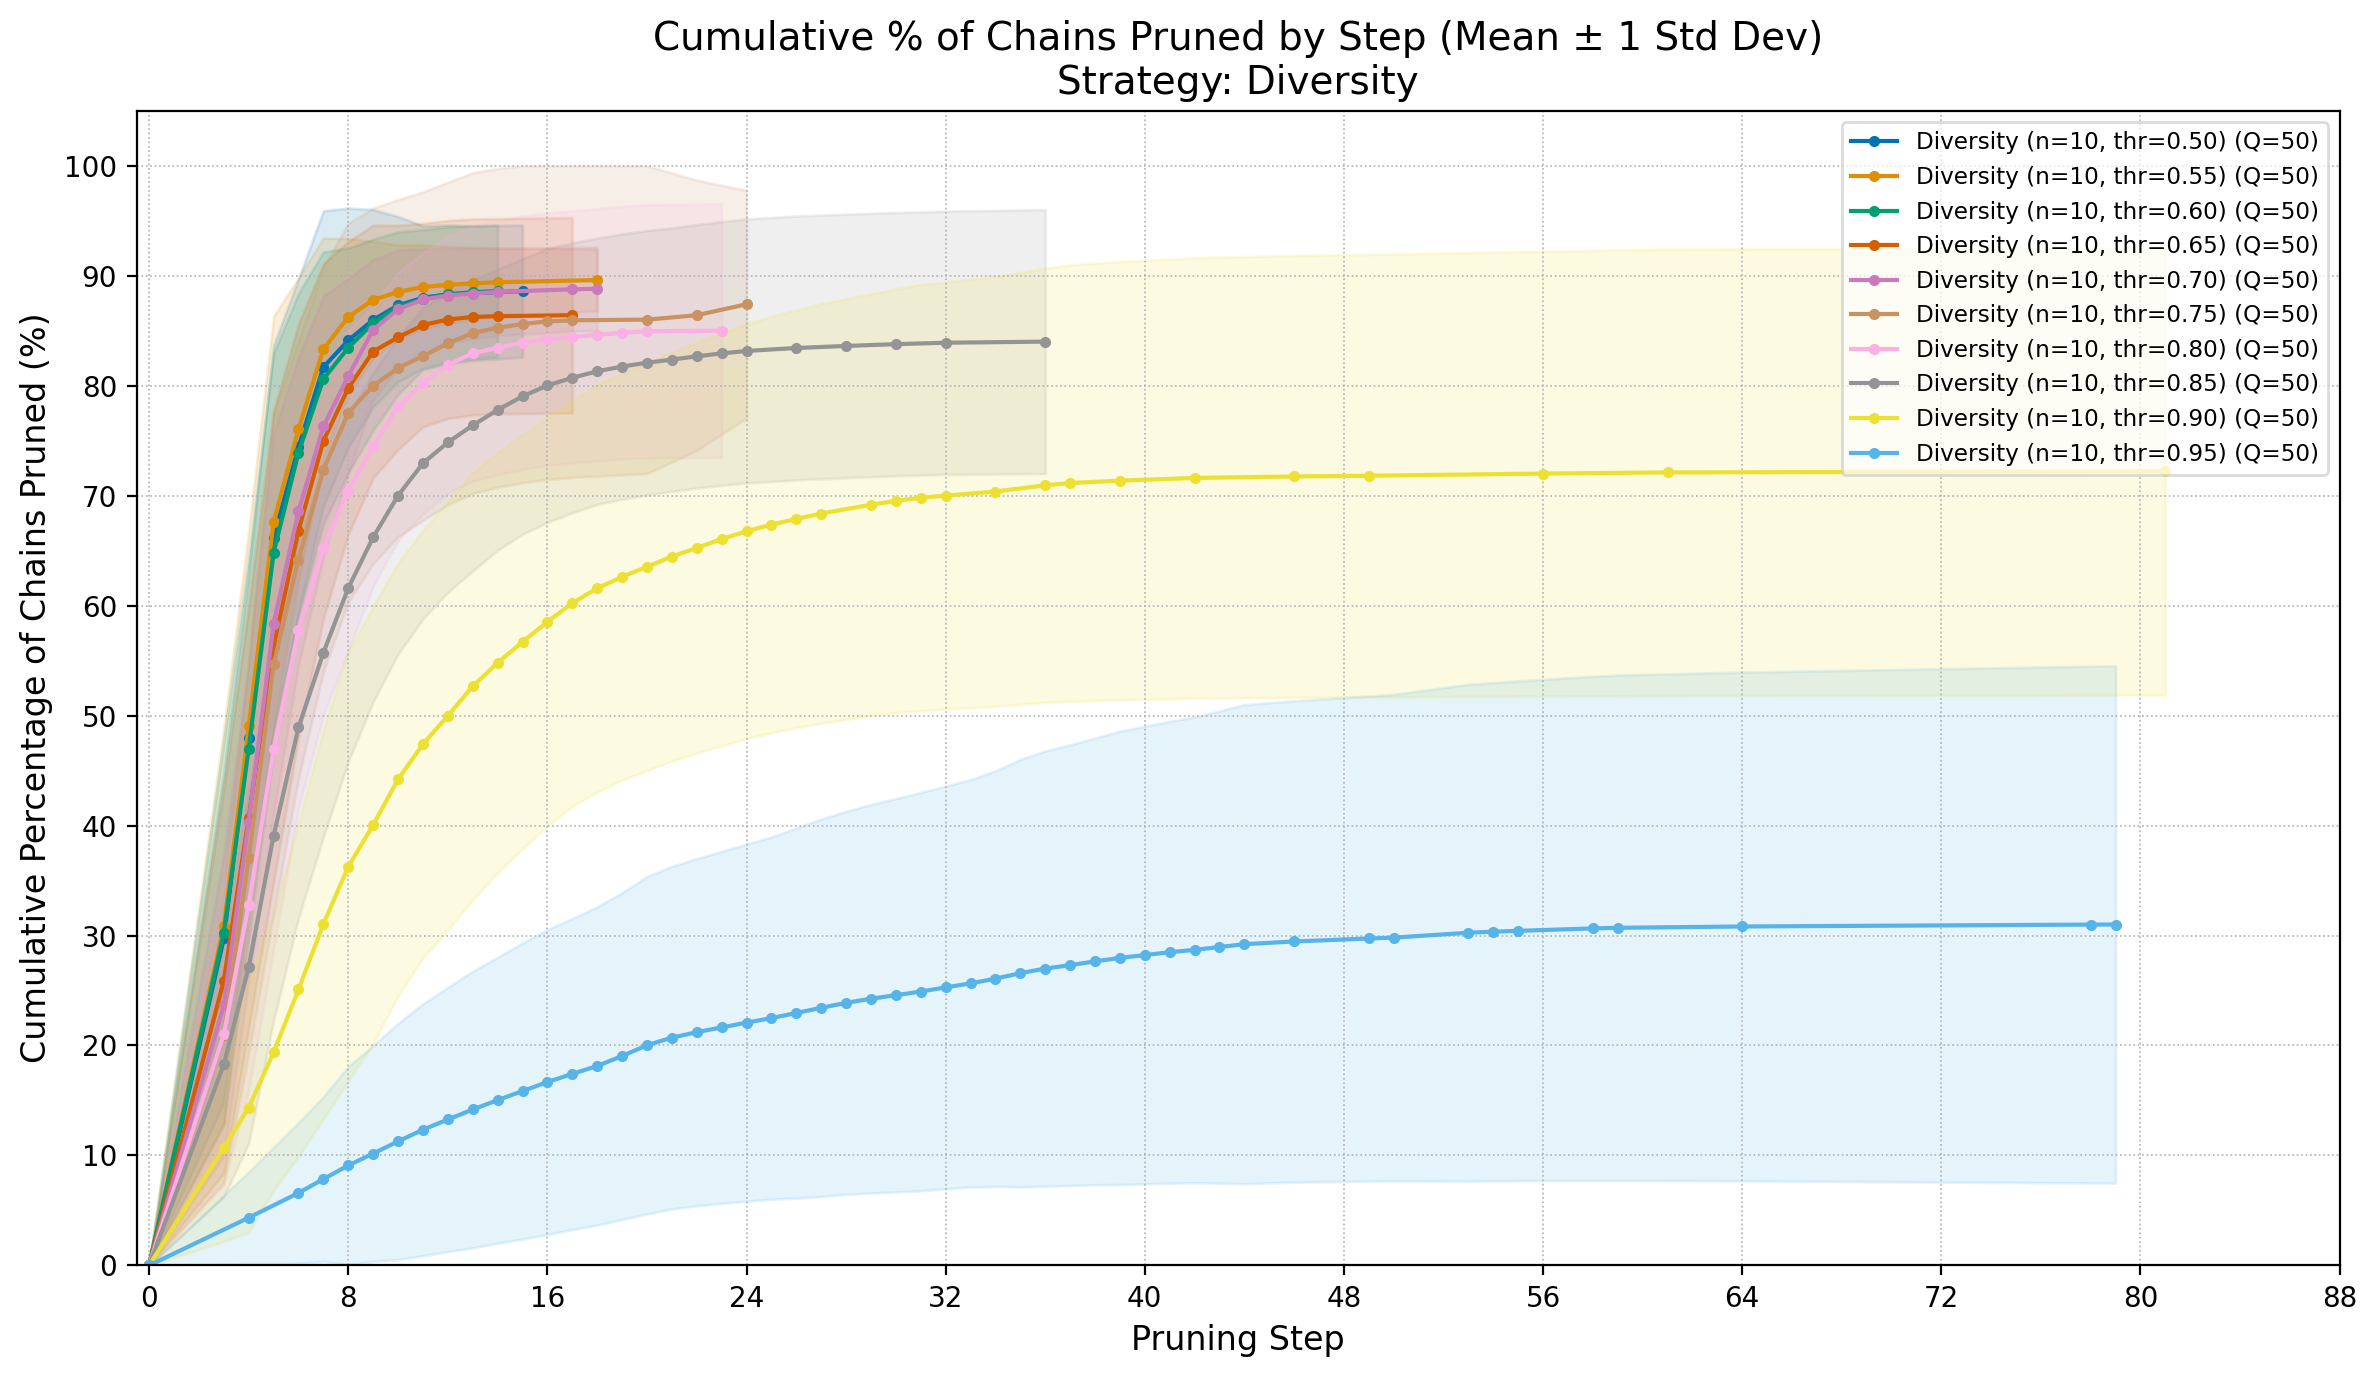


Generating Pruning CDF plot for strategy: Fewest Thoughts


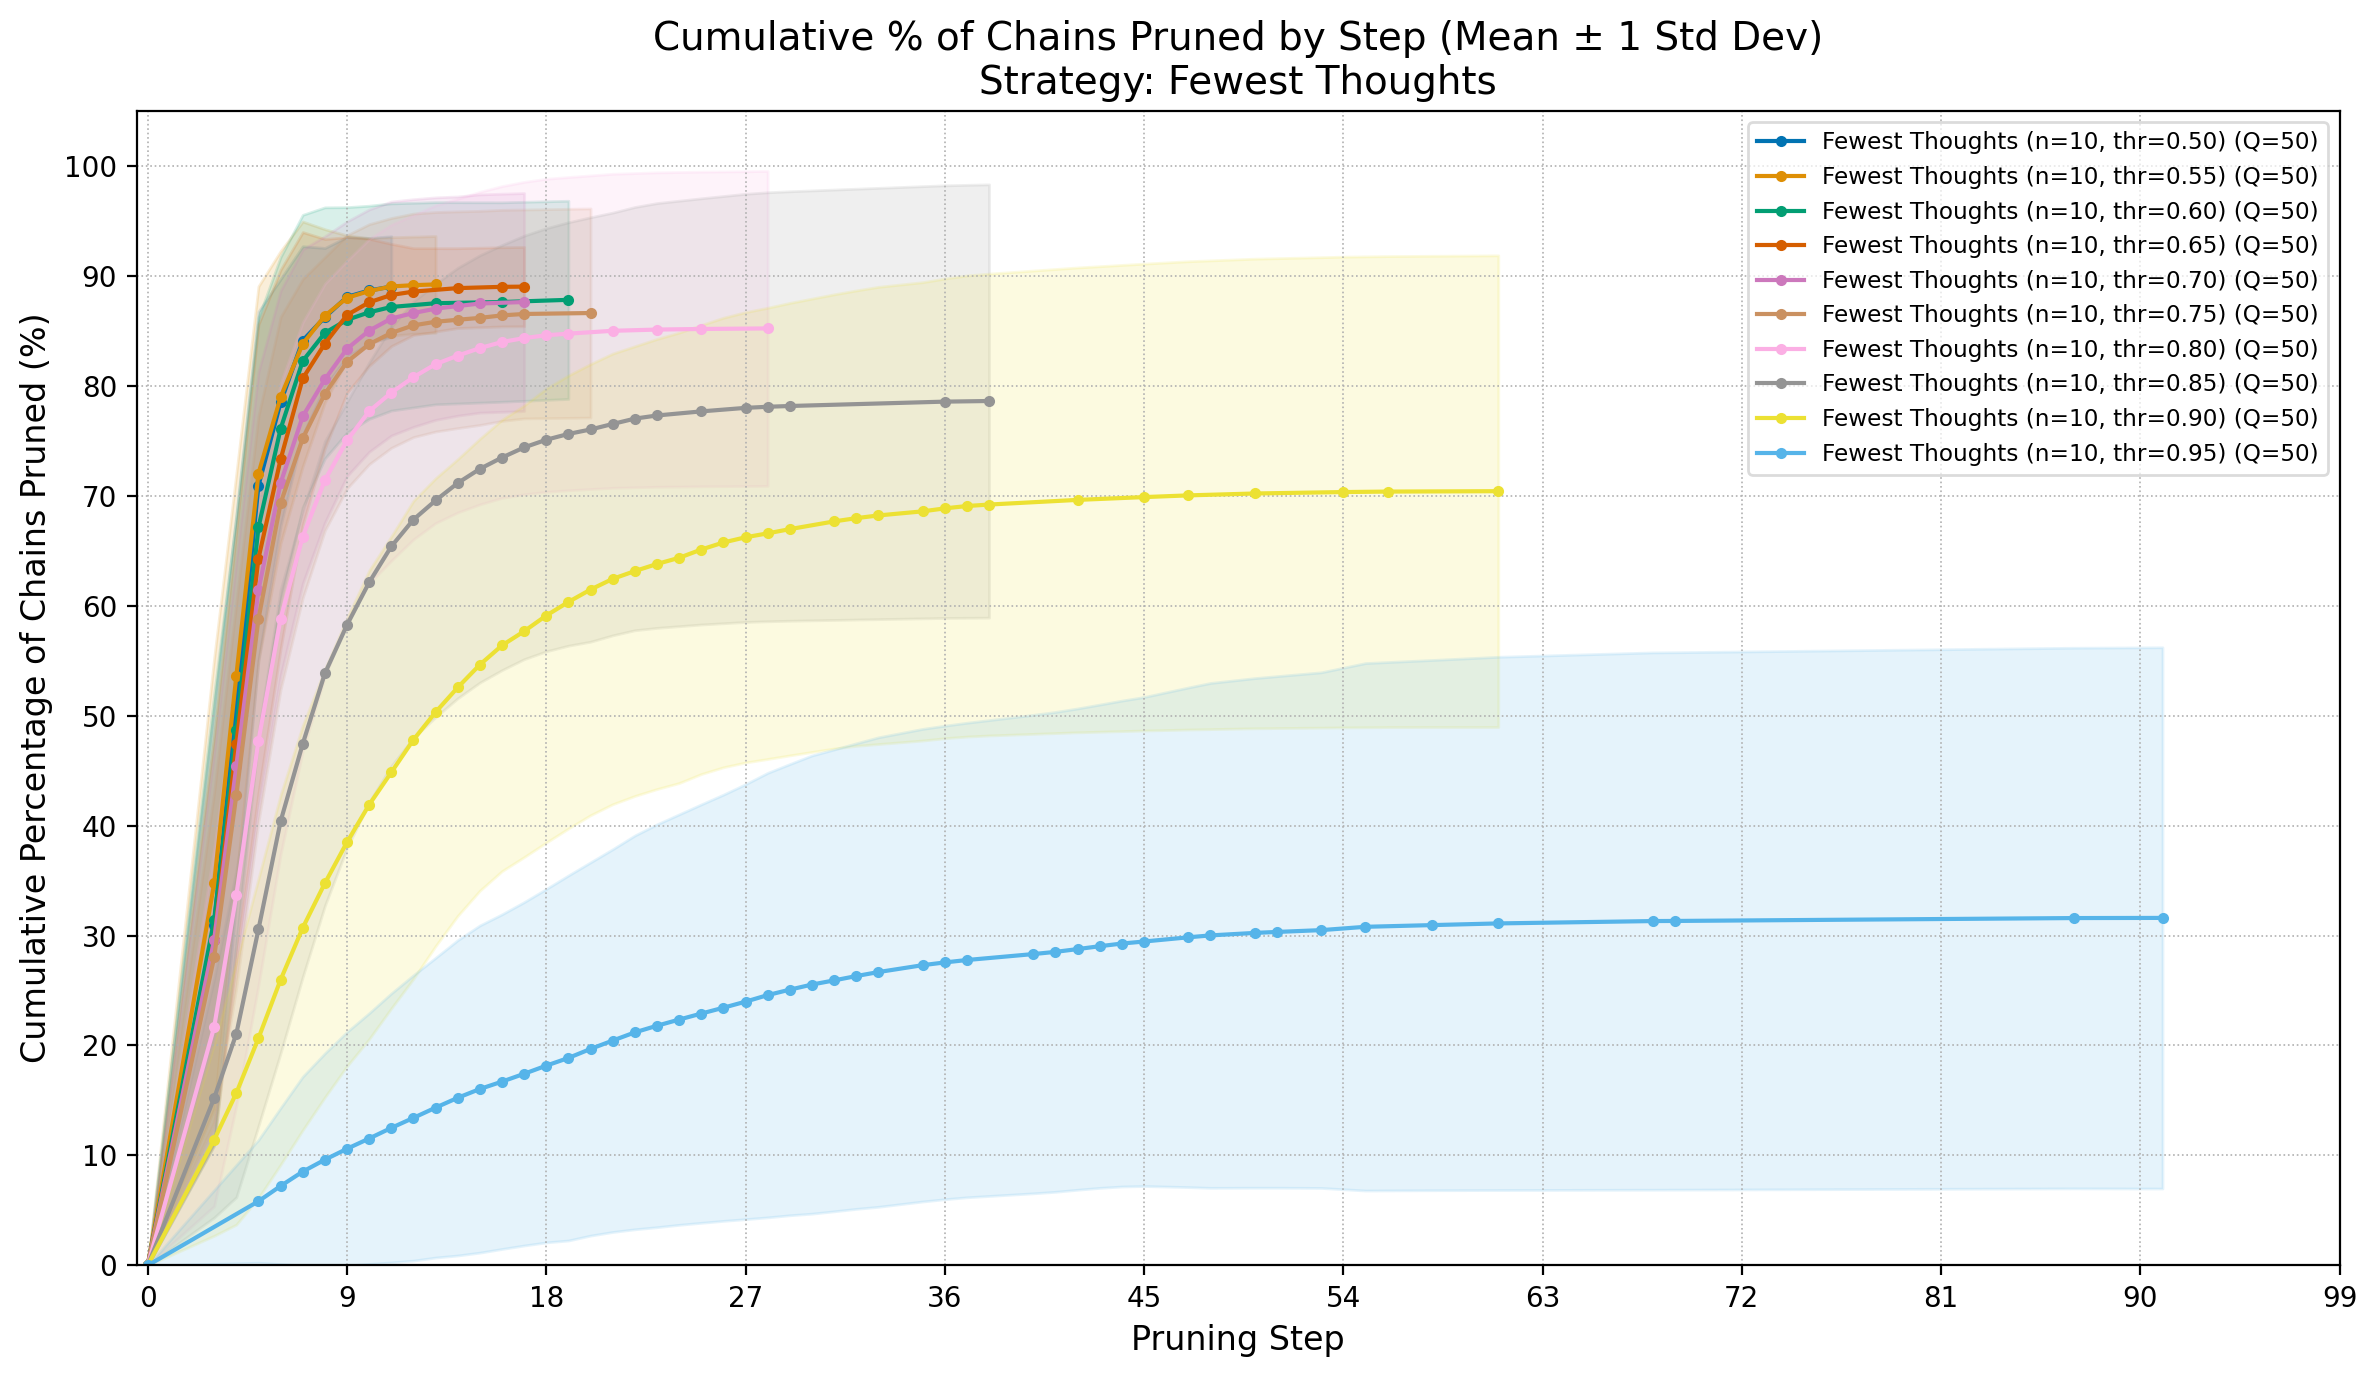


Generating Pruning CDF plot for strategy: Most Thoughts


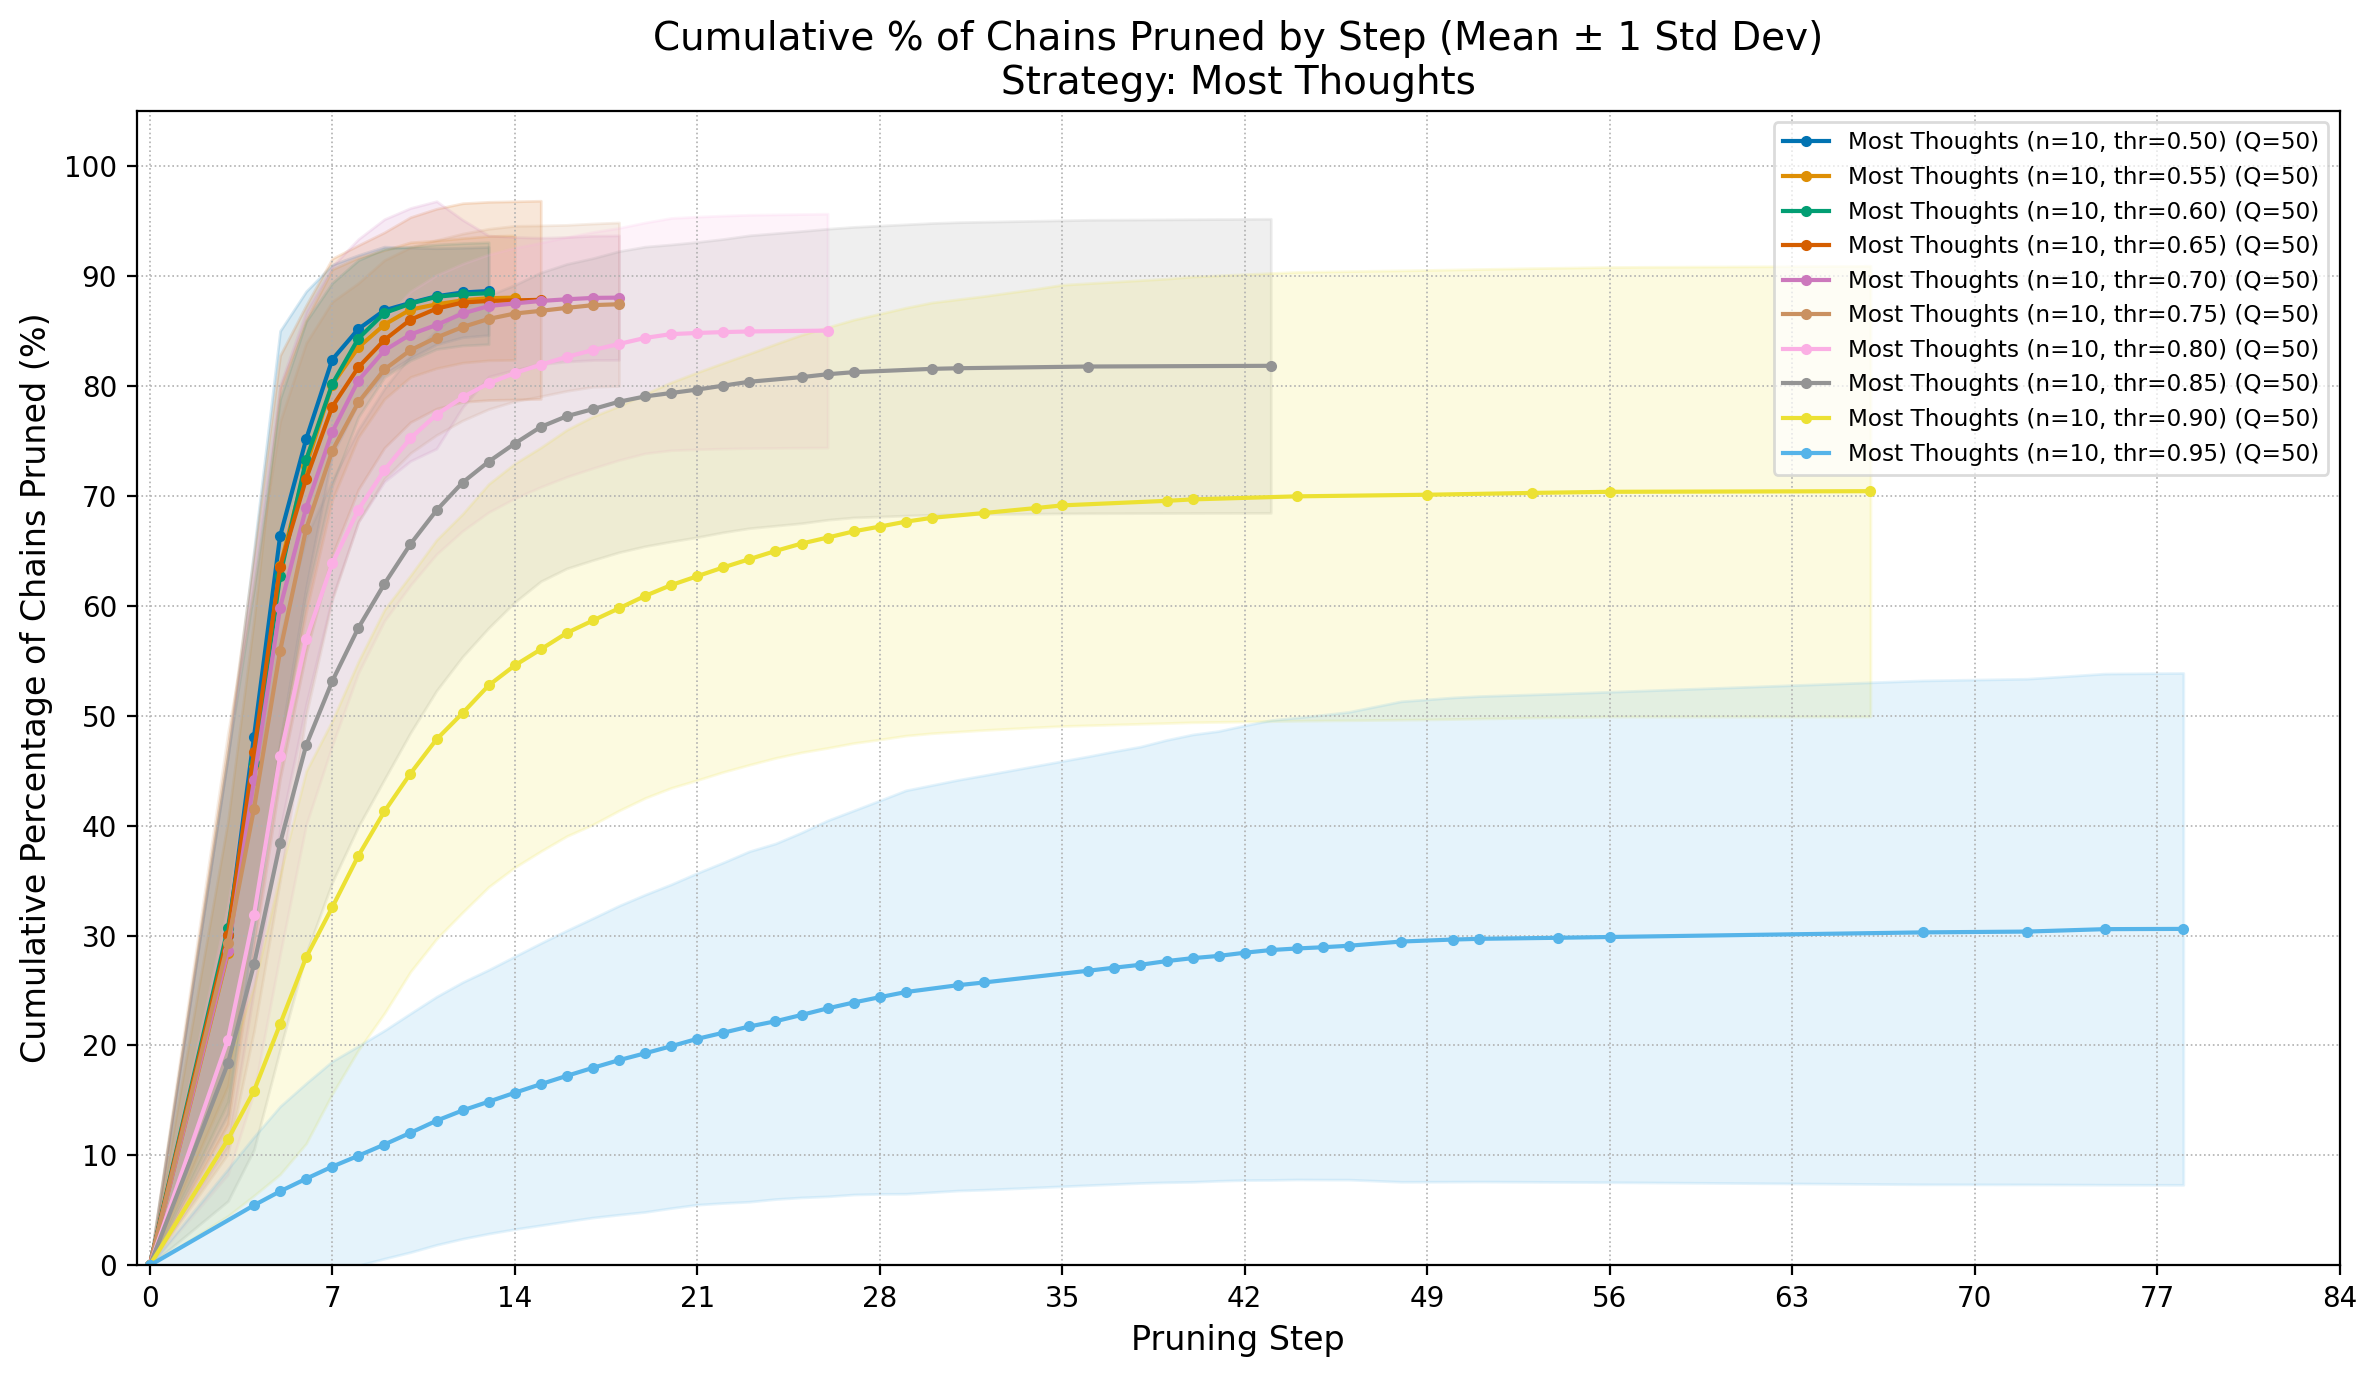


Generating Pruning CDF plot for strategy: Random


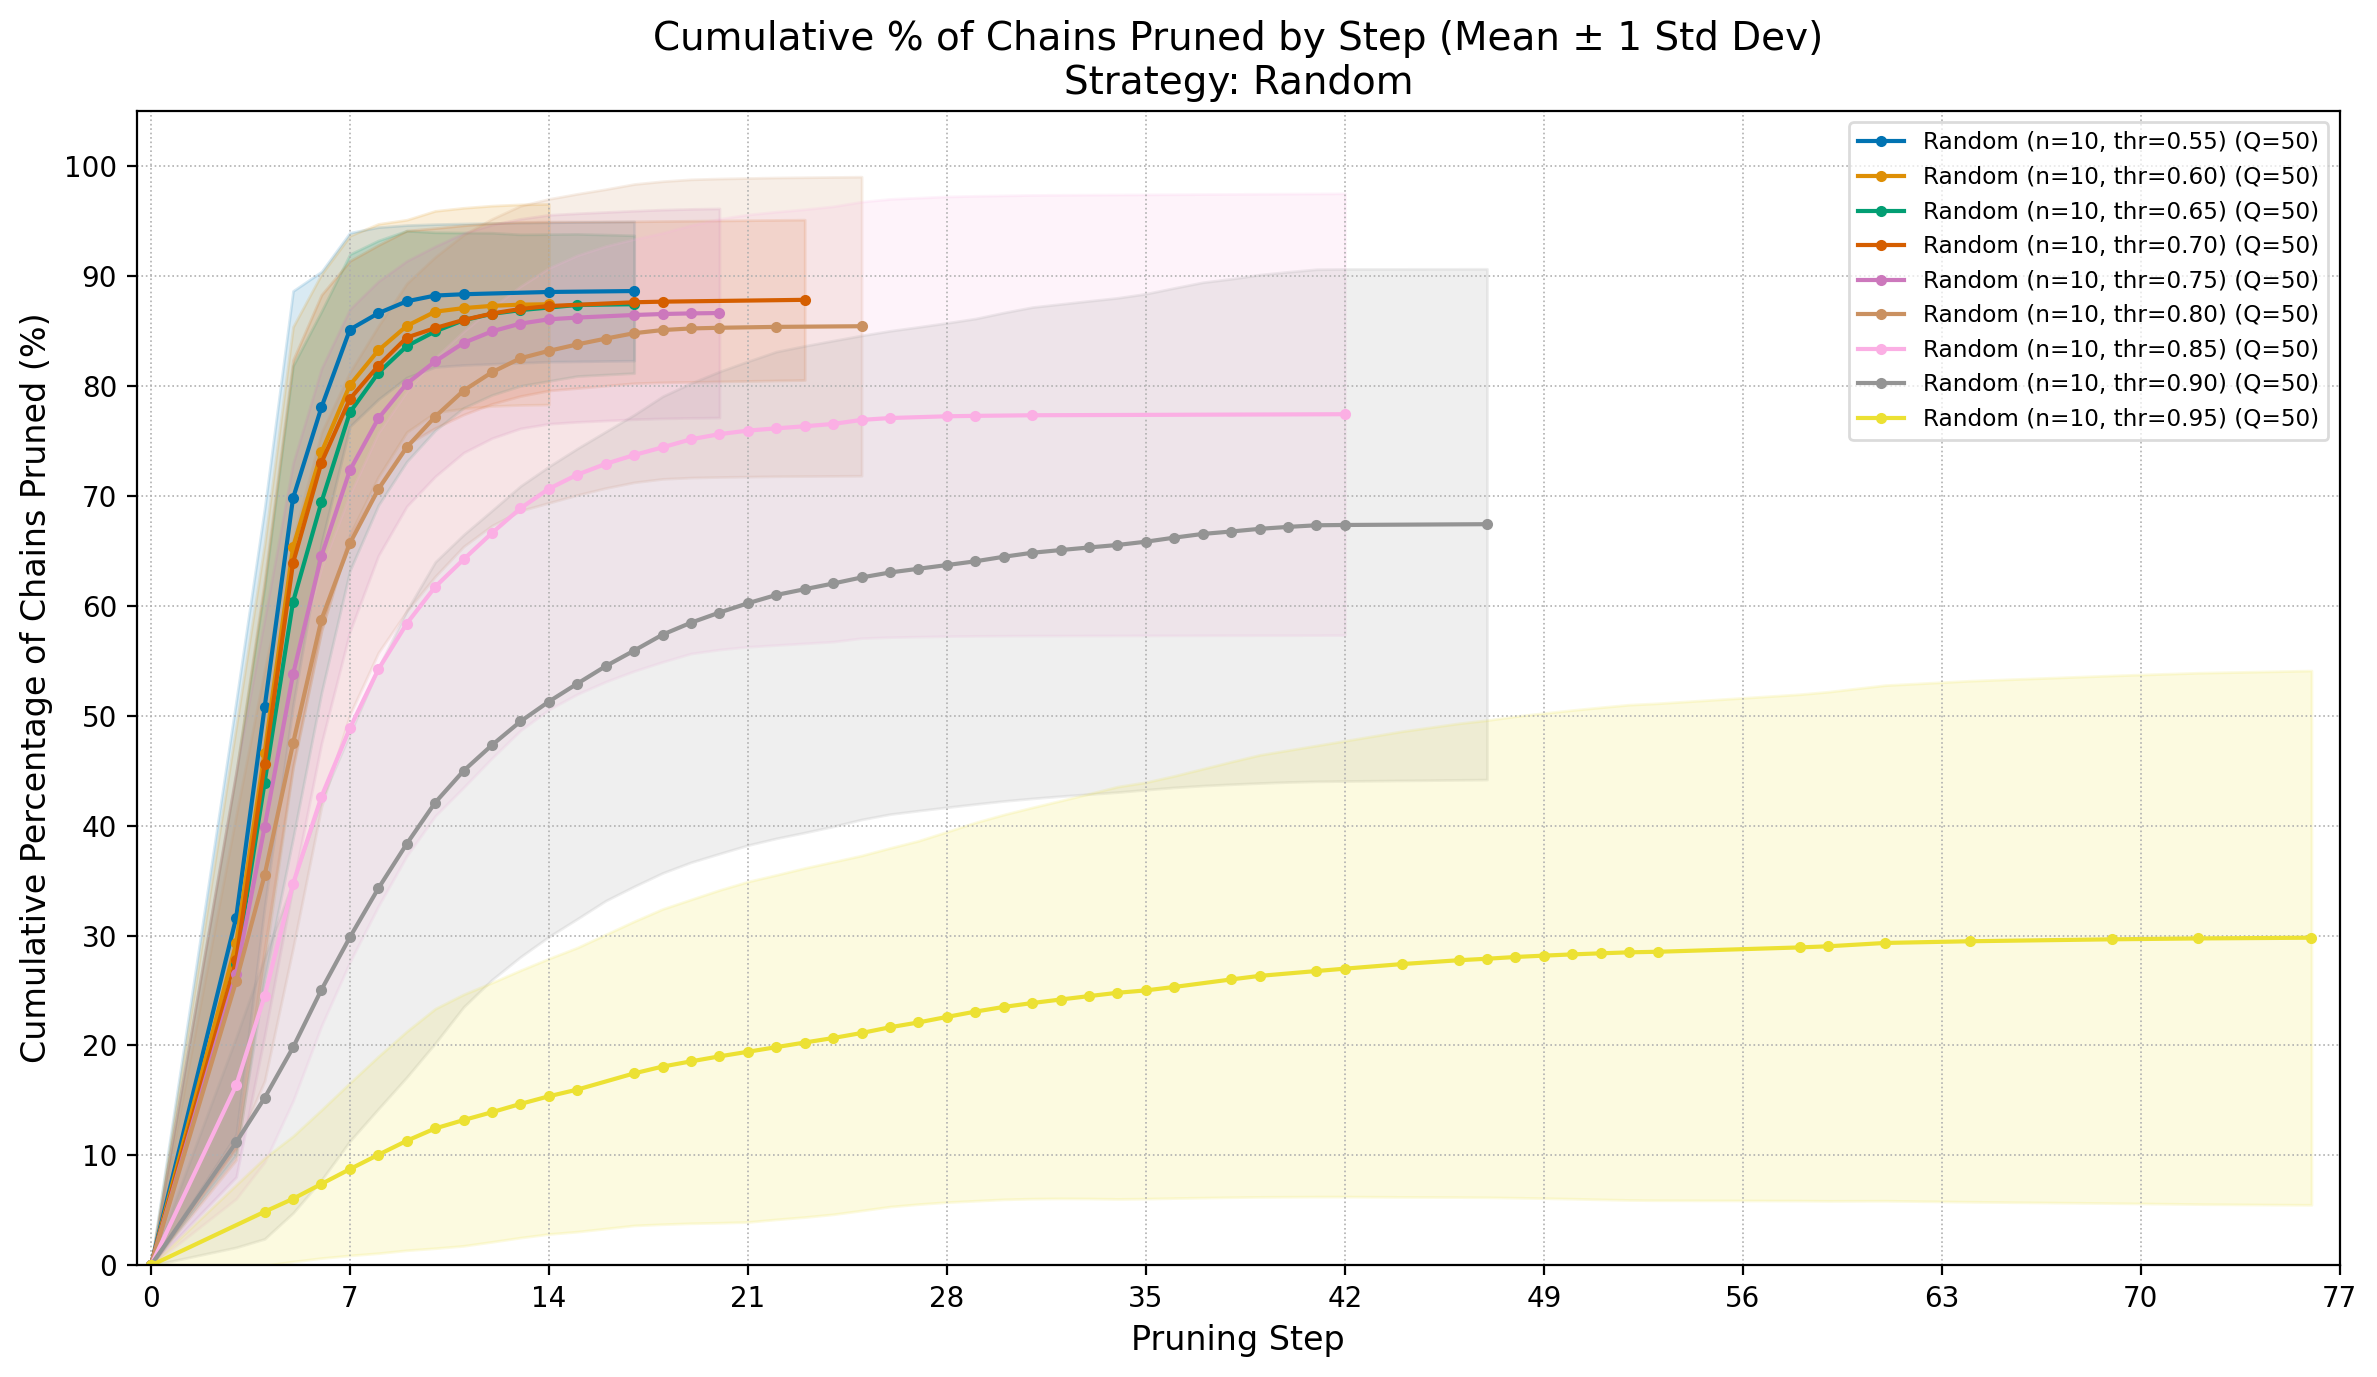


Finished Pruning CDF plots.


In [26]:
# Dictionary to hold data grouped by strategy
grouped_experiment_data = defaultdict(lambda: defaultdict(lambda: {'per_question_raw': [], 'details': {}}))
max_step_overall = 0 # Keep track of the max step across all experiments

if not PRUNING_RESULTS_BASE_DIR.is_dir():
    print(f"ERROR: Base results directory for pruning CDF not found. Skipping plot generation.")
else:
    # --- Data Aggregation Phase ---
    print("\n--- Aggregating data for Pruning CDF plots ---")
    for experiment_dir in sorted(PRUNING_RESULTS_BASE_DIR.iterdir()):
        if experiment_dir.is_dir():
            experiment_name = experiment_dir.name
            strategy, label = parse_experiment_name(experiment_name)
            if strategy is None:
                continue

            # print(f"\nProcessing experiment: {experiment_name} (Strategy: {strategy}, Label: {label})") # Quieter
            summaries_dir = experiment_dir / "summaries"
            if not summaries_dir.is_dir():
                # print(f"  -> Summaries directory not found: {summaries_dir}") # Quieter
                continue

            experiment_question_data = []
            experiment_all_pruned_steps_union = set()
            experiment_max_step = 0
            processed_files_count = 0

            json_files_found = list(summaries_dir.glob("question_*_summary.json"))
            if not json_files_found:
                # print(f"  -> No question summary JSON files found in {summaries_dir}") # Quieter
                continue

            for json_file in json_files_found:
                try:
                    with open(json_file, 'r') as f:
                        data = json.load(f)
                    n_start = data.get("n_chains_start", 0)
                    if n_start <= 0:
                        continue
                    processed_files_count += 1
                    question_pruned_steps = []
                    if "pruned_chain_details" in data:
                        for chain in data["pruned_chain_details"]:
                            if "pruned_at_step" in chain:
                                step = chain["pruned_at_step"]
                                question_pruned_steps.append(step)
                                experiment_all_pruned_steps_union.add(step)
                                experiment_max_step = max(experiment_max_step, step)
                                max_step_overall = max(max_step_overall, step)
                    experiment_question_data.append({
                        'n_start': n_start,
                        'pruned_steps': question_pruned_steps
                    })
                except Exception: # Catch all for file processing, make it quieter
                    # print(f"  -> Error processing file {json_file.name}: {e}")
                    pass # Fail silently for individual file errors

            if not experiment_question_data:
                 # print(f"  -> No valid question data found for experiment {experiment_name}.") # Quieter
                 continue
            # print(f"  -> Processed {processed_files_count} valid summary files for {experiment_name}.") # Quieter

            grouped_experiment_data[strategy][label]['per_question_raw'] = experiment_question_data
            grouped_experiment_data[strategy][label]['details']['all_steps_union'] = sorted(list(experiment_all_pruned_steps_union))
            grouped_experiment_data[strategy][label]['details']['max_step'] = experiment_max_step
            grouped_experiment_data[strategy][label]['details']['num_questions'] = len(experiment_question_data)

    # --- Calculation and Plotting Phase ---
    print("\n--- Calculating Statistics and Generating Pruning CDF Plots ---")
    for strategy, experiments in grouped_experiment_data.items():
        print(f"\nGenerating Pruning CDF plot for strategy: {strategy.replace('_', ' ').title()}")
        sorted_experiment_labels = sorted(experiments.keys())
        if not sorted_experiment_labels:
            print(f"  -> No experiments found for strategy '{strategy}'. Skipping.")
            continue

        plt.figure(figsize=(12, 7)) # Adjusted size
        group_max_step = 0

        for label in sorted_experiment_labels:
            exp_data = experiments[label]
            question_raw_data = exp_data['per_question_raw']
            details = exp_data['details']
            num_questions = details['num_questions']
            if num_questions == 0:
                continue
            common_steps = np.array([0] + details['all_steps_union'])
            current_exp_max_step = details['max_step']
            group_max_step = max(group_max_step, current_exp_max_step)
            interpolated_percentages = np.zeros((num_questions, len(common_steps)))

            for i, q_data in enumerate(question_raw_data):
                n_start = q_data['n_start']
                pruned_steps = q_data['pruned_steps']
                if n_start == 0:
                    interpolated_percentages[i, :] = np.nan
                    continue
                if not pruned_steps:
                    q_plot_steps = np.array([0, current_exp_max_step + 1 if current_exp_max_step > 0 else 1])
                    q_plot_percentages = np.array([0.0, 0.0])
                else:
                    step_counts = Counter(pruned_steps)
                    sorted_q_steps = sorted(step_counts.keys())
                    cumulative_counts = np.cumsum([step_counts[step] for step in sorted_q_steps])
                    cumulative_percentage = (cumulative_counts / n_start) * 100
                    q_plot_steps = np.array([0] + sorted_q_steps)
                    q_plot_percentages = np.array([0.0] + list(cumulative_percentage))
                    if q_plot_steps[-1] < current_exp_max_step and current_exp_max_step > 0 :
                         q_plot_steps = np.append(q_plot_steps, current_exp_max_step + 1)
                         q_plot_percentages = np.append(q_plot_percentages, q_plot_percentages[-1])
                if len(q_plot_steps) > 1:
                    interp_func = interpolate.interp1d(q_plot_steps, q_plot_percentages, kind='linear', bounds_error=False, fill_value=(q_plot_percentages[0], q_plot_percentages[-1]))
                    interpolated_percentages[i, :] = interp_func(common_steps)
                    interpolated_percentages[i, :] = np.clip(interpolated_percentages[i, :], 0, 100)
                elif len(q_plot_steps) == 1:
                    interpolated_percentages[i, :] = q_plot_percentages[0]
                else:
                     interpolated_percentages[i, :] = 0.0
            mean_percentages = np.nanmean(interpolated_percentages, axis=0) # Use nanmean
            std_dev_percentages = np.nanstd(interpolated_percentages, axis=0) # Use nanstd
            lower_band = np.maximum(0, mean_percentages - std_dev_percentages)
            upper_band = np.minimum(100, mean_percentages + std_dev_percentages)
            exp_data['stats'] = {
                'common_steps': common_steps, 'mean': mean_percentages,
                'lower': lower_band, 'upper': upper_band, 'num_questions': num_questions
            }
        # Colors for plotting
        # Use a perceptually uniform colormap if many lines
        num_lines = len([label for label in sorted_experiment_labels if 'stats' in experiments[label]])
        if num_lines == 0: continue # No data to plot for this strategy
        
        # colors = sns.color_palette('viridis', n_colors=max(1, num_lines)) # Ensure at least 1 color
        # Using 'colorblind' is often a good choice for accessibility
        colors = sns.color_palette('colorblind', n_colors=max(1, num_lines))


        plot_idx = 0
        for label in sorted_experiment_labels:
            if 'stats' not in experiments[label]:
                continue
            stats = experiments[label]['stats']
            color = colors[plot_idx % len(colors)] # Cycle through colors
            plot_idx += 1

            line, = plt.plot(stats['common_steps'], stats['mean'], marker='.', linestyle='-', label=f"{label} (Q={stats['num_questions']})", color=color, linewidth=1.5)
            if np.any(stats['upper'] > stats['lower']) and stats['num_questions'] > 1:
                 plt.fill_between(stats['common_steps'], stats['lower'], stats['upper'], alpha=0.15, color=line.get_color())

        plt.title(f"Cumulative % of Chains Pruned by Step (Mean ± 1 Std Dev)\nStrategy: {strategy.replace('_', ' ').title()}", fontsize=14)
        plt.xlabel("Pruning Step", fontsize=12)
        plt.ylabel("Cumulative Percentage of Chains Pruned (%)", fontsize=12)
        plt.ylim(0, 105)
        current_xlim_right = max(10, group_max_step + 1 if group_max_step > 0 else 10)
        plt.xlim(left=-0.5, right=current_xlim_right) # Start x-axis slightly before 0
        plt.grid(True, which='both', linestyle=':', linewidth=0.6)
        tick_step_x = max(1, int(current_xlim_right / 10)) # Dynamic x-tick step
        plt.xticks(np.arange(0, current_xlim_right + tick_step_x, step=tick_step_x))
        plt.yticks(np.arange(0, 101, 10))
        plt.legend(loc='best', fontsize='small', frameon=True, facecolor='white', framealpha=0.7)
        plt.tight_layout()
        plt.show()

    print("\nFinished Pruning CDF plots.")

In [10]:
# Base directory for experiments (same as pruning CDF, as kvcache_usages is inside each experiment dir)
KVCACHE_RESULTS_BASE_DIR = PRUNING_RESULTS_BASE_DIR # Using the same base directory
TIME_STEP_SECONDS = 3 # Each step is 3 seconds

print(f"KV-Cache CDF Plot: Base results directory set to: {KVCACHE_RESULTS_BASE_DIR}")
if not KVCACHE_RESULTS_BASE_DIR.is_dir():
    print(f"WARNING: KV-Cache results directory NOT FOUND at {KVCACHE_RESULTS_BASE_DIR}")

# Store KV cache data: { 'strategy_key': { 'experiment_label': {'usages_by_step': [], 'max_time_step': 0, 'num_questions': 0} }, ... }
grouped_kvcache_data = defaultdict(lambda: defaultdict(lambda: {'usages_by_step': [], 'max_time_step': 0, 'num_questions': 0}))

KV-Cache CDF Plot: Base results directory set to: /home/users/ntu/chong032/slimsc/prune/results/R1-Distill-Qwen-14B/gpqa_diamond


In [11]:
def load_and_process_kvcache_csv(filepath: Path, time_step_duration: float) -> Optional[Dict[int, float]]:
    """
    Loads a KV-cache CSV, converts timestamps to time steps, and gets max usage per step.
    Returns a dictionary: {time_step: max_gpu_cache_usage_perc_in_step}
    """
    try:
        df = pd.read_csv(filepath)
        if df.empty:
            return None
        if not {'timestamp', 'gpu_cache_usage_perc'}.issubset(df.columns):
            # print(f"  -> Missing required columns in {filepath.name}") # Quieter
            return None

        df = df.dropna(subset=['timestamp', 'gpu_cache_usage_perc'])
        if df.empty:
            return None

        # Convert to numeric, coercing errors
        df['timestamp'] = pd.to_numeric(df['timestamp'], errors='coerce')
        df['gpu_cache_usage_perc'] = pd.to_numeric(df['gpu_cache_usage_perc'], errors='coerce')
        df = df.dropna() # Drop rows where conversion failed

        if df.empty:
            return None

        start_time = df['timestamp'].min()
        df['time_elapsed'] = df['timestamp'] - start_time
        df['time_step'] = (df['time_elapsed'] // time_step_duration).astype(int)

        # Get the maximum usage within each time step
        usage_per_step = df.groupby('time_step')['gpu_cache_usage_perc'].max().to_dict()
        return usage_per_step
    except Exception as e:
        # print(f"  -> Error processing KV cache file {filepath.name}: {e}") # Quieter
        return None

# --- Data Aggregation for KV Cache ---
if KVCACHE_RESULTS_BASE_DIR.is_dir():
    print("\n--- Aggregating data for KV-Cache Usage plots ---")
    for experiment_dir in sorted(KVCACHE_RESULTS_BASE_DIR.iterdir()):
        if experiment_dir.is_dir():
            experiment_name = experiment_dir.name
            strategy, label = parse_experiment_name(experiment_name) # Re-use parsing
            if strategy is None:
                continue

            # print(f"\nProcessing KV-Cache for experiment: {experiment_name}") # Quieter
            kvcache_dir = experiment_dir / "kvcache_usages"
            if not kvcache_dir.is_dir():
                # print(f"  -> kvcache_usages directory not found: {kvcache_dir}") # Quieter
                continue

            question_kv_usages = [] # List of dictionaries [ {step: usage}, {step: usage}, ... ] for each question
            current_exp_max_step = 0
            num_valid_kv_files = 0

            for csv_file in kvcache_dir.glob("question_*_kvcache_usage.csv"):
                usage_dict = load_and_process_kvcache_csv(csv_file, TIME_STEP_SECONDS)
                if usage_dict:
                    question_kv_usages.append(usage_dict)
                    num_valid_kv_files += 1
                    if usage_dict: # Check if not empty
                        current_exp_max_step = max(current_exp_max_step, max(usage_dict.keys(), default=-1))

            if question_kv_usages:
                grouped_kvcache_data[strategy][label]['usages_by_step'] = question_kv_usages
                grouped_kvcache_data[strategy][label]['max_time_step'] = current_exp_max_step
                grouped_kvcache_data[strategy][label]['num_questions'] = num_valid_kv_files
                # print(f"  -> Stored KV cache data for {num_valid_kv_files} questions. Max time step in exp: {current_exp_max_step}") # Quieter
            # else:
                # print(f"  -> No valid KV cache data found for experiment {experiment_name}.") # Quieter
else:
    print("Skipping KV-Cache data aggregation as base directory not found.")


--- Aggregating data for KV-Cache Usage plots ---



--- Generating KV-Cache Usage (CDF-like) Plots ---

Generating KV-Cache plot for strategy: Diversity


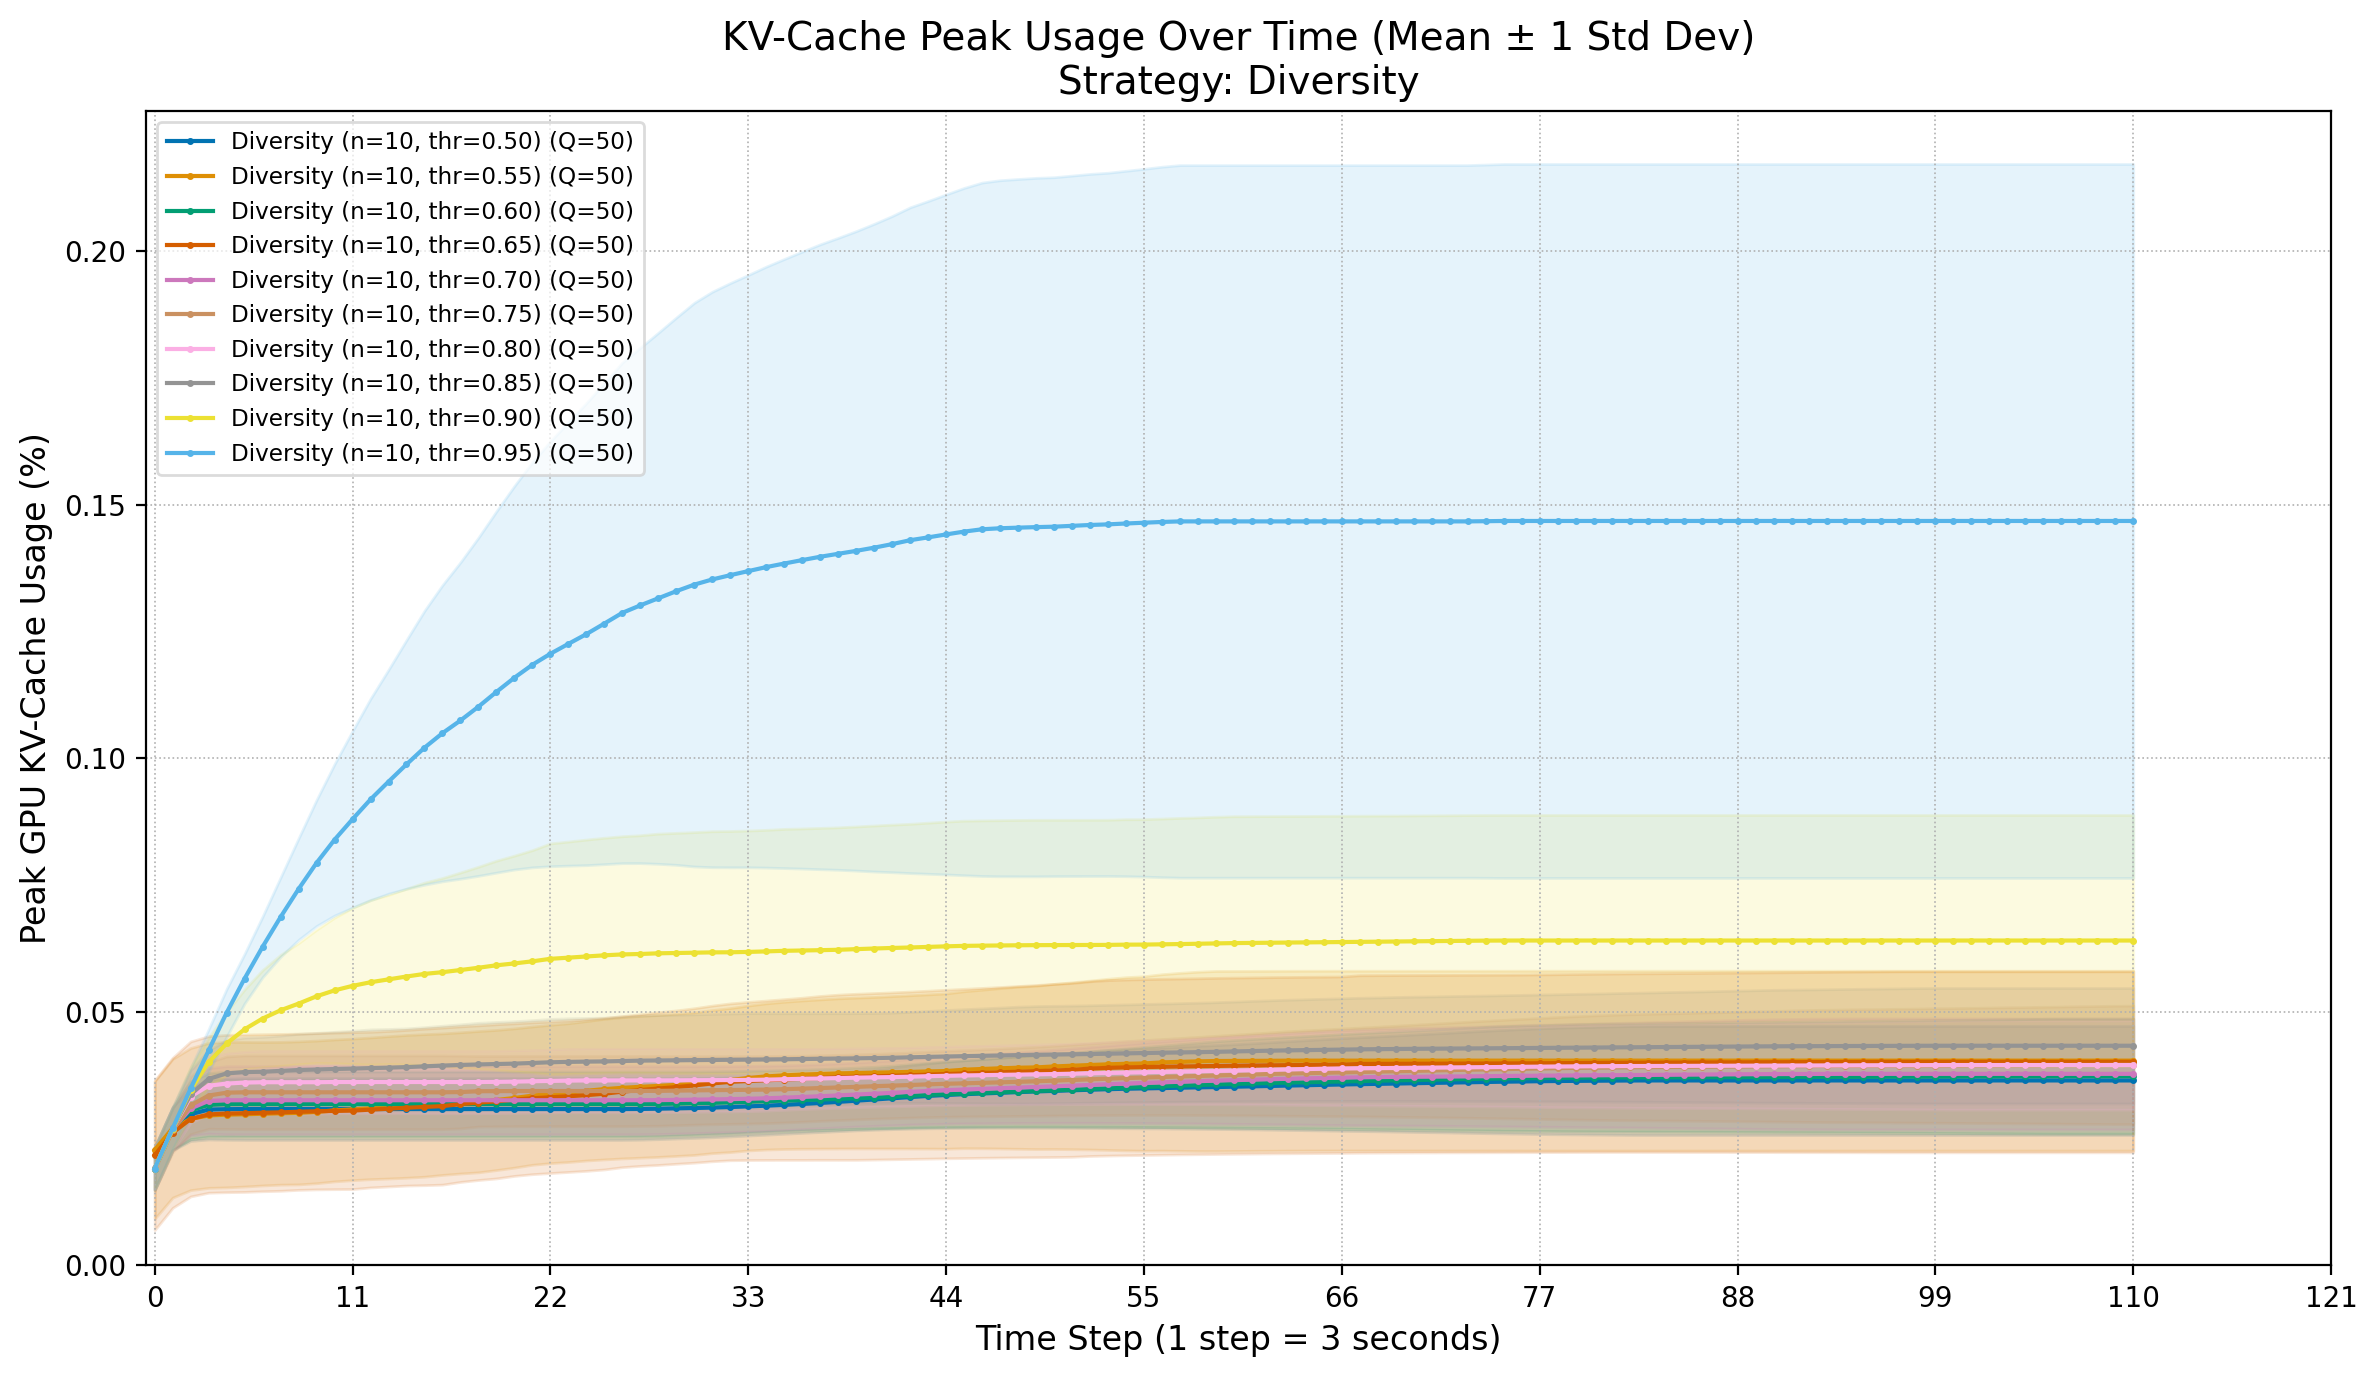


Generating KV-Cache plot for strategy: Fewest Thoughts


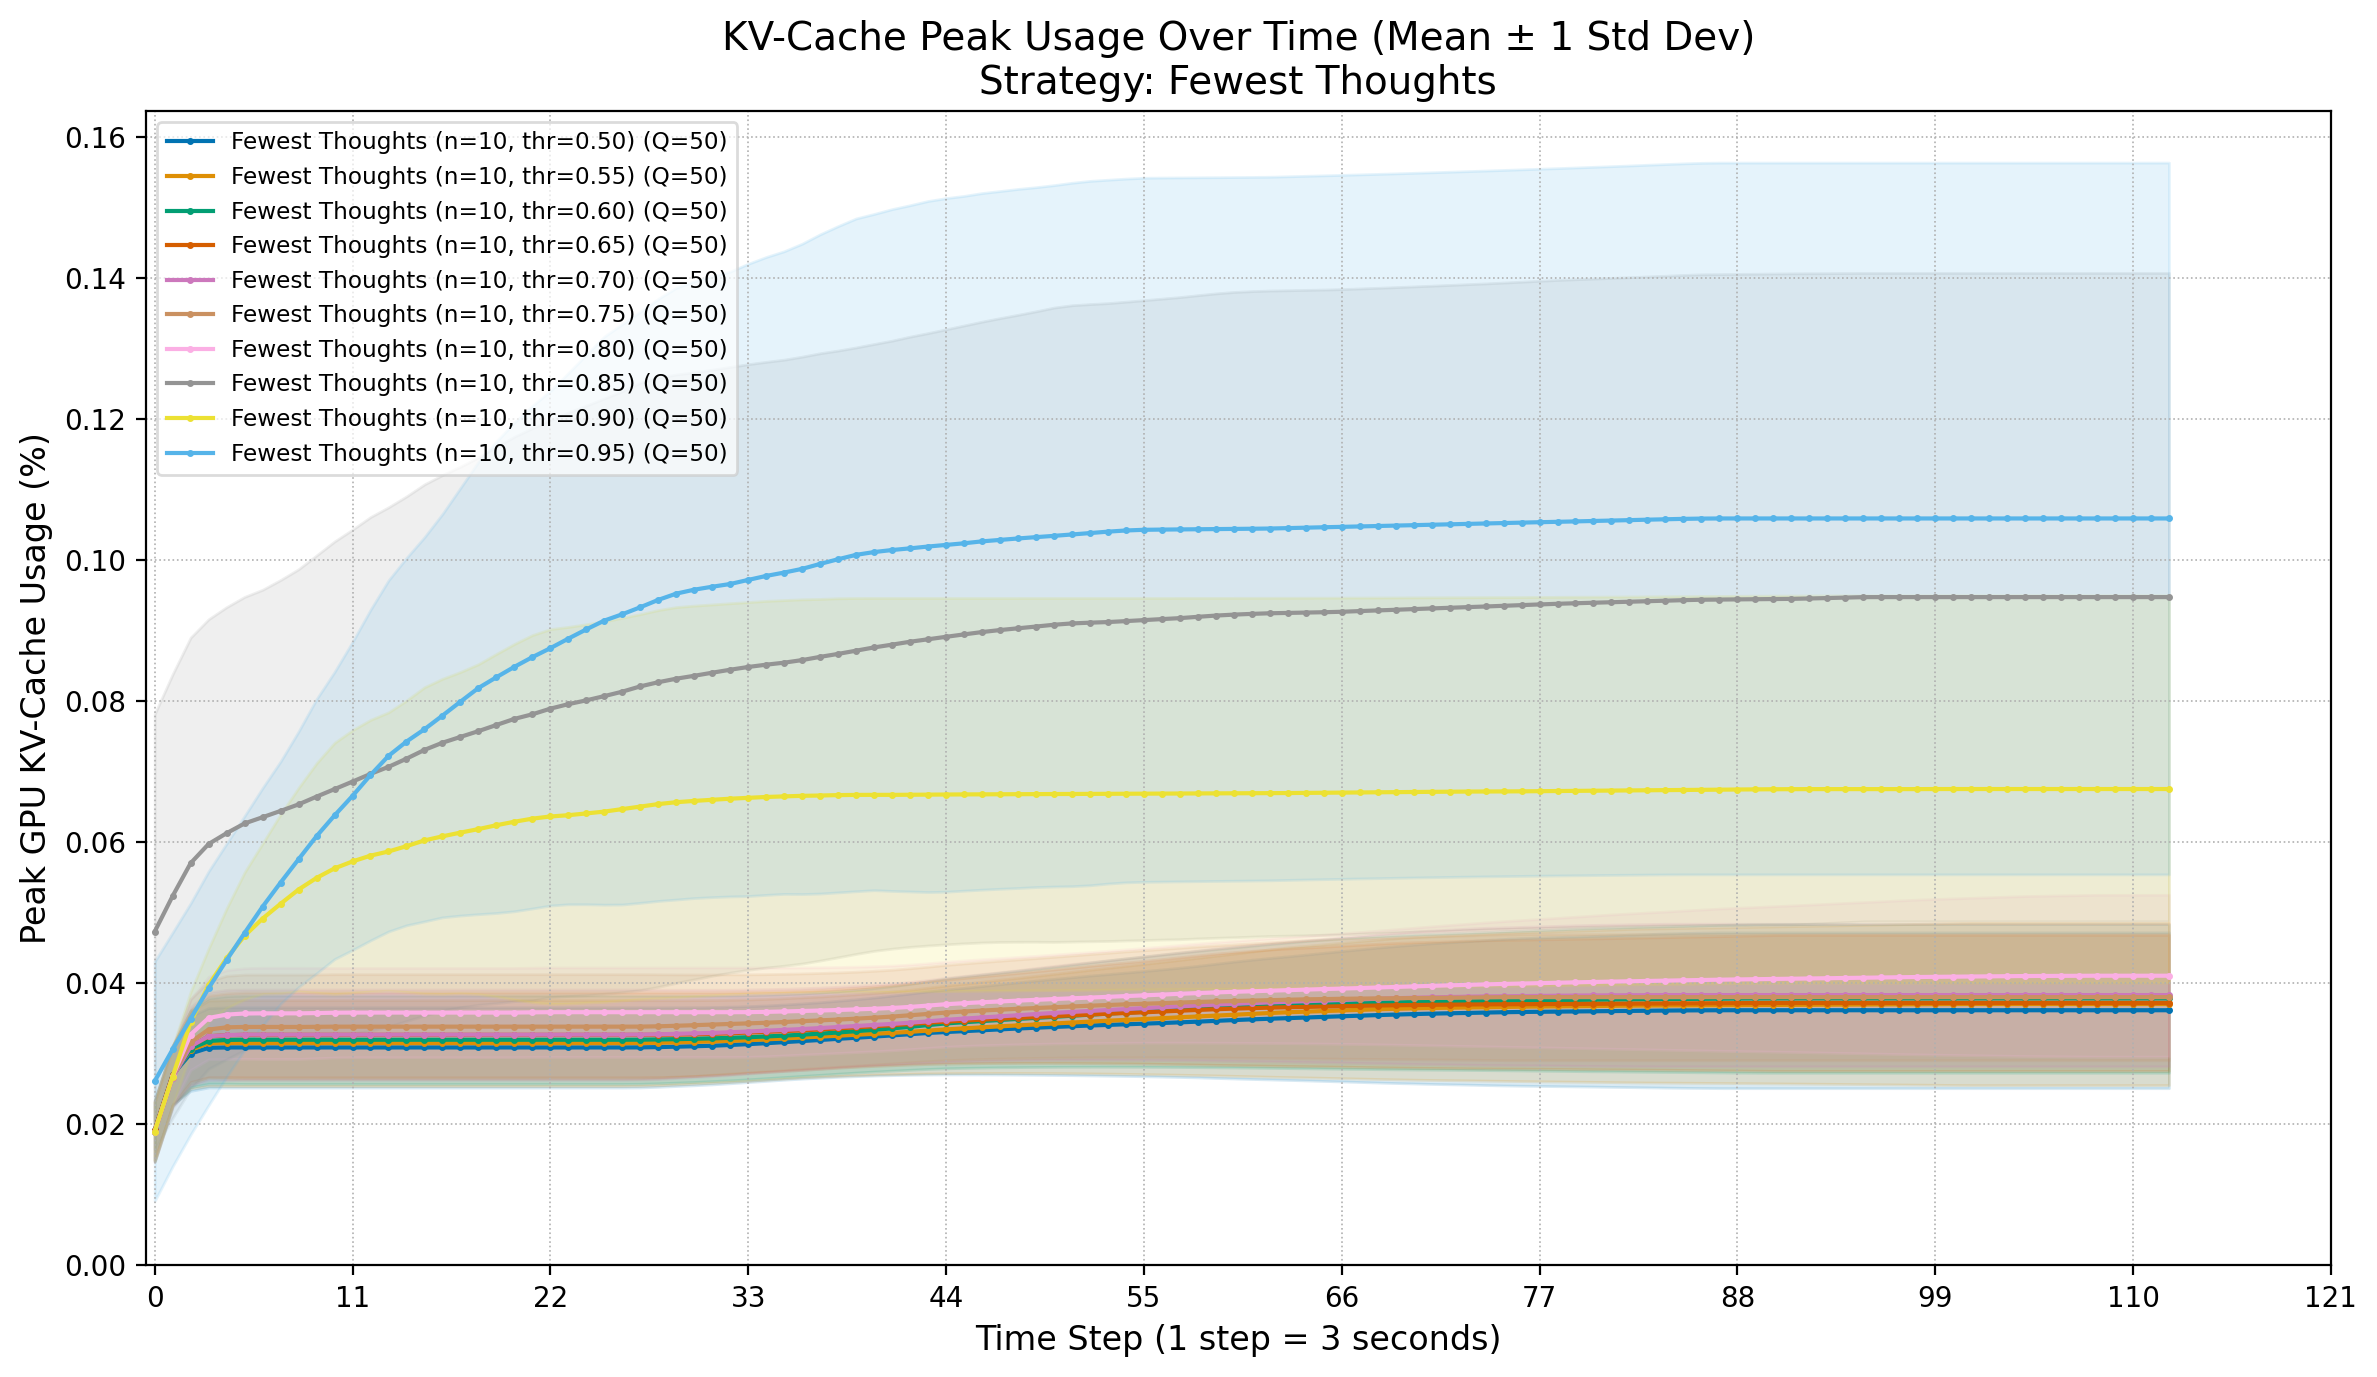


Generating KV-Cache plot for strategy: Most Thoughts


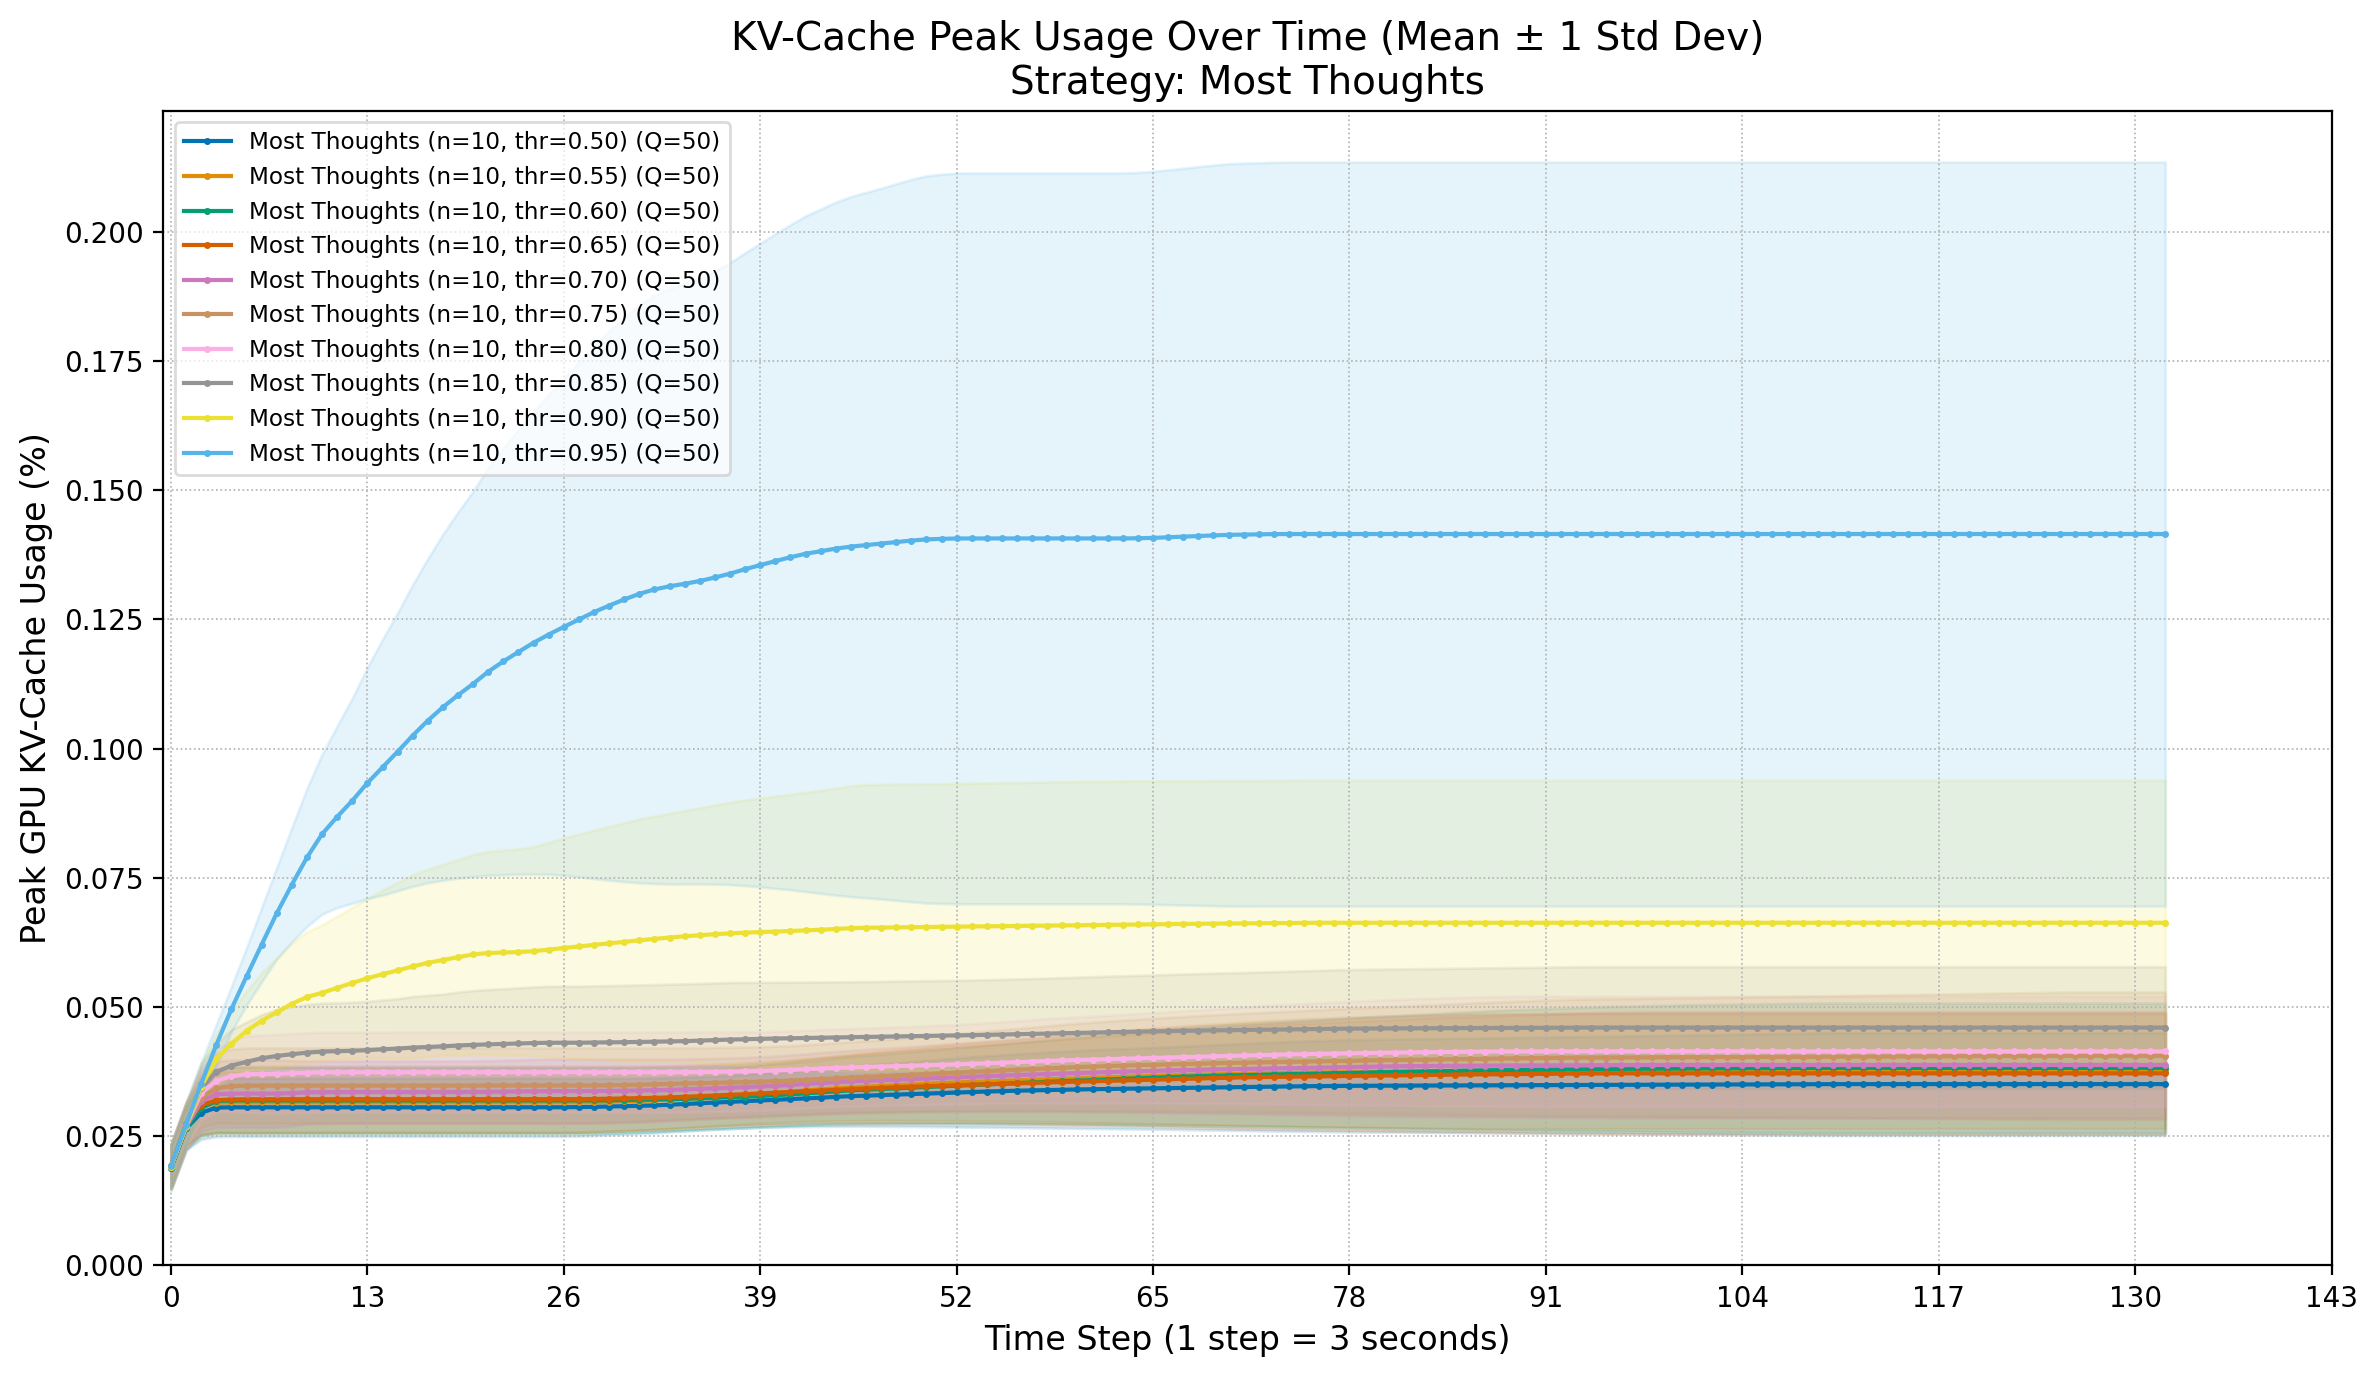


Generating KV-Cache plot for strategy: Random


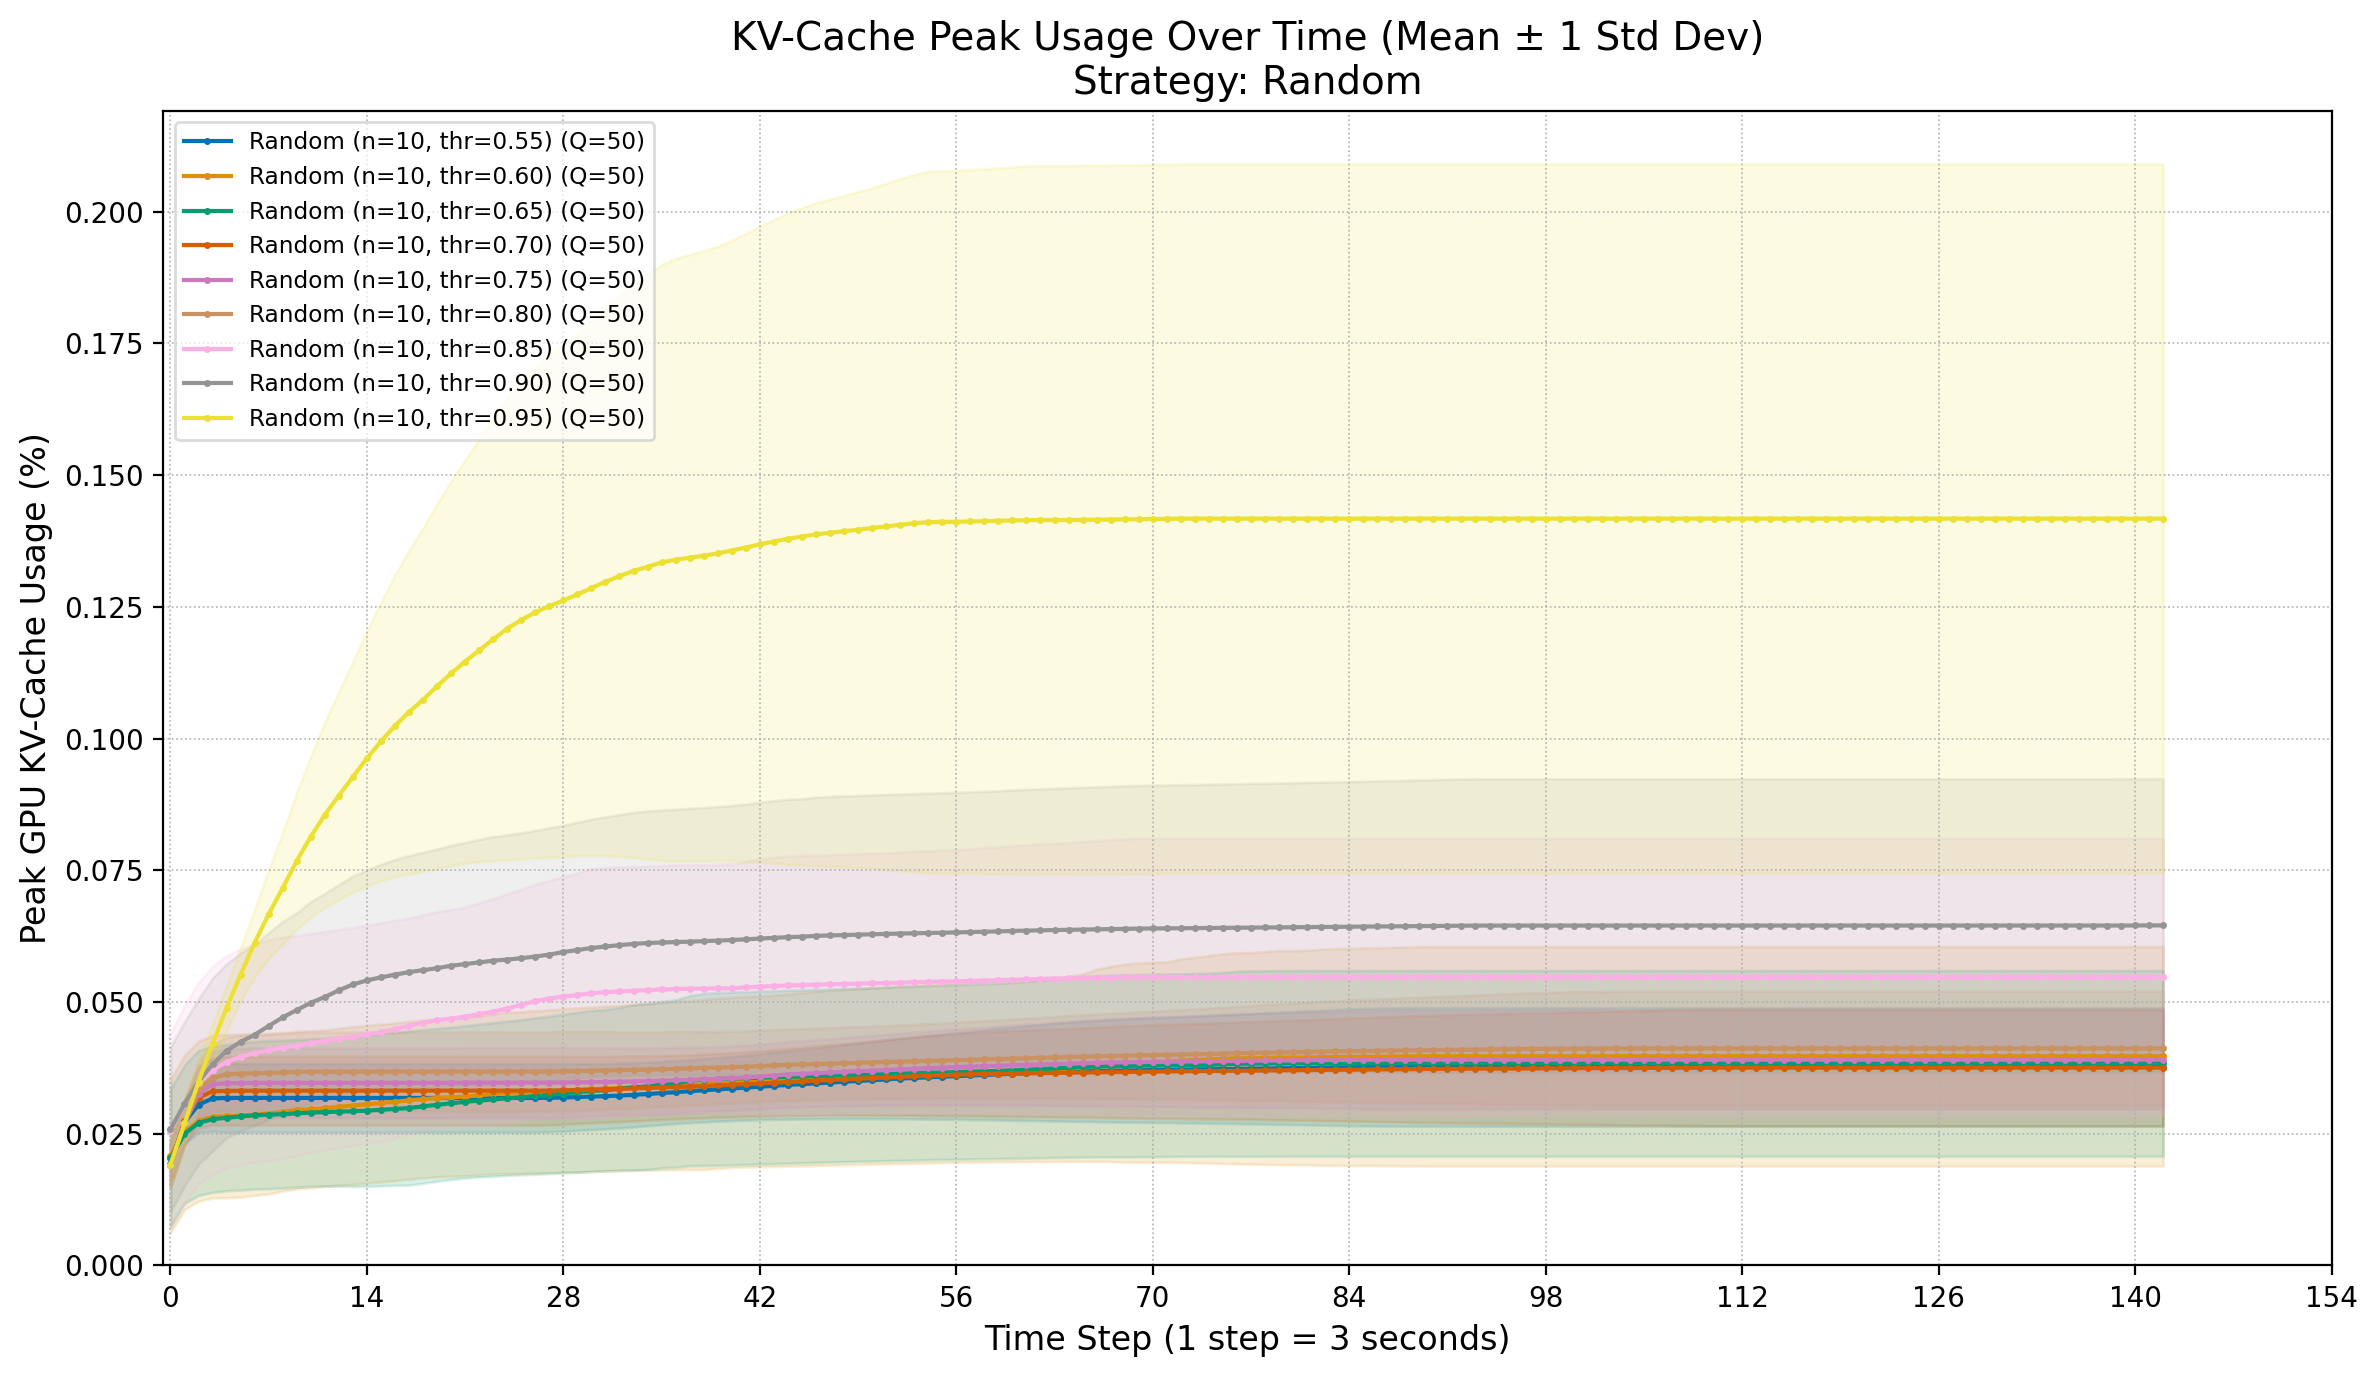


Generating KV-Cache plot for strategy: Sc Variants


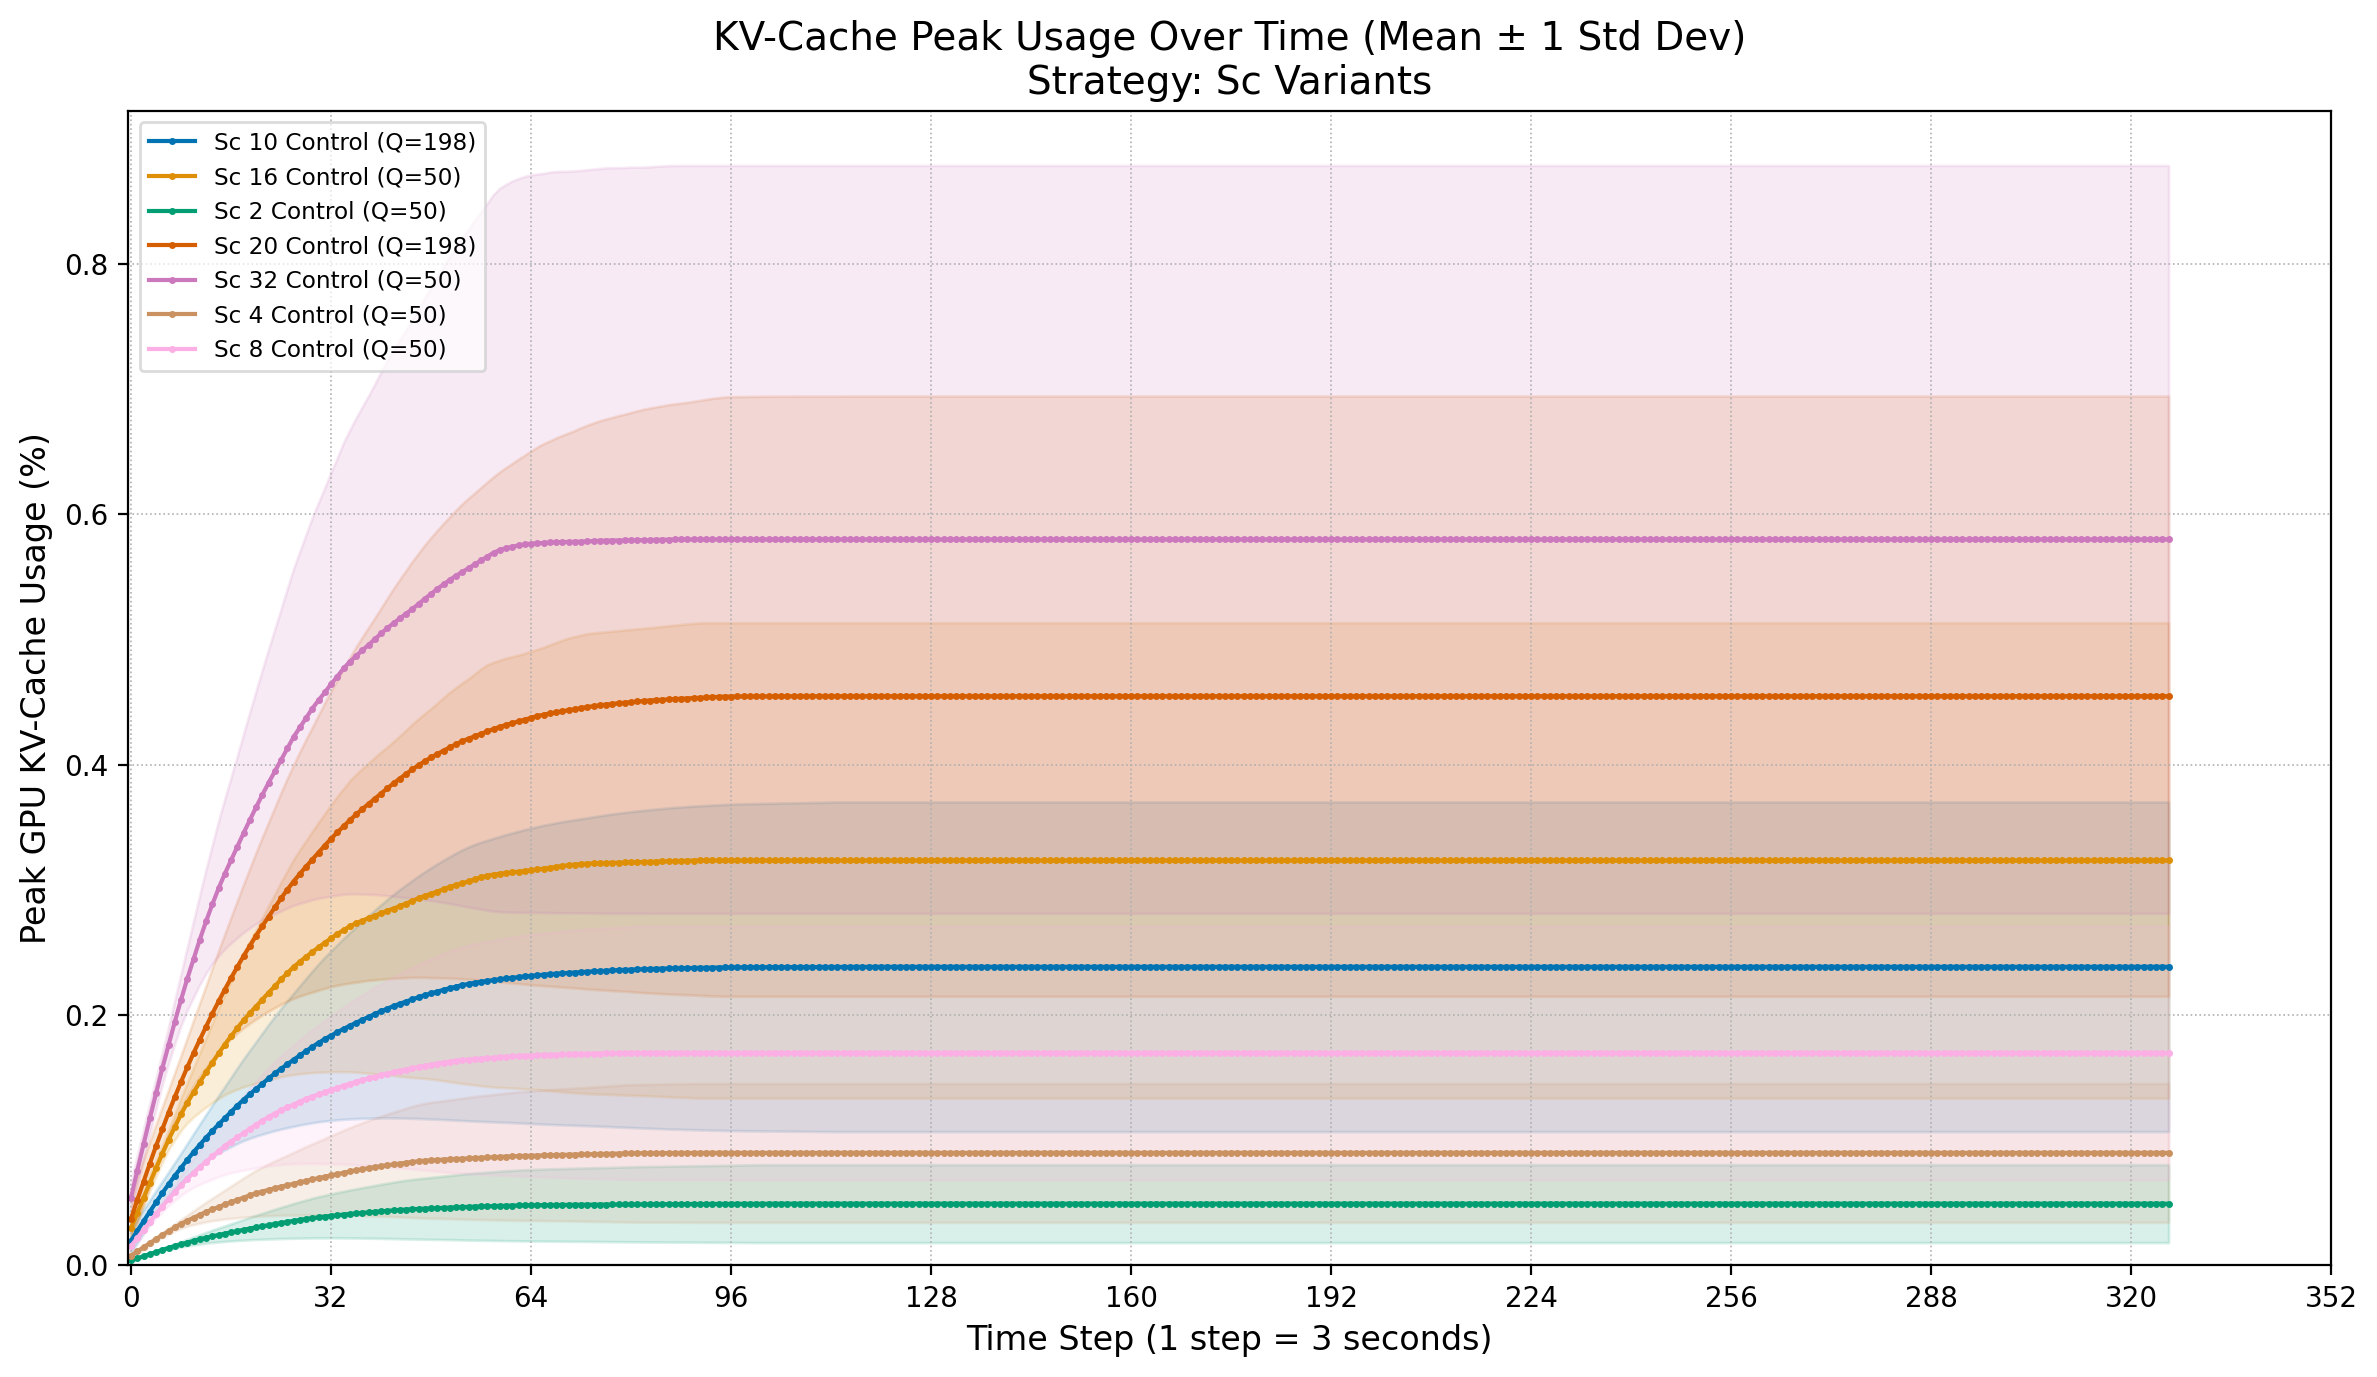


Finished KV-Cache CDF-like plots.


In [12]:
if not grouped_kvcache_data:
    print("No KV-Cache data aggregated. Skipping KV-Cache CDF plots.")
else:
    print("\n--- Generating KV-Cache Usage (CDF-like) Plots ---")
    for strategy, experiments in grouped_kvcache_data.items():
        print(f"\nGenerating KV-Cache plot for strategy: {strategy.replace('_', ' ').title()}")
        sorted_experiment_labels = sorted(experiments.keys())
        if not sorted_experiment_labels:
            print(f"  -> No experiments with KV-cache data for strategy '{strategy}'. Skipping.")
            continue

        plt.figure(figsize=(12, 7))
        group_overall_max_step = 0 # Max step across all experiments in this strategy group

        # First pass to determine the overall max step for the plot x-axis for this strategy group
        for label in sorted_experiment_labels:
            if experiments[label]['num_questions'] > 0:
                 group_overall_max_step = max(group_overall_max_step, experiments[label]['max_time_step'])

        if group_overall_max_step < 0: group_overall_max_step = 0 # Ensure non-negative

        # Determine a common grid of time steps for interpolation for this strategy group
        # The grid should extend up to group_overall_max_step
        plot_time_steps = np.arange(0, group_overall_max_step + 1)

        # Colors for plotting
        num_lines = len([label for label in sorted_experiment_labels if experiments[label]['num_questions'] > 0])
        if num_lines == 0: continue
        colors = sns.color_palette('colorblind', n_colors=max(1, num_lines))
        
        plot_idx = 0
        for label in sorted_experiment_labels:
            exp_kv_data = experiments[label]
            num_q = exp_kv_data['num_questions']
            if num_q == 0:
                continue

            all_question_usages_on_grid = [] # Store [ [usages_at_step_0, ...], [usages_at_step_0, ...] ]

            for q_usage_dict in exp_kv_data['usages_by_step']:
                # For each question, create its usage array on the common 'plot_time_steps' grid
                # The value at each step should be the max usage *up to that step* (CDF-like behavior)
                q_usage_on_grid = np.zeros(len(plot_time_steps))
                current_max_usage_for_q = 0
                for i, t_step in enumerate(plot_time_steps):
                    if t_step in q_usage_dict:
                        current_max_usage_for_q = max(current_max_usage_for_q, q_usage_dict[t_step])
                    q_usage_on_grid[i] = current_max_usage_for_q # Assign the running max
                all_question_usages_on_grid.append(q_usage_on_grid)

            if not all_question_usages_on_grid:
                continue

            # Calculate mean and std dev across questions for this experiment
            all_question_usages_on_grid_np = np.array(all_question_usages_on_grid)
            mean_usage_curve = np.mean(all_question_usages_on_grid_np, axis=0)
            std_dev_usage_curve = np.std(all_question_usages_on_grid_np, axis=0)

            lower_band = np.maximum(0, mean_usage_curve - std_dev_usage_curve)
            upper_band = mean_usage_curve + std_dev_usage_curve # Max usage can exceed 100% if not normalized to a theoretical max

            color = colors[plot_idx % len(colors)]
            plot_idx +=1

            line, = plt.plot(plot_time_steps, mean_usage_curve, marker='.', markersize=3, linestyle='-', label=f"{label} (Q={num_q})", color=color, linewidth=1.5)
            if np.any(upper_band > lower_band) and num_q > 1:
                plt.fill_between(plot_time_steps, lower_band, upper_band, alpha=0.15, color=line.get_color())

        plt.title(f"KV-Cache Peak Usage Over Time (Mean ± 1 Std Dev)\nStrategy: {strategy.replace('_', ' ').title()}", fontsize=14)
        plt.xlabel(f"Time Step (1 step = {TIME_STEP_SECONDS} seconds)", fontsize=12)
        plt.ylabel("Peak GPU KV-Cache Usage (%)", fontsize=12)
        # Y-lim might need adjustment based on typical max usage.
        # If usage_perc is 0-1, then 0-105. If it's 0-100, then also 0-105.
        # If it can be > 100 (e.g., if it's a raw value not a system-wide percentage), adjust ylim.
        # Assuming 'gpu_cache_usage_perc' is indeed 0-100 or 0-1. If 0-1, multiply by 100 in load function or here.
        # For now, assuming it's already a percentage.
        plt.ylim(bottom=0) # Start y-axis at 0, let top be auto or set a reasonable max like 10 or 20 if usage is low.
        # plt.ylim(0, 20) # Example if max usage is usually low
        
        current_kv_xlim_right = max(10, group_overall_max_step + 1 if group_overall_max_step >=0 else 10)
        plt.xlim(left=-0.5, right=current_kv_xlim_right)

        tick_step_kv_x = max(1, int(current_kv_xlim_right / 10))
        plt.xticks(np.arange(0, current_kv_xlim_right + tick_step_kv_x, step=tick_step_kv_x))
        # Y-ticks depend on expected range. If it's 0-100%:
        # plt.yticks(np.arange(0, plt.gca().get_ylim()[1] + 10, 10))


        plt.grid(True, which='both', linestyle=':', linewidth=0.6)
        plt.legend(loc='best', fontsize='small', frameon=True, facecolor='white', framealpha=0.7)
        plt.tight_layout()
        plt.show()

    print("\nFinished KV-Cache CDF-like plots.")

--- Processing model: R1-Distill-Qwen-14B ---
Processed R1-Distill-Qwen-14B, sc_1: Found 198 rows. Accuracy = 0.5960
Processed R1-Distill-Qwen-14B, sc_2: Found 198 rows. Accuracy = 0.5505
Processed R1-Distill-Qwen-14B, sc_8: Found 198 rows. Accuracy = 0.6313
Processed R1-Distill-Qwen-14B, sc_16: Found 198 rows. Accuracy = 0.6061
Processed R1-Distill-Qwen-14B, sc_32: Found 198 rows. Accuracy = 0.6162
Processed R1-Distill-Qwen-14B, sc_64: Found 198 rows. Accuracy = 0.6364
--- Processing model: QwQ-32B ---
Processed QwQ-32B, sc_1: Found 198 rows. Accuracy = 0.6313
Processed QwQ-32B, sc_2: Found 198 rows. Accuracy = 0.6212
Processed QwQ-32B, sc_8: Found 198 rows. Accuracy = 0.6515
Processed QwQ-32B, sc_16: Found 198 rows. Accuracy = 0.6818
Processed QwQ-32B, sc_32: Found 198 rows. Accuracy = 0.6717

--- Calculated Accuracies ---
              model sc_label  accuracy
R1-Distill-Qwen-14B     sc_1  0.595960
            QwQ-32B     sc_1  0.631313
R1-Distill-Qwen-14B     sc_2  0.550505
       

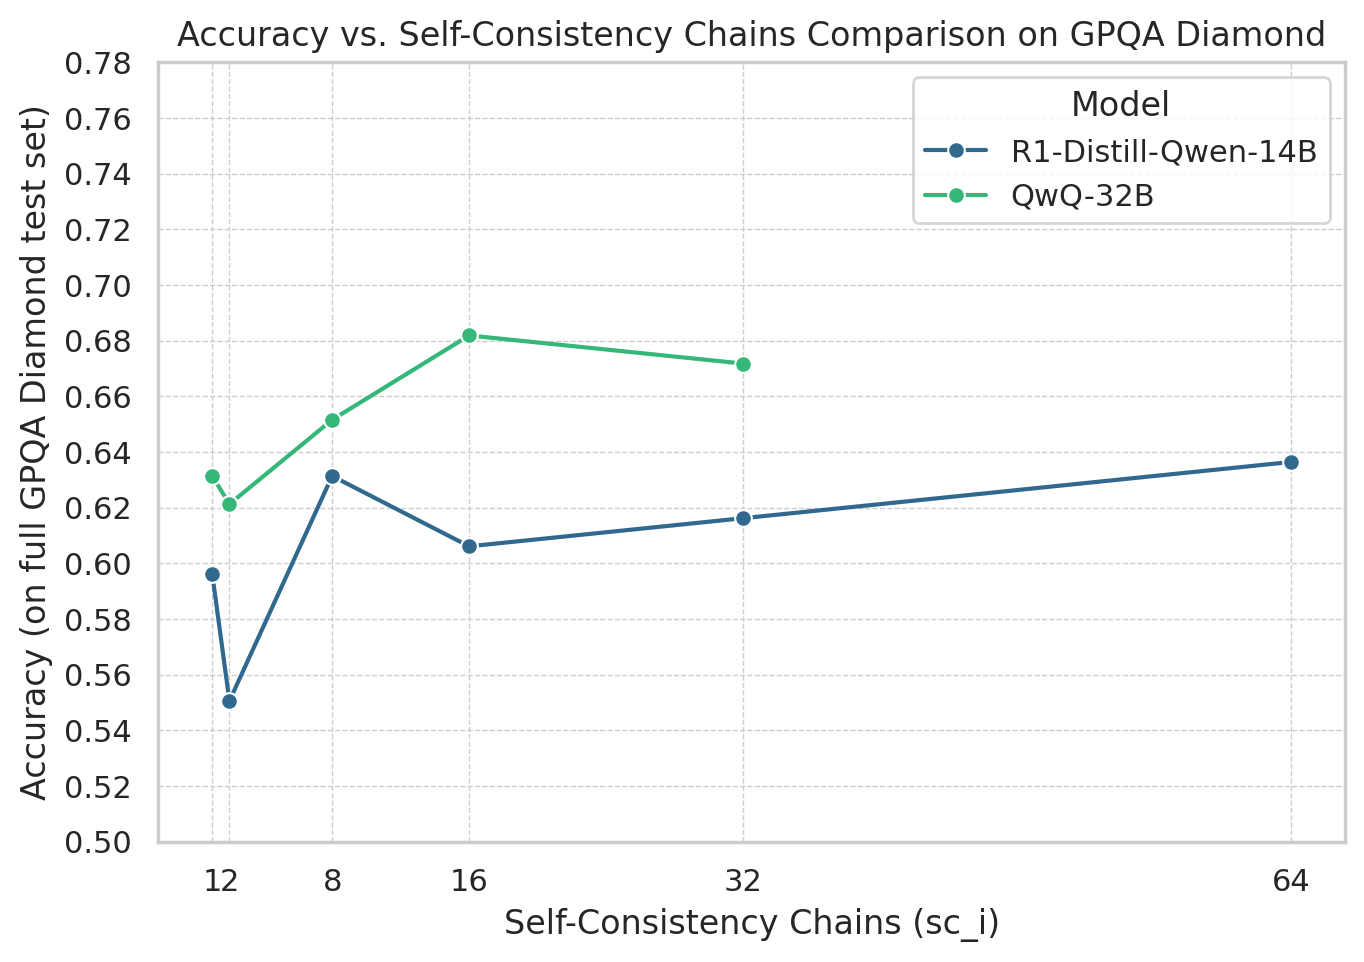

In [9]:
# Configure matplotlib for better display in notebooks
%matplotlib inline 
%config InlineBackend.figure_format = 'retina' # For higher resolution plots

import pandas as pd
import matplotlib.pyplot as plt
import os
import seaborn as sns # For nicer plots
import numpy as np

# --- Configuration for Data Loading ---

# Define the models and their respective base paths
models_config = {
    "R1-Distill-Qwen-14B": "/home/users/ntu/chong032/slimsc/prune/results/R1-Distill-Qwen-14B/gpqa_diamond/",
    "QwQ-32B": "/home/users/ntu/chong032/slimsc/prune/results/QwQ-32B/gpqa_diamond/",
}

# Define the sc_i values to compare
# Make sure these sc_i values exist as folders within both model paths
sc_i_values = [1, 2, 8, 16, 32, 64]
file_name = "evaluation_summary.csv"

# --- Data Collection and Accuracy Calculation ---

all_results_list = []

for model_name, base_path in models_config.items():
    print(f"--- Processing model: {model_name} ---")
    for i in sc_i_values:
        experiment_folder = f"sc_{i}_control"
        full_path = os.path.join(base_path, experiment_folder, file_name)

        label = f"sc_{i}"

        if not os.path.exists(full_path):
            print(f"WARNING: File not found for {model_name}, {label}: {full_path}")
            continue

        try:
            df = pd.read_csv(full_path)

            if df.empty:
                print(f"WARNING: DataFrame is empty for {model_name}, {label}: {full_path}")
                accuracy = 0.0 # Or float('nan') if you prefer
            else:
                # Use all data, no sampling
                accuracy = df['final_score'].mean()

            # Store the result
            all_results_list.append({
                'model': model_name,
                'sc_value': i,       # Store numeric value for sorting/plotting
                'sc_label': label,   # Store string label for x-ticks
                'accuracy': accuracy
            })

            print(f"Processed {model_name}, {label}: Found {len(df)} rows. Accuracy = {accuracy:.4f}")

        except Exception as e:
            print(f"ERROR processing file {full_path}: {e}")


# Convert the list of dictionaries to a Pandas DataFrame
results_df = pd.DataFrame(all_results_list)

# Sort by sc_value to ensure line points are connected in the correct order
results_df = results_df.sort_values(by='sc_value')

print("\n--- Calculated Accuracies ---")
print(results_df[['model', 'sc_label', 'accuracy']].to_string(index=False))


# --- Plotting ---

# Use seaborn for a nicer plot
try:
    sns.set_theme(style="whitegrid")
    print("\nUsing seaborn style.")
except ImportError:
    print("\nSeaborn not installed, using default matplotlib style.")

plt.figure(figsize=(7, 5))

# Create the line plot using seaborn
# Use sc_value for the x-axis for proper spacing/ordering of points on the line
# Use sc_label for the actual ticks displayed on the x-axis
lineplot = sns.lineplot(
    x='sc_value',      # Use numeric value for line plotting
    y='accuracy',
    hue='model',       # Different color line for each model
    marker='o',        # Add circles at each data point
    data=results_df,
    palette="viridis"
)

# Manually set x-ticks to use the sc_label strings
plt.xticks(results_df['sc_value'].unique())


plt.xlabel("Self-Consistency Chains (sc_i)")
plt.ylabel("Accuracy (on full GPQA Diamond test set)")
plt.title(f"Accuracy vs. Self-Consistency Chains Comparison on GPQA Diamond")
plt.yticks(np.arange(0.5, results_df['accuracy'].max() * 1.15, 0.02))

# Optional: Add text labels on points (can clutter if too many points)
# A cleaner way is to rely on hovering in interactive plots or just the axis/legend
# For static plots, you might only label key points or omit.
# Example to add all labels (might overlap):
# for index, row in results_df.iterrows():
#     plt.text(row['sc_value'], row['accuracy'] + 0.005, f'{row["accuracy"]:.3f}',
#              horizontalalignment='center', size='small', color='black')


plt.legend(title="Model") # Add a legend
plt.grid(True, which='both', linestyle='--', linewidth=0.5) # Add a grid for readability
plt.tight_layout() # Adjust plot to ensure everything fits

plt.show()

--- Searching in: /home/users/ntu/chong032/slimsc/prune/results/R1-Distill-Qwen-14B/gpqa_diamond for model: R1-Distill-Qwen-14B ---
--- Searching in: /home/users/ntu/chong032/slimsc/prune/results/QwQ-32B/gpqa_diamond for model: QwQ-32B ---

--- Collected Data (Accuracy vs Threshold) ---
                  model       dataset               config_name  accuracy  \
7   R1-Distill-Qwen-14B  gpqa_diamond  diversity_n64_thresh0.10  0.565657   
1   R1-Distill-Qwen-14B  gpqa_diamond  diversity_n64_thresh0.20  0.611111   
13  R1-Distill-Qwen-14B  gpqa_diamond  diversity_n64_thresh0.30  0.580808   
17  R1-Distill-Qwen-14B  gpqa_diamond  diversity_n64_thresh0.40  0.560606   
9   R1-Distill-Qwen-14B  gpqa_diamond  diversity_n64_thresh0.50  0.575758   
5   R1-Distill-Qwen-14B  gpqa_diamond  diversity_n64_thresh0.60  0.555556   
6   R1-Distill-Qwen-14B  gpqa_diamond  diversity_n64_thresh0.70  0.585859   
14  R1-Distill-Qwen-14B  gpqa_diamond  diversity_n64_thresh0.80  0.585859   
10  R1-Distill-Qwen

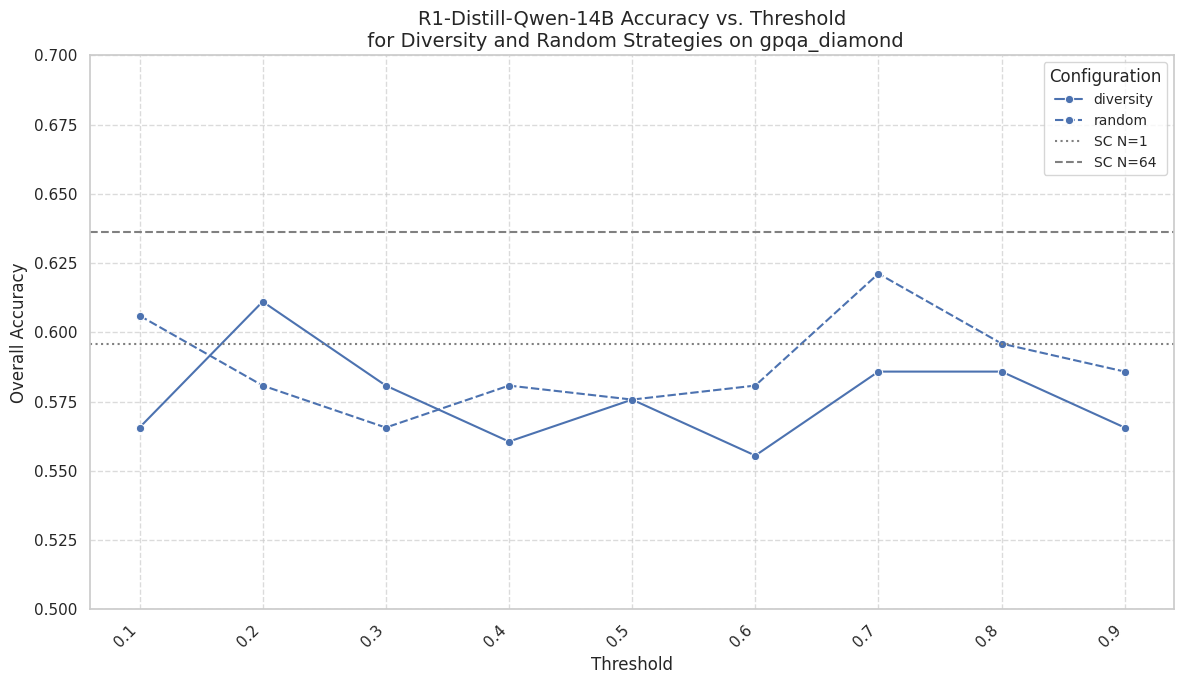

In [18]:
# Regex pattern to match the folder names and extract strategy and threshold
folder_pattern = re.compile(
    r"^(diversity|random)_n64_thresh([\d\.]+?)$"
)

# --- Data Collection (for accuracy vs threshold) ---
all_results_list_threshold = [] # Use a new name to avoid confusion

# Iterate through each model defined in models_config
for model_name, base_results_path_str in models_config.items():
    search_dir = Path(base_results_path_str)
    print(f"--- Searching in: {search_dir} for model: {model_name} ---")

    if not search_dir.exists():
         print(f"WARNING: Search directory not found: {search_dir}. Skipping this model.")
         continue

    # Iterate through items (folders) within the search directory
    for item in search_dir.iterdir():
        if item.is_dir():
            match = folder_pattern.match(item.name)
            if match:
                config_name = item.name
                json_file_path = item / "aggregated_metrics.json"

                if json_file_path.exists():
                    try:
                        with open(json_file_path, 'r') as f:
                            data = json.load(f)

                        metrics = data.get("metrics", {})
                        accuracy_str = metrics.get("overall_accuracy")
                        dataset_name = data.get("dataset")

                        if accuracy_str is not None and dataset_name is not None:
                            try:
                                accuracy = float(accuracy_str)
                                all_results_list_threshold.append({
                                    "model": model_name,
                                    "dataset": dataset_name,
                                    "config_name": config_name,
                                    "accuracy": accuracy,
                                    "threshold": float(match.group(2)),
                                    "strategy": match.group(1), # 'diversity' or 'random'
                                })

                            except ValueError:
                                print(f"  Error: Could not convert accuracy '{accuracy_str}' to float or threshold '{match.group(2)}' in {json_file_path}")
                        else:
                            missing = []
                            if accuracy_str is None: missing.append("'overall_accuracy' under 'metrics'")
                            if dataset_name is None: missing.append("'dataset'")
                            print(f"  Warning: Missing expected fields in {json_file_path}: {', '.join(missing)}. Skipping.")

                    except json.JSONDecodeError:
                        print(f"  Error: Could not decode JSON from {json_file_path}")
                    except Exception as e:
                        print(f"  Error: An unexpected error occurred while processing {json_file_path}: {e}")


# Convert the list of dictionaries to a Pandas DataFrame
df_threshold = pd.DataFrame(all_results_list_threshold)

# Ensure thresholds are numeric and sort for correct line plotting
if not df_threshold.empty:
    df_threshold['threshold'] = pd.to_numeric(df_threshold['threshold'])
    # Sort by strategy, threshold, and model for consistent plotting
    df_threshold = df_threshold.sort_values(by=["strategy", "threshold", "model"])

    print("\n--- Collected Data (Accuracy vs Threshold) ---")
    print(df_threshold)
else:
    print("\nNo data found for Accuracy vs Threshold plots.")


# --- Get SC=1 and SC=64 Accuracies specifically for R1-Distill-Qwen-14B ---
sc_comparison_data_r1 = {}
target_model = "R1-Distill-Qwen-14B"

if 'results_df' in locals() or 'results_df' in globals():
    sc_comparison_df = results_df[
        (results_df['sc_value'].isin([1, 64])) &
        (results_df['model'] == target_model)
    ].copy() # Filter for SC values AND the target model

    if not sc_comparison_df.empty:
        print(f"\n--- SC=1 and SC=64 Accuracies ({target_model}, from first cell) ---")
        print(sc_comparison_df.to_string(index=False))

        # Store in a dictionary for easier lookup: {sc_value: accuracy}
        for _, row in sc_comparison_df.iterrows():
            sc_val = row['sc_value']
            acc = row['accuracy']
            sc_comparison_data_r1[sc_val] = acc
    else:
         print(f"\nWarning: 'results_df' from the first cell was found, but contains no data for SC=1 or SC=64 for {target_model}.")
else:
    print("\nWarning: 'results_df' from the first cell (Accuracy vs SC value) was not found.")
    print("SC=1 and SC=64 comparison lines will not be plotted.")
    sc_comparison_data_r1 = {} # Ensure it's empty if not found


# --- Plotting (Accuracy vs Threshold - Combined for R1-Distill-Qwen-14B only) ---
if not df_threshold_filtered.empty:

    # Use seaborn style
    try:
        sns.set_theme(style="whitegrid")
        print("\nUsing seaborn style.")
    except ImportError:
        print("\nSeaborn not installed, using default matplotlib style.")

    plt.figure(figsize=(12, 7))

    # Create the line plot using seaborn on the FILTERED DataFrame
    ax = sns.lineplot(
        x='threshold',
        y='accuracy',
        style='strategy', # Style (linestyle/marker) by strategy
        marker='o',     # Add circles at data points
        data=df_threshold_filtered,
        # palette can be used if you want specific colors for strategies
    )

    plt.xlabel("Threshold", fontsize=12)
    plt.ylabel("Overall Accuracy", fontsize=12)
    dataset_title = df_threshold_filtered['dataset'].unique()[0] if not df_threshold_filtered['dataset'].empty else "Unknown Dataset"
    plt.title(f"{target_model} Accuracy vs. Threshold\n for Diversity and Random Strategies on {dataset_title}", fontsize=14)


    # Set x-ticks to the unique threshold values
    unique_thresholds = sorted(df_threshold_filtered['threshold'].unique())
    if len(unique_thresholds) > 0:
         plt.xticks(unique_thresholds, rotation=45, ha="right")


    # --- Collect handles and labels for the legend ---
    legend_handles = []
    legend_labels = []

    # 1. Get handles/labels from the seaborn lineplot (for strategy styles)
    # ax.get_legend_handles_labels() will get the handles/labels associated
    # with the 'style' mapping in this case.
    handles_seaborn, labels_seaborn = ax.get_legend_handles_labels()
    legend_handles.extend(handles_seaborn)
    legend_labels.extend(labels_seaborn)


    # 2. Add Horizontal Lines for SC=1 and SC=64 and collect their handles/labels
    line_color = 'gray' # Choose a color for the SC lines


    if 1 in sc_comparison_data_r1:
        acc_sc1 = sc_comparison_data_r1[1]
        # Create the line AND capture its handle and label
        sc1_line = ax.axhline(acc_sc1, color=line_color, linestyle=':', label='SC N=1') # Label directly here is also good practice
        legend_handles.append(sc1_line)
        legend_labels.append('SC N=1') # Explicitly add the string label


    if 64 in sc_comparison_data_r1:
         acc_sc64 = sc_comparison_data_r1[64]
         # Create the line AND capture its handle and label
         sc64_line = ax.axhline(acc_sc64, color=line_color, linestyle='--', label='SC N=64') # Label directly here
         legend_handles.append(sc64_line)
         legend_labels.append('SC N=64') # Explicitly add the string label


    # --- Set Y-axis Limits ---
    plt.ylim(0.5, 0.7) # Set the specific y-axis range


    # --- Create the legend using the collected handles and labels ---
    # Optional: Sort labels for better legend order
    # E.g., strategies first, then SC lines
    # Get the current order from the collected labels
    current_order = list(legend_labels)
    # Define desired order keywords
    order_keywords = ['diversity', 'random', 'SC N=1', 'SC N=64']
    # Create sorted lists based on the desired order
    # Use a helper tuple (order_index, original_index, handle/label) for sorting
    sorted_items = sorted(zip(legend_labels, legend_handles),
                          key=lambda item: (order_keywords.index(item[0]) if item[0] in order_keywords else len(order_keywords), current_order.index(item[0])))

    ordered_labels = [item[0] for item in sorted_items]
    ordered_handles = [item[1] for item in sorted_items]


    ax.legend(handles=ordered_handles, labels=ordered_labels, title="Configuration", fontsize=10)


    plt.grid(True, which='both', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

elif not all_results_list_threshold:
    print("\nNo threshold data collected at all. Cannot generate plots.")